In [ ]:
import os
import shutil
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
from PIL import Image

from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, 
                                     Dense, Flatten, Dropout, Input)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

# Custom Callback to track epoch time and metrics
class EpochMetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_times = []
        self.epoch_metrics = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        epoch_metrics = {
            'epoch': epoch + 1,
            'duration_minutes': epoch_duration / 60,
            'accuracy': logs.get('accuracy', 0),
            'val_accuracy': logs.get('val_accuracy', 0),
            'loss': logs.get('loss', 0),
            'val_loss': logs.get('val_loss', 0)
        }
        self.epoch_times.append(epoch_duration)
        self.epoch_metrics.append(epoch_metrics)
        
        # Print detailed metrics
        print(f"\nEpoch {epoch + 1} Metrics:")
        print(f"Time taken: {epoch_metrics['duration_minutes']:.2f} minutes")
        print(f"Training Accuracy: {epoch_metrics['accuracy']:.4f}")
        print(f"Validation Accuracy: {epoch_metrics['val_accuracy']:.4f}")
        print(f"Training Loss: {epoch_metrics['loss']:.4f}")
        print(f"Validation Loss: {epoch_metrics['val_loss']:.4f}")

# Set paths
BASE_PATH = '/Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/400BirdSpecies'
WORKING_PATH = '/Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Enhanced data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

n_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())

# Load previous training state if exists
def load_previous_state():
    try:
        with open(os.path.join(WORKING_PATH, 'training_state.pkl'), 'rb') as f:
            state = pickle.load(f)
            return state.get('start_epoch', 0), state.get('best_val_accuracy', 0)
    except FileNotFoundError:
        return 0, 0

# Save training state
def save_training_state(start_epoch, best_val_accuracy):
    state = {
        'start_epoch': start_epoch,
        'best_val_accuracy': best_val_accuracy
    }
    with open(os.path.join(WORKING_PATH, 'training_state.pkl'), 'wb') as f:
        pickle.dump(state, f)

# Create custom CNN model
def create_custom_cnn(input_shape=(224, 224, 3), num_classes=n_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, 
               kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.35),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Flatten and Fully Connected Layers
        Flatten(),
        
        Dense(512, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Epoch metrics callback
epoch_metrics_callback = EpochMetricsCallback()

# Resume training or start new
start_epoch, best_val_accuracy = load_previous_state()

# Create and compile the model
model = create_custom_cnn()
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# Callbacks
checkpoint = ModelCheckpoint(
    filepath=os.path.join(WORKING_PATH, 'checkpoint_epoch-{epoch:02d}_val_loss-{val_loss:.2f}.weights.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-7
)

# Function to save best model
def save_best_model(model, val_accuracy, best_val_accuracy):
    # Remove any existing model files in working directory
    for filename in os.listdir(WORKING_PATH):
        if filename.endswith('.h5'):
            os.remove(os.path.join(WORKING_PATH, filename))
    
    # Save the new model if it's the best
    if val_accuracy > best_val_accuracy:
        model.save(os.path.join(WORKING_PATH, 'best_model.h5'))
        print(f"New best model saved with validation accuracy: {val_accuracy}")
        return val_accuracy
    return best_val_accuracy

# Training loop
total_epochs = 50
histories = []
total_start_time = time.time()

for epoch in range(start_epoch, total_epochs):
    print(f'\nEpoch {epoch + 1}/{total_epochs}')
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=1,
        callbacks=[checkpoint, early_stopping, reduce_lr, epoch_metrics_callback],
        verbose=1
    )
    
    # Check and save best model
    val_accuracy = history.history['val_accuracy'][0]
    best_val_accuracy = save_best_model(model, val_accuracy, best_val_accuracy)
    
    # Save first epoch model only once
    if epoch == 0:
        model.save(os.path.join(WORKING_PATH, 'first_epoch_model.h5'))
    
    # Track history
    histories.append(history)
    
    # Save training state
    save_training_state(epoch + 1, best_val_accuracy)

# Total training time
total_training_time = (time.time() - total_start_time) / 60
print(f"\nTotal Training Time: {total_training_time:.2f} minutes")

# Print epoch metrics summary
print("\nEpoch Metrics Summary:")
for metrics in epoch_metrics_callback.epoch_metrics:
    print(f"Epoch {metrics['epoch']}:")
    print(f"  Duration: {metrics['duration_minutes']:.2f} minutes")
    print(f"  Training Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Validation Accuracy: {metrics['val_accuracy']:.4f}")
    print(f"  Training Loss: {metrics['loss']:.4f}")
    print(f"  Validation Loss: {metrics['val_loss']:.4f}")

# Combine histories
combined_history = {}
for metric in history.history.keys():
    combined_history[metric] = [h.history[metric][0] for h in histories]

class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

history = DotDict(combined_history)

# Plot metrics
def plot_metrics(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy plot
    ax1.plot(history.accuracy, label='Training Accuracy')
    ax1.plot(history.val_accuracy, label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.loss, label='Training Loss')
    ax2.plot(history.val_loss, label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    # Precision plot
    ax3.plot(history.precision, label='Training Precision')
    ax3.plot(history.val_precision, label='Validation Precision')
    ax3.set_title('Model Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    
    # Recall plot
    ax4.plot(history.recall, label='Training Recall')
    ax4.plot(history.val_recall, label='Validation Recall')
    ax4.set_title('Model Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Generate Confusion Matrix
def plot_confusion_matrix():
    # Predict on test data
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Prediction function with top 5 species
def predict_image(image_path):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict probabilities
    predictions = model.predict(img_array)[0]
    
    # Get top 5 predictions
    top_5_indices = predictions.argsort()[-5:][::-1]
    top_5_species = [class_labels[idx] for idx in top_5_indices]
    top_5_probs = [predictions[idx] * 100 for idx in top_5_indices]
    
    # Display results
    print("Top 5 Predictions:")
    for species, prob in zip(top_5_species, top_5_probs):
        print(f"{species}: {prob:.2f}%")
    
    # Return top prediction
    return top_5_species[0], top_5_probs[0]

# Plot metrics and confusion matrix
plot_metrics(history)
plot_confusion_matrix()

In [ ]:

# Example of predicting an image from test folder
# Replace with an actual image path from your test folder
test_images = os.listdir(TEST_PATH)
for folder in test_images:
    folder_path = os.path.join(TEST_PATH, folder)
    if os.path.isdir(folder_path):
        test_image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
        print("\nPredicting image:", test_image_path)
        predict_image(test_image_path)
        break

Found 58389 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.

Global Epoch 1/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.0049 - loss: 6.9002 - precision_6: 0.0066 - recall_6: 2.0134e-05
Epoch 1: val_accuracy improved from -inf to 0.00800, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-6.64.weights.h5



Global Epoch 1 Metrics:
Time taken: 8.92 minutes
Training Accuracy: 0.0077
Validation Accuracy: 0.0080
Training Loss: 6.6546
Validation Loss: 6.6427
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_1.h5


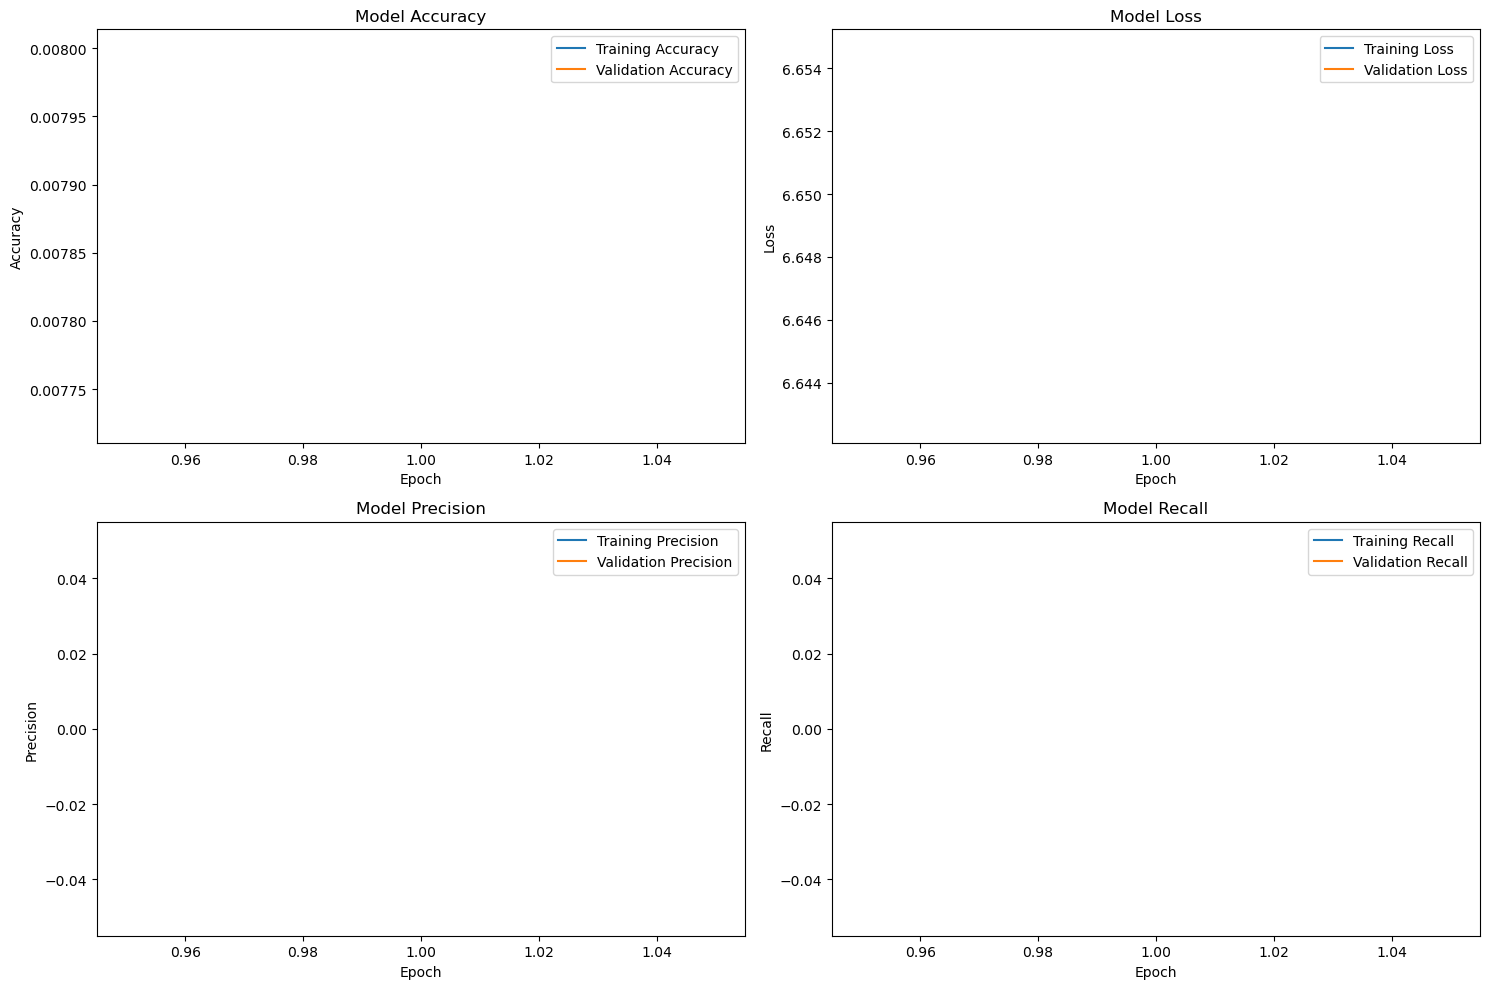

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 536s 292ms/step - accuracy: 0.0049 - loss: 6.9000 - precision_6: 0.0066 - recall_6: 2.0141e-05 - val_accuracy: 0.0080 - val_loss: 6.6427 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.00800000037997961

Global Epoch 2/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.0201 - loss: 6.0935 - precision_6: 0.1195 - recall_6: 4.5348e-04
Epoch 1: val_accuracy improved from 0.00800 to 0.04700, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-5.42.weights.h5



Global Epoch 2 Metrics:
Time taken: 8.87 minutes
Training Accuracy: 0.0255
Validation Accuracy: 0.0470
Training Loss: 5.9444
Validation Loss: 5.4157
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_2.h5


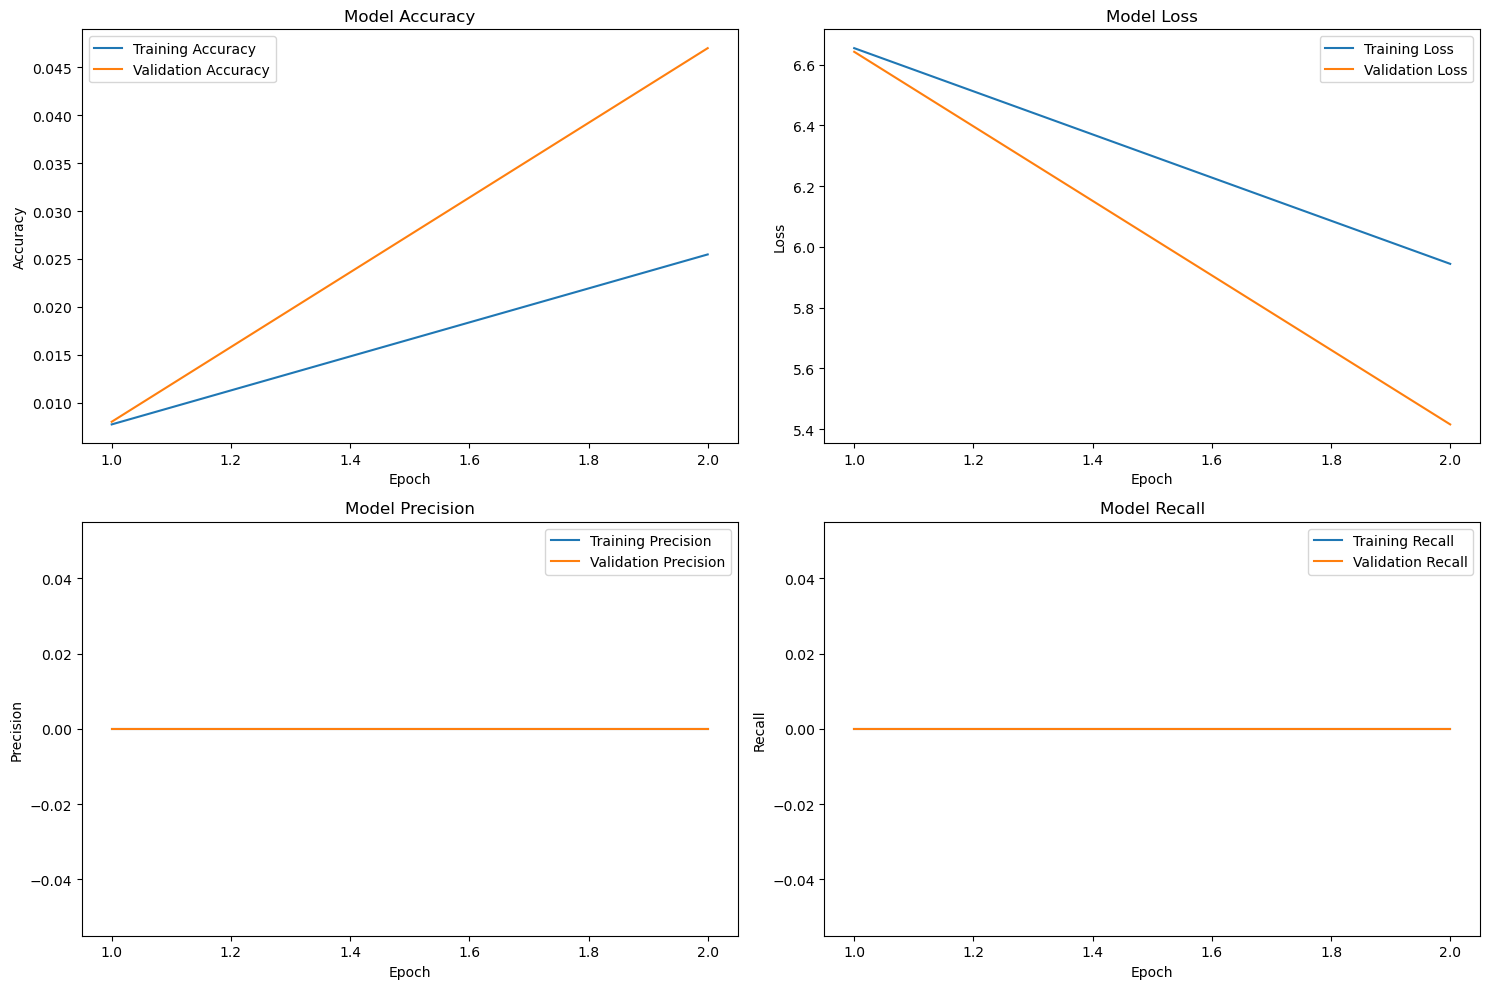

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 533s 292ms/step - accuracy: 0.0201 - loss: 6.0934 - precision_6: 0.1195 - recall_6: 4.5337e-04 - val_accuracy: 0.0470 - val_loss: 5.4157 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.04699999839067459

Global Epoch 3/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.0411 - loss: 5.5321 - precision_6: 0.2514 - recall_6: 6.0106e-04
Epoch 1: val_accuracy improved from 0.04700 to 0.10750, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-4.82.weights.h5



Global Epoch 3 Metrics:
Time taken: 9.08 minutes
Training Accuracy: 0.0468
Validation Accuracy: 0.1075
Training Loss: 5.4339
Validation Loss: 4.8222
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_3.h5


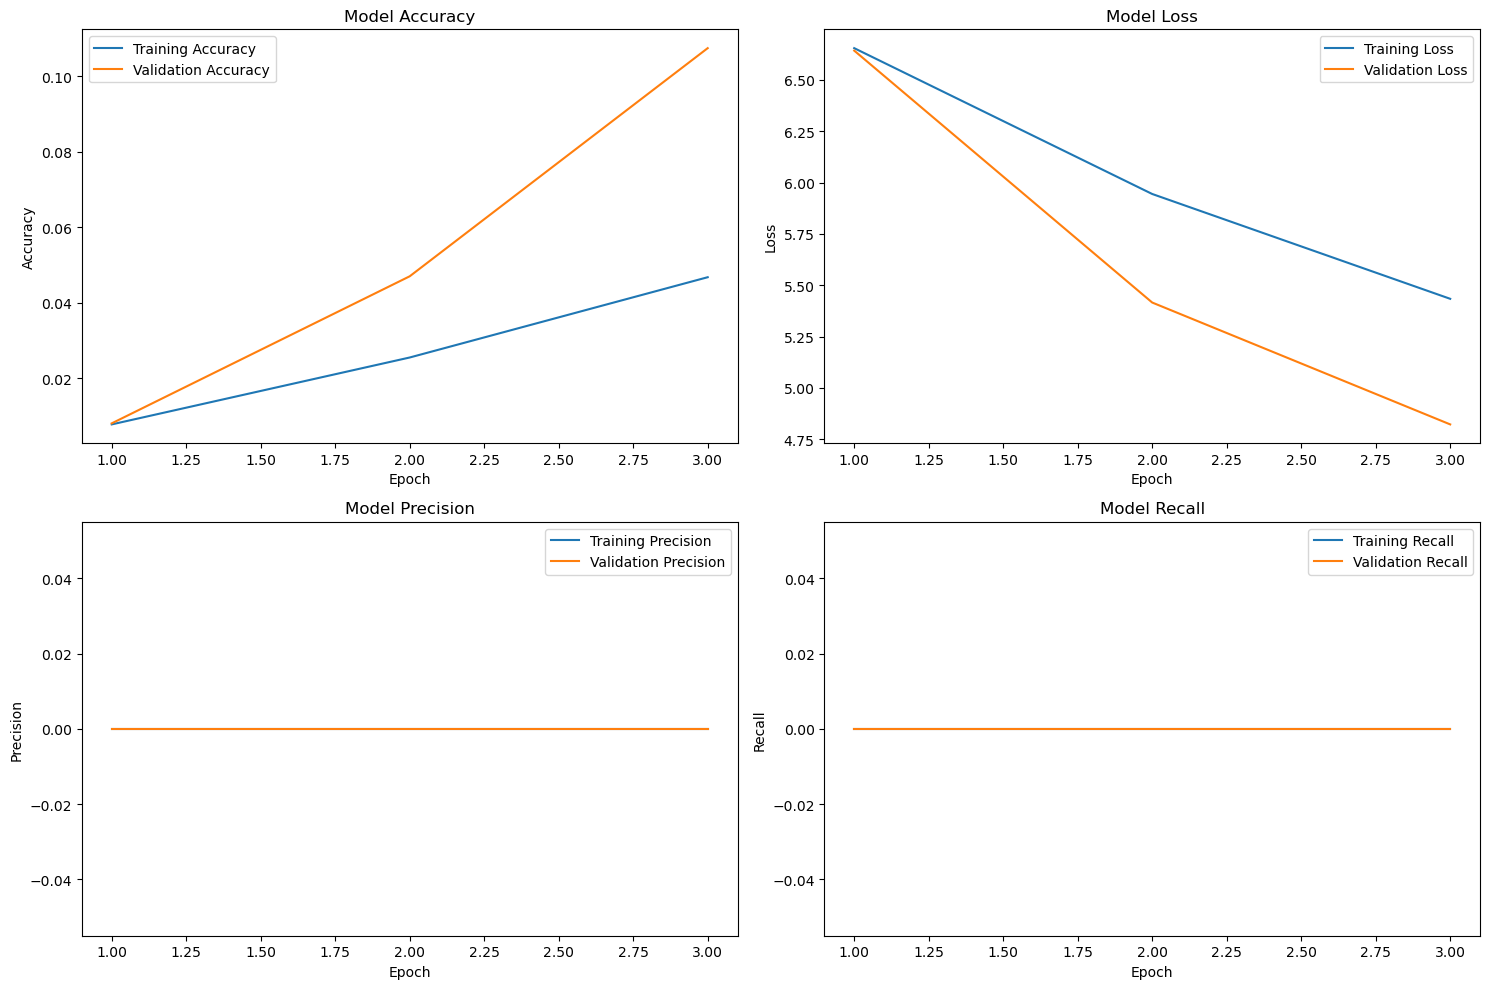

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 545s 299ms/step - accuracy: 0.0411 - loss: 5.5320 - precision_6: 0.2514 - recall_6: 6.0105e-04 - val_accuracy: 0.1075 - val_loss: 4.8222 - val_precision_6: 0.7143 - val_recall_6: 0.0025 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.10750000178813934

Global Epoch 4/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.0621 - loss: 5.1607 - precision_6: 0.2402 - recall_6: 8.1215e-04
Epoch 1: val_accuracy improved from 0.10750 to 0.15800, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-4.41.weights.h5



Global Epoch 4 Metrics:
Time taken: 8.94 minutes
Training Accuracy: 0.0695
Validation Accuracy: 0.1580
Training Loss: 5.0673
Validation Loss: 4.4095
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_4.h5


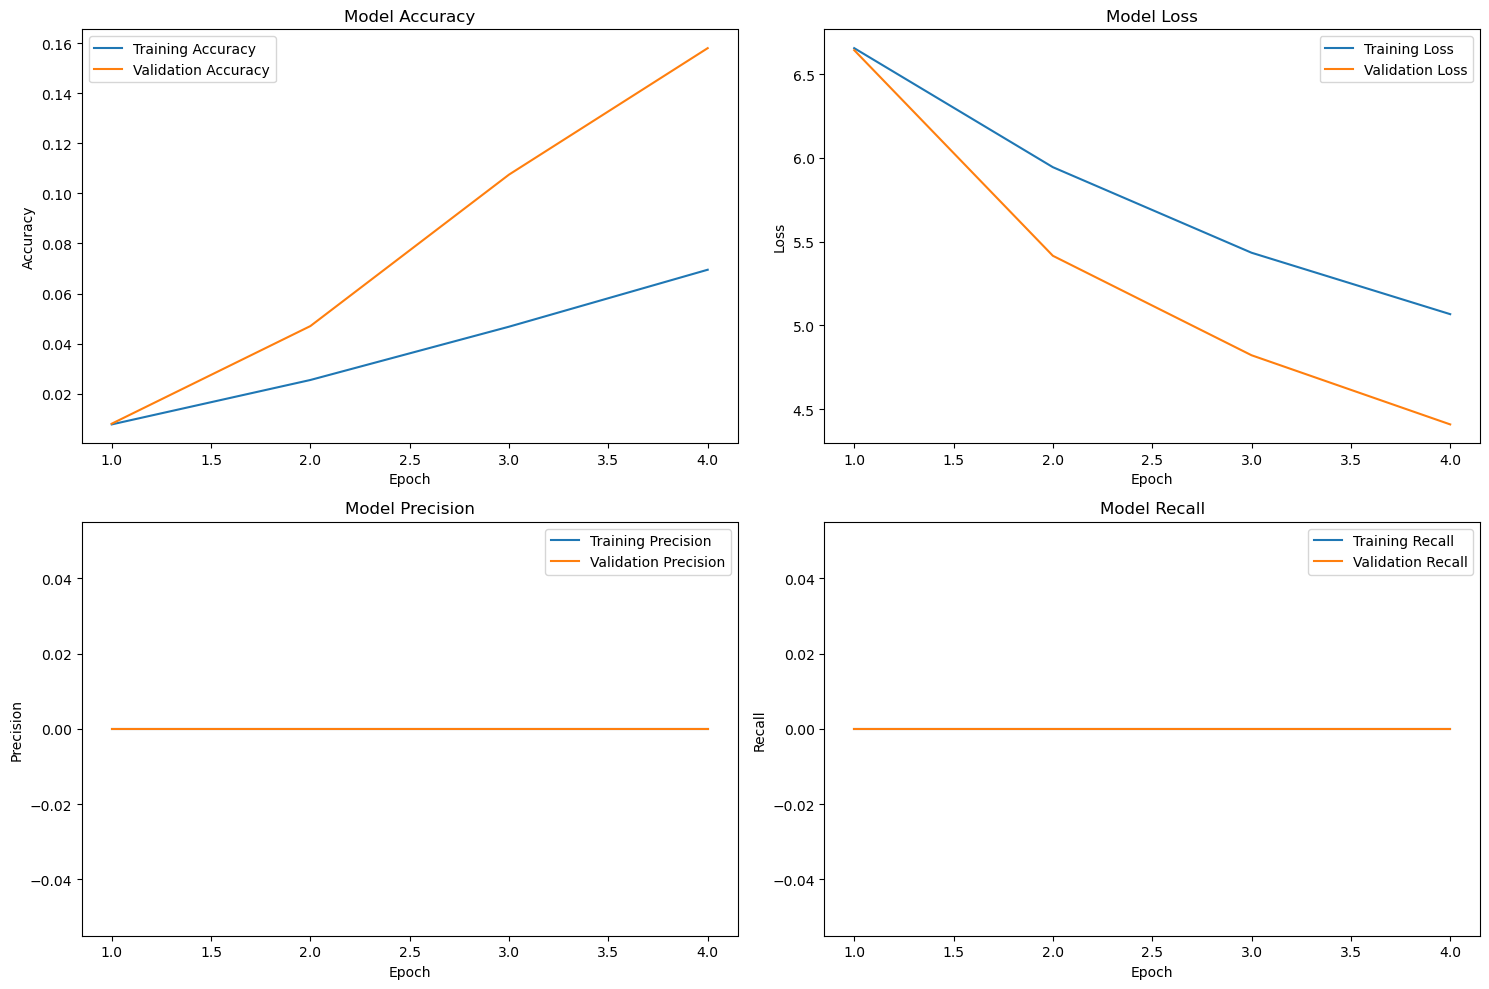

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 537s 294ms/step - accuracy: 0.0621 - loss: 5.1606 - precision_6: 0.2402 - recall_6: 8.1232e-04 - val_accuracy: 0.1580 - val_loss: 4.4095 - val_precision_6: 0.8667 - val_recall_6: 0.0065 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.15800000727176666

Global Epoch 5/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.0897 - loss: 4.8359 - precision_6: 0.3909 - recall_6: 0.0019
Epoch 1: val_accuracy improved from 0.15800 to 0.21350, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-4.01.weights.h5



Global Epoch 5 Metrics:
Time taken: 8.88 minutes
Training Accuracy: 0.0952
Validation Accuracy: 0.2135
Training Loss: 4.7706
Validation Loss: 4.0083
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_5.h5


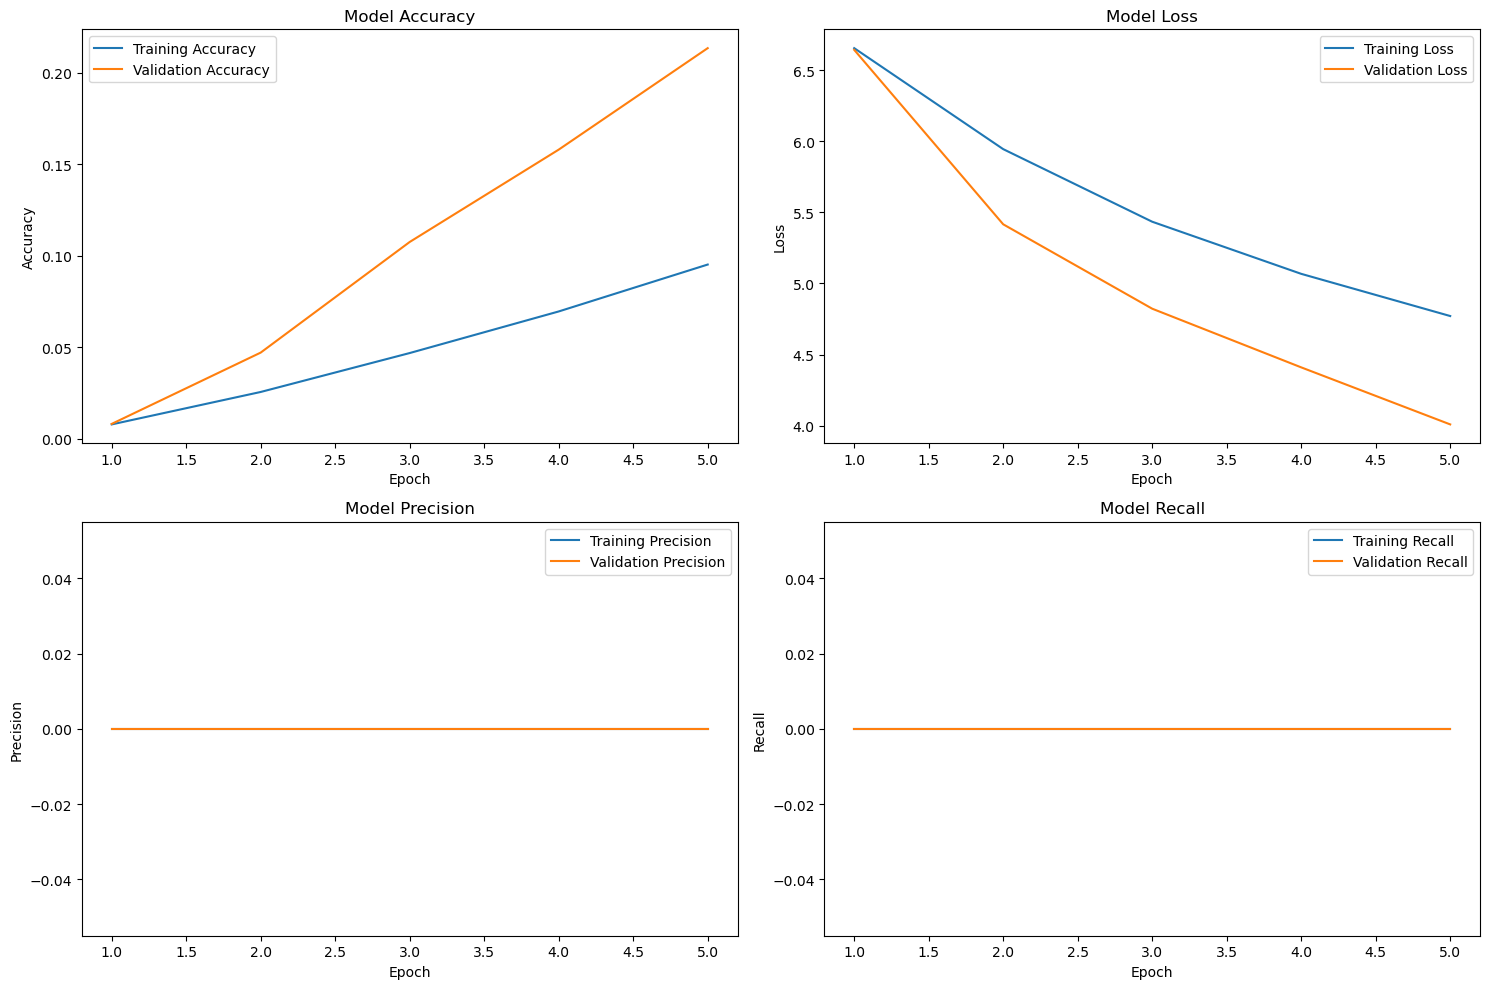

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 533s 292ms/step - accuracy: 0.0897 - loss: 4.8359 - precision_6: 0.3910 - recall_6: 0.0019 - val_accuracy: 0.2135 - val_loss: 4.0083 - val_precision_6: 0.8889 - val_recall_6: 0.0120 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.2134999930858612

Global Epoch 6/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.1153 - loss: 4.5822 - precision_6: 0.5333 - recall_6: 0.0048
Epoch 1: val_accuracy improved from 0.21350 to 0.23800, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-3.79.weights.h5



Global Epoch 6 Metrics:
Time taken: 8.91 minutes
Training Accuracy: 0.1199
Validation Accuracy: 0.2380
Training Loss: 4.5292
Validation Loss: 3.7885
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_6.h5


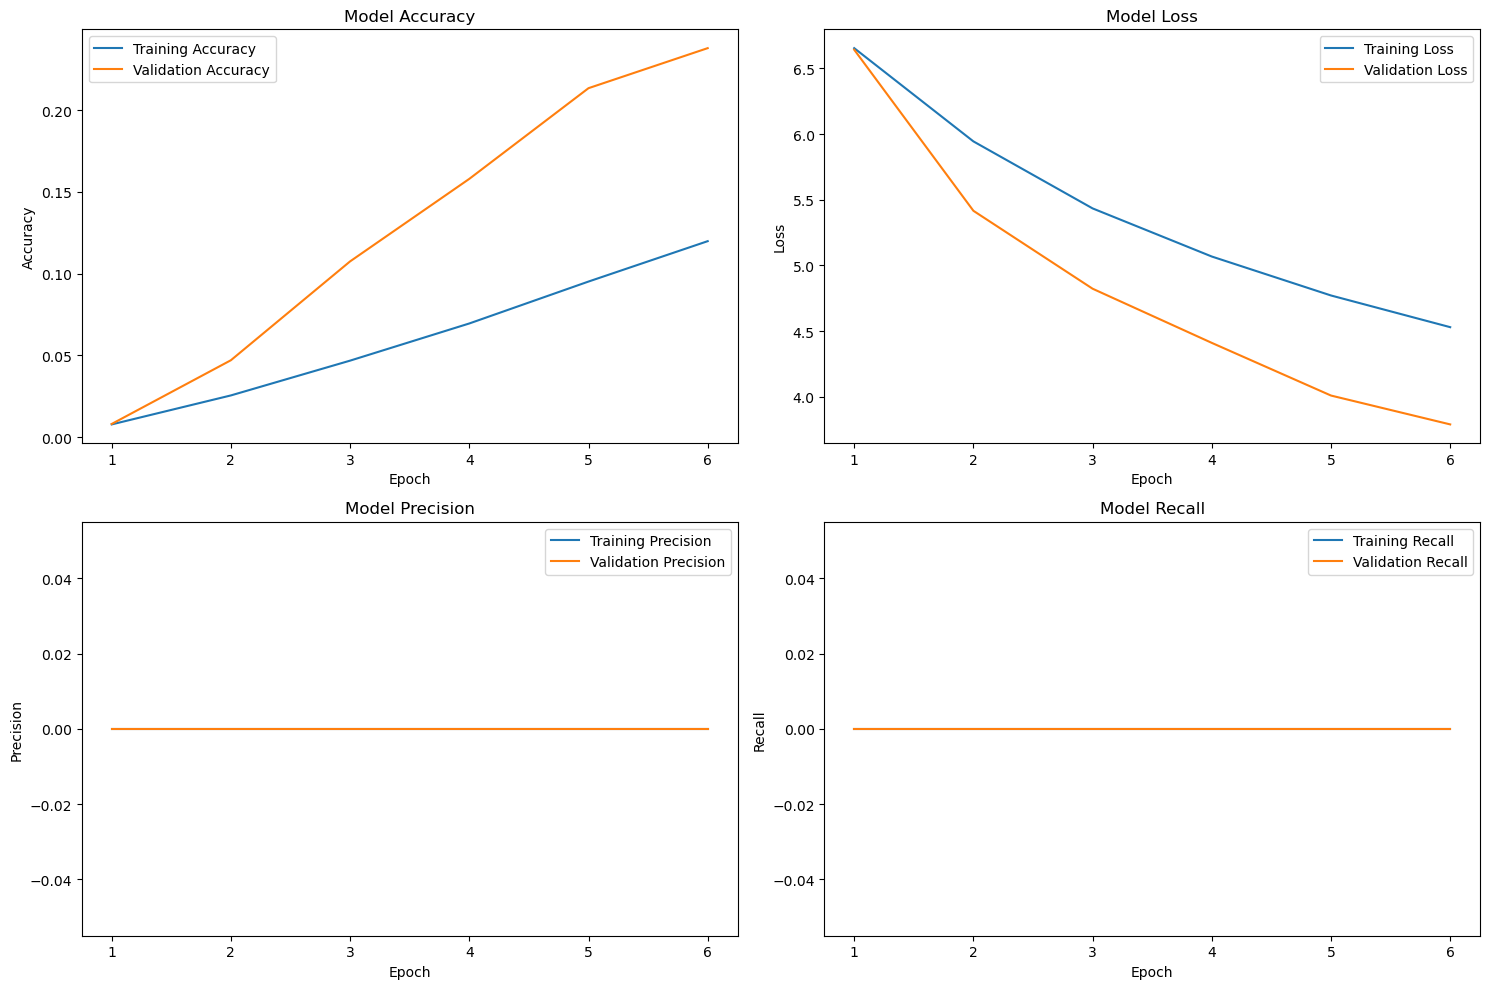

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.1153 - loss: 4.5822 - precision_6: 0.5333 - recall_6: 0.0048 - val_accuracy: 0.2380 - val_loss: 3.7885 - val_precision_6: 0.8824 - val_recall_6: 0.0225 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.23800000548362732

Global Epoch 7/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.1410 - loss: 4.3509 - precision_6: 0.5571 - recall_6: 0.0083
Epoch 1: val_accuracy improved from 0.23800 to 0.25900, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-3.63.weights.h5



Global Epoch 7 Metrics:
Time taken: 8.91 minutes
Training Accuracy: 0.1450
Validation Accuracy: 0.2590
Training Loss: 4.3218
Validation Loss: 3.6291
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_7.h5


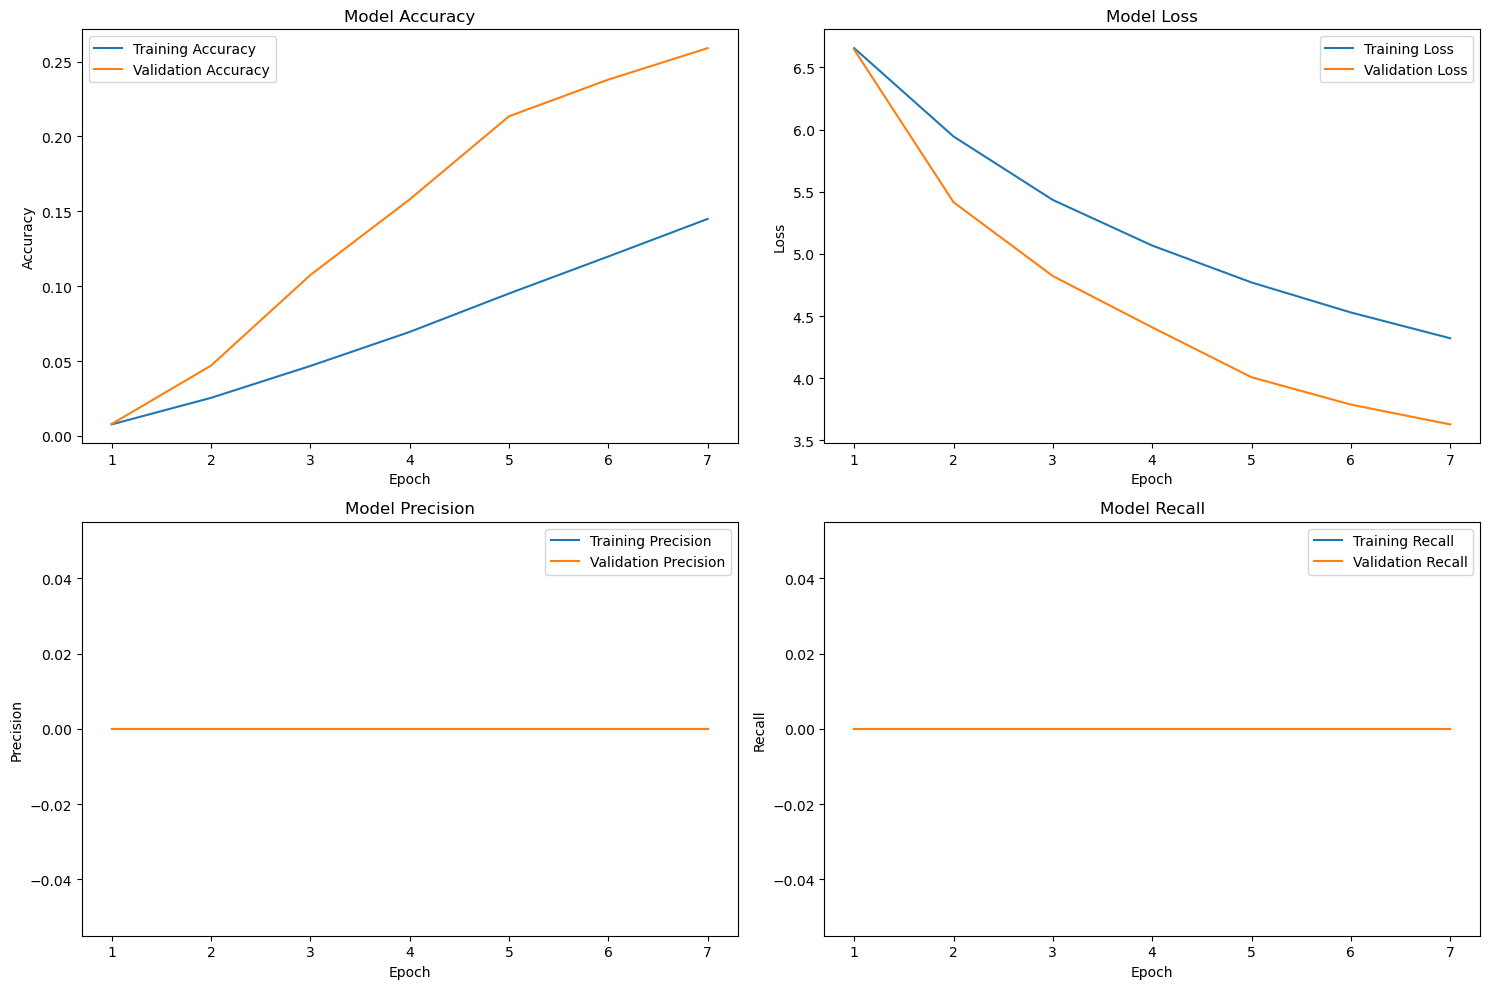

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.1410 - loss: 4.3508 - precision_6: 0.5571 - recall_6: 0.0083 - val_accuracy: 0.2590 - val_loss: 3.6291 - val_precision_6: 0.8500 - val_recall_6: 0.0340 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.2590000033378601

Global Epoch 8/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.1587 - loss: 4.1951 - precision_6: 0.6335 - recall_6: 0.0118
Epoch 1: val_accuracy improved from 0.25900 to 0.29850, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-3.42.weights.h5



Global Epoch 8 Metrics:
Time taken: 8.90 minutes
Training Accuracy: 0.1640
Validation Accuracy: 0.2985
Training Loss: 4.1570
Validation Loss: 3.4242
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_8.h5


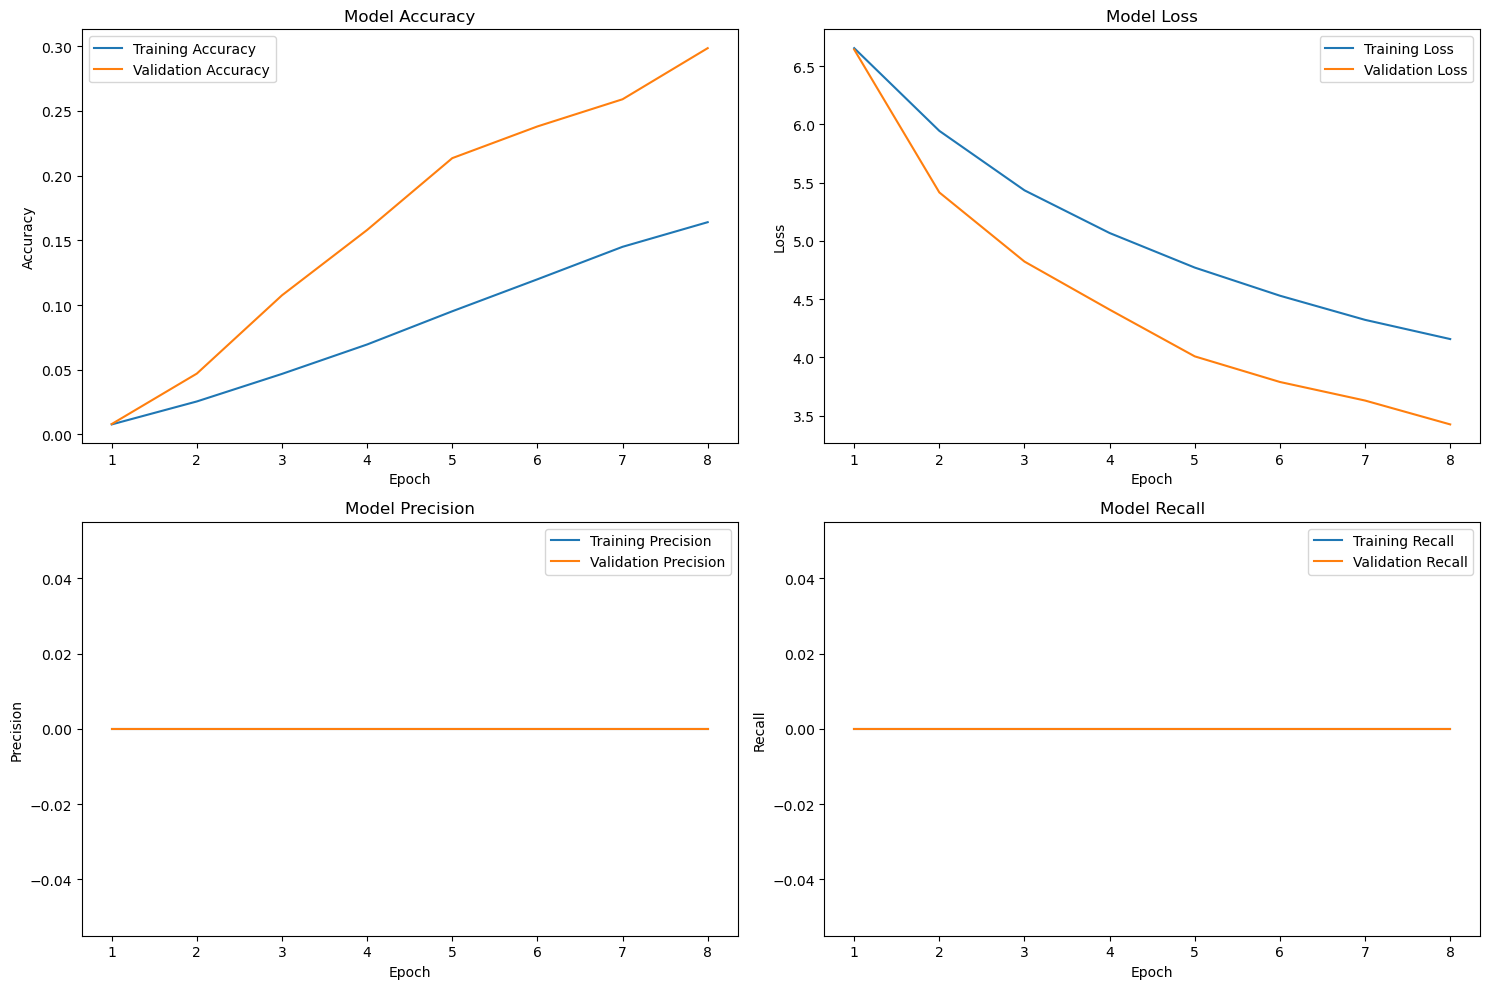

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 534s 293ms/step - accuracy: 0.1587 - loss: 4.1951 - precision_6: 0.6335 - recall_6: 0.0118 - val_accuracy: 0.2985 - val_loss: 3.4242 - val_precision_6: 0.8197 - val_recall_6: 0.0500 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.2985000014305115

Global Epoch 9/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.1822 - loss: 4.0238 - precision_6: 0.6351 - recall_6: 0.0169
Epoch 1: val_accuracy did not improve from 0.29850



Global Epoch 9 Metrics:
Time taken: 8.90 minutes
Training Accuracy: 0.1856
Validation Accuracy: 0.2965
Training Loss: 4.0039
Validation Loss: 3.3352
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_9.h5


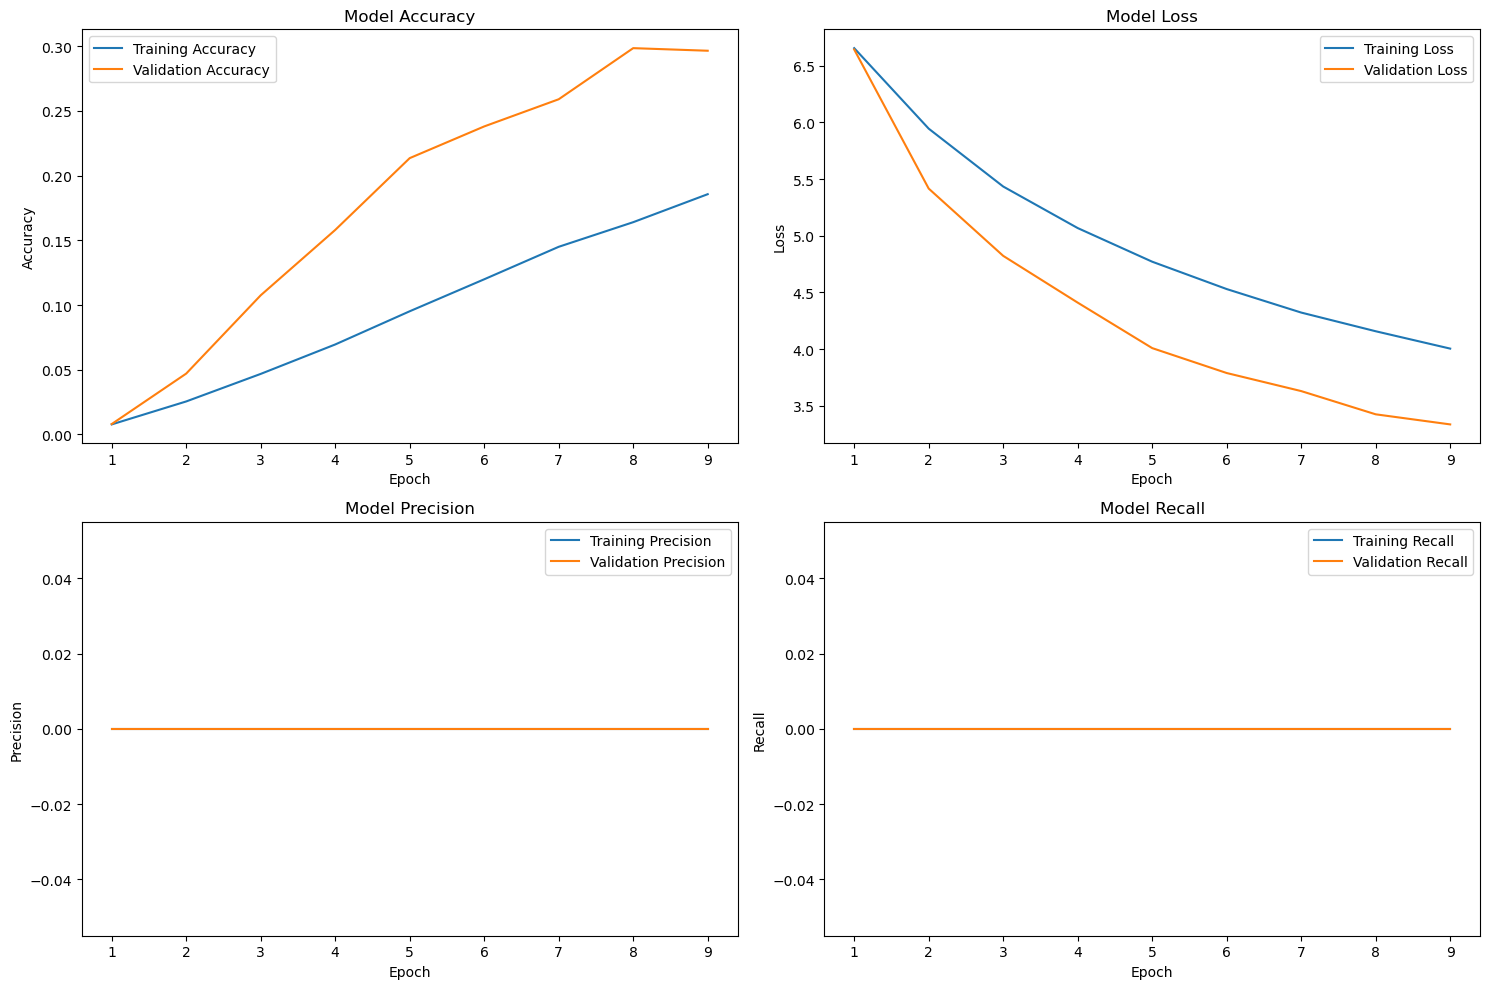

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.1822 - loss: 4.0238 - precision_6: 0.6351 - recall_6: 0.0169 - val_accuracy: 0.2965 - val_loss: 3.3352 - val_precision_6: 0.7312 - val_recall_6: 0.0680 - learning_rate: 1.0000e-04

Global Epoch 10/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.1987 - loss: 3.9075 - precision_6: 0.6343 - recall_6: 0.0219
Epoch 1: val_accuracy improved from 0.29850 to 0.32150, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-3.20.weights.h5



Global Epoch 10 Metrics:
Time taken: 8.90 minutes
Training Accuracy: 0.2033
Validation Accuracy: 0.3215
Training Loss: 3.8816
Validation Loss: 3.2018
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_10.h5


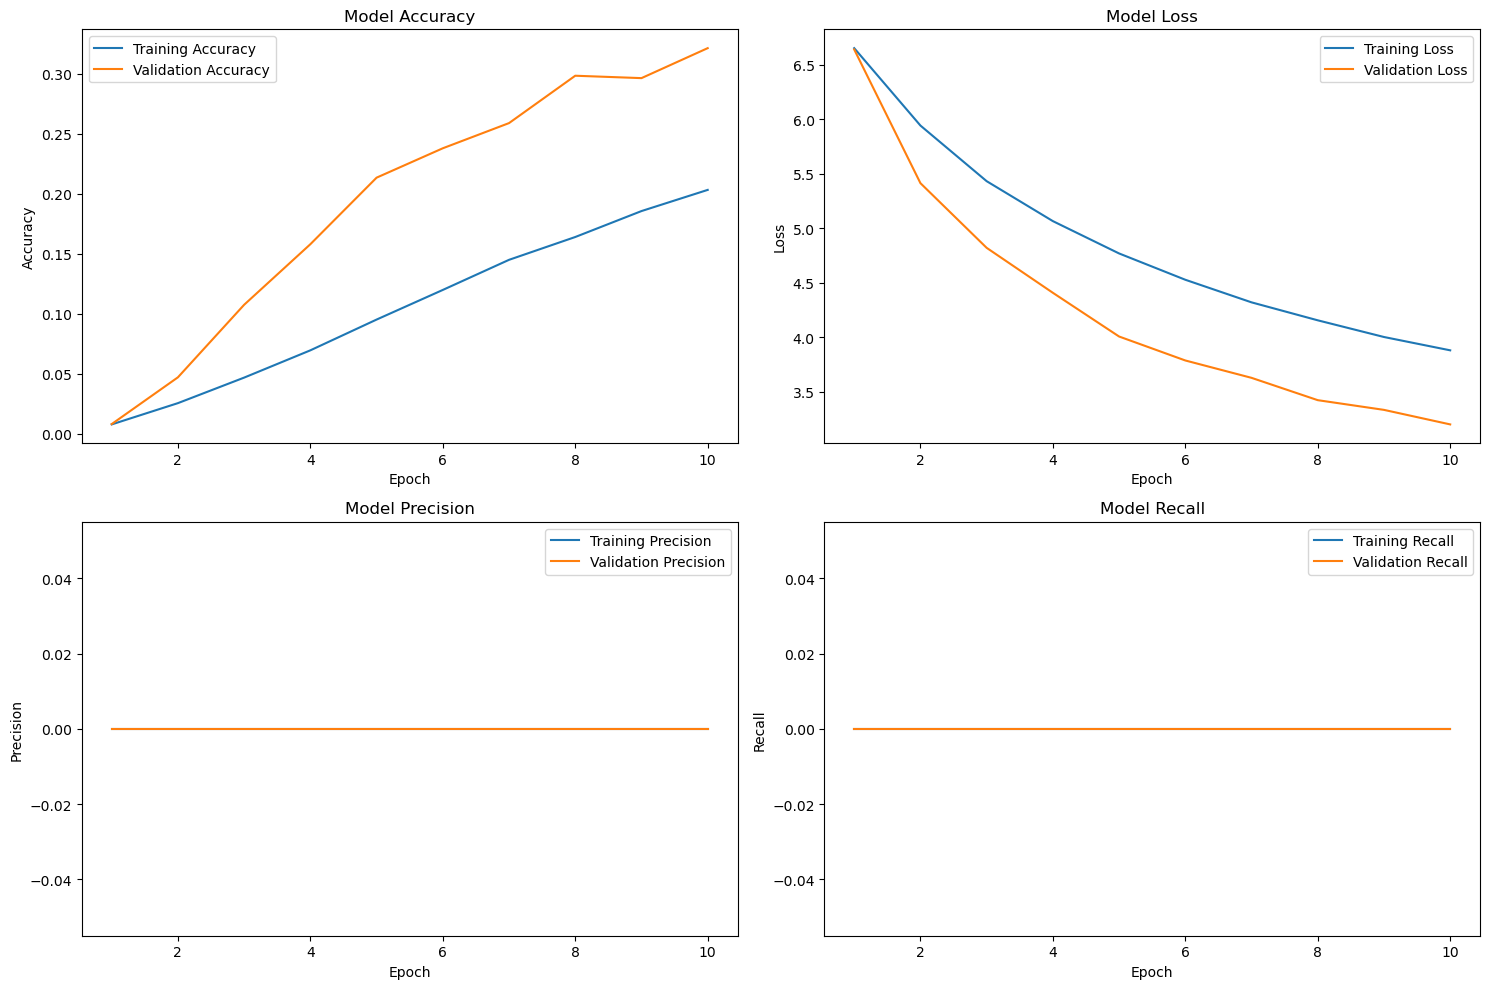

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 534s 293ms/step - accuracy: 0.1987 - loss: 3.9075 - precision_6: 0.6343 - recall_6: 0.0219 - val_accuracy: 0.3215 - val_loss: 3.2018 - val_precision_6: 0.8373 - val_recall_6: 0.0875 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.3215000033378601

Global Epoch 11/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2212 - loss: 3.7744 - precision_6: 0.6411 - recall_6: 0.0288
Epoch 1: val_accuracy improved from 0.32150 to 0.37700, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.89.weights.h5



Global Epoch 11 Metrics:
Time taken: 8.92 minutes
Training Accuracy: 0.2243
Validation Accuracy: 0.3770
Training Loss: 3.7630
Validation Loss: 2.8938
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_11.h5


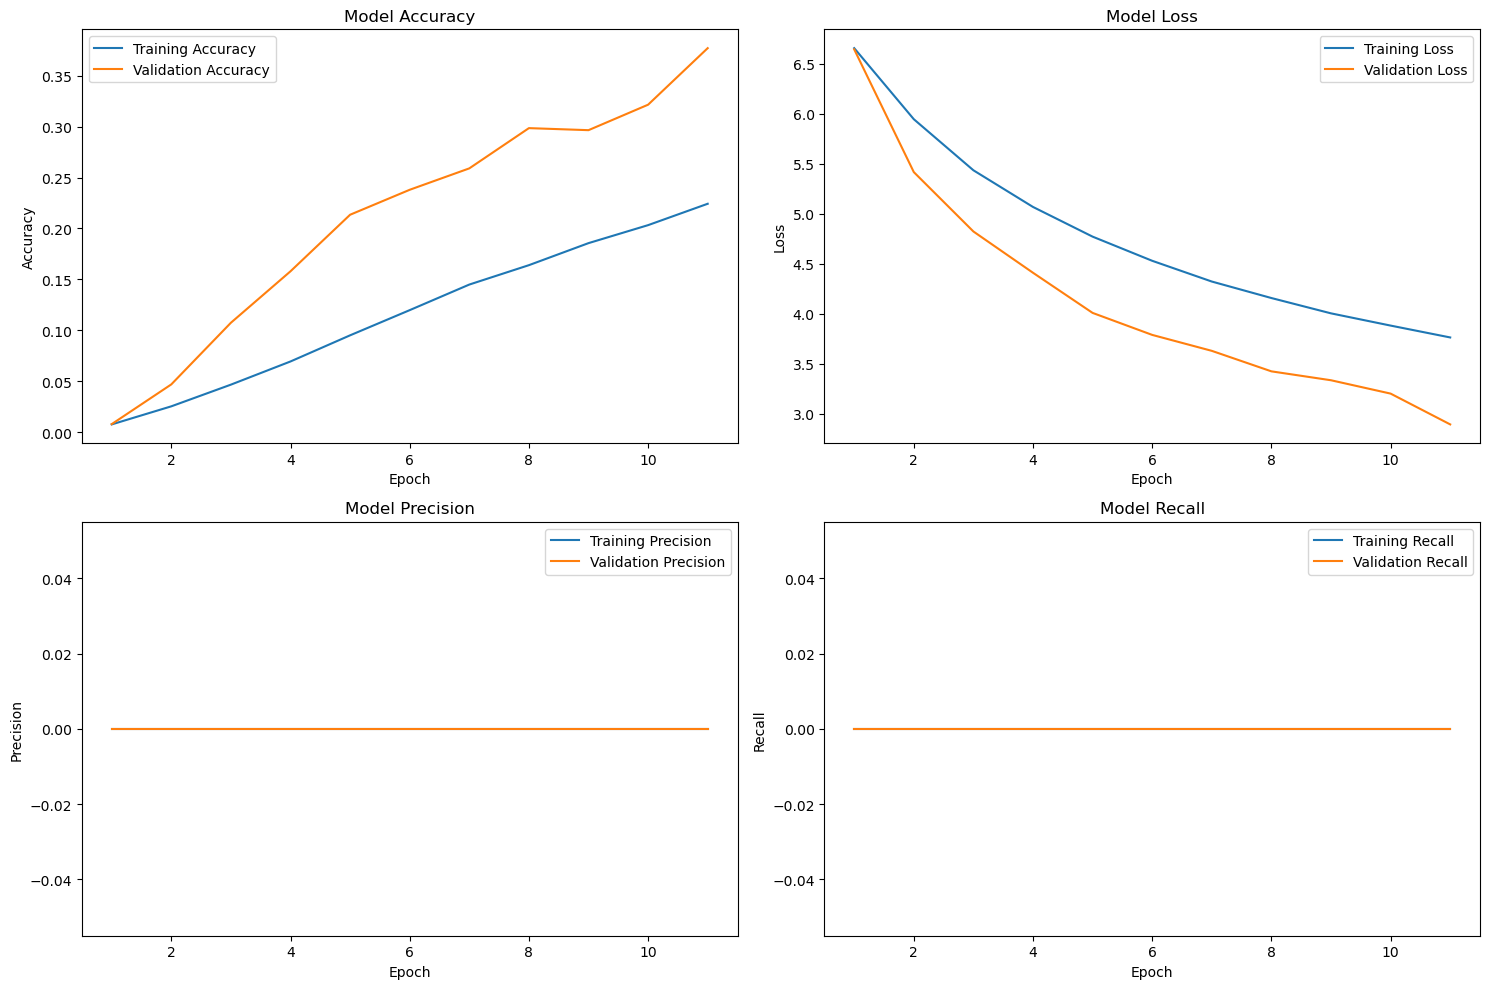

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 536s 293ms/step - accuracy: 0.2212 - loss: 3.7744 - precision_6: 0.6411 - recall_6: 0.0288 - val_accuracy: 0.3770 - val_loss: 2.8938 - val_precision_6: 0.7803 - val_recall_6: 0.1350 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.37700000405311584

Global Epoch 12/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.2365 - loss: 3.6748 - precision_6: 0.6814 - recall_6: 0.0388
Epoch 1: val_accuracy improved from 0.37700 to 0.38150, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.87.weights.h5



Global Epoch 12 Metrics:
Time taken: 8.94 minutes
Training Accuracy: 0.2407
Validation Accuracy: 0.3815
Training Loss: 3.6574
Validation Loss: 2.8657
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_12.h5


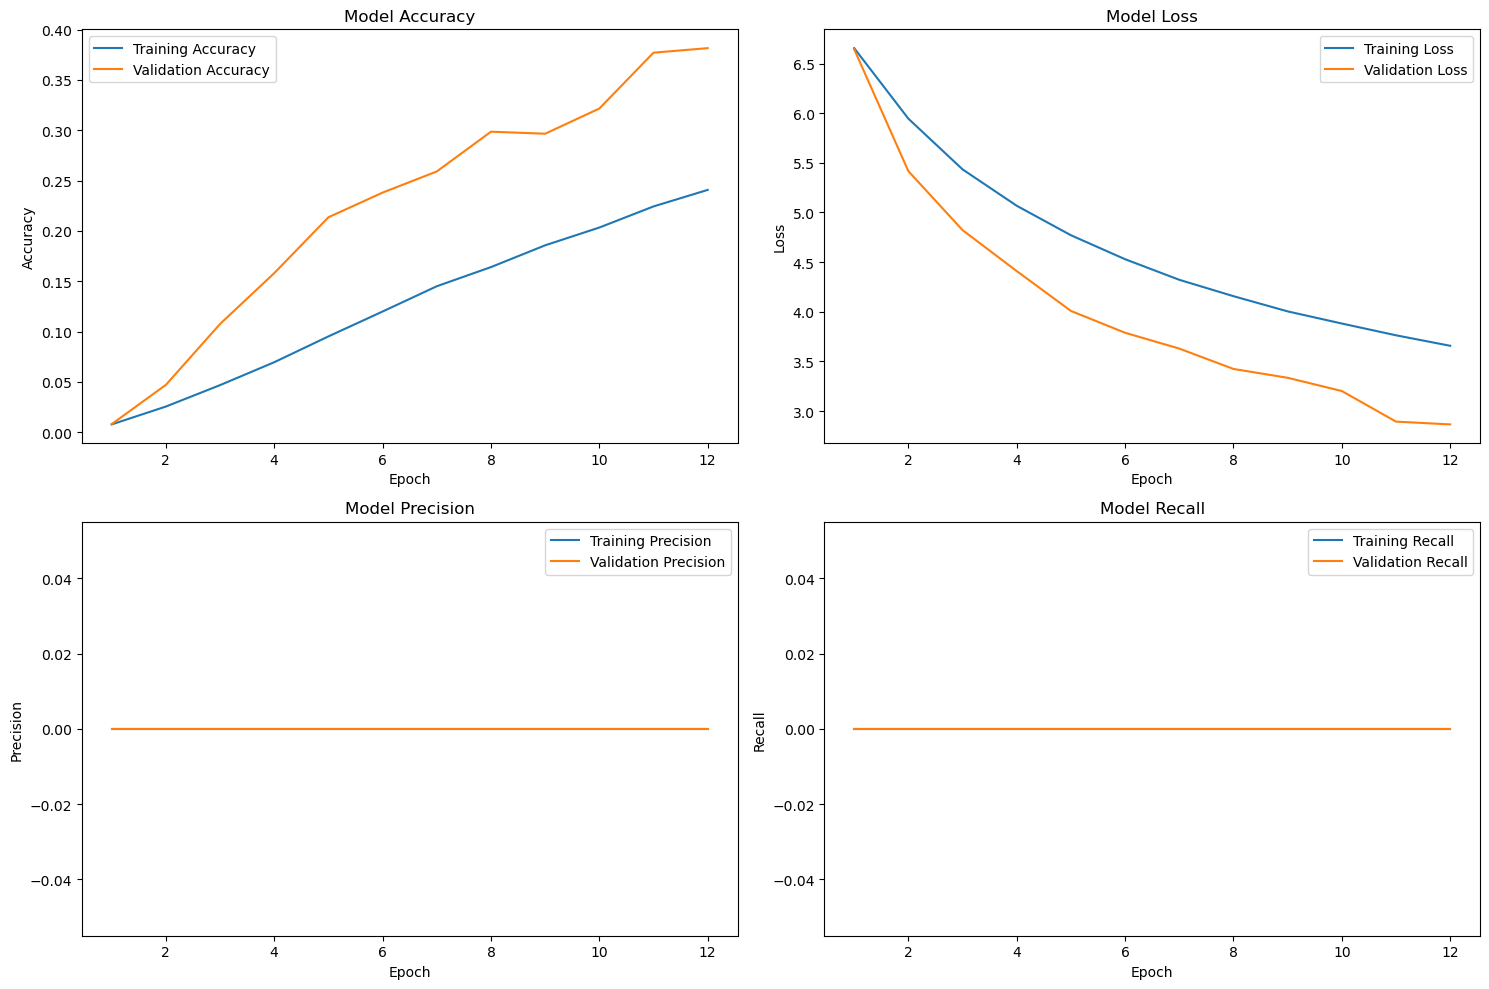

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 537s 294ms/step - accuracy: 0.2365 - loss: 3.6748 - precision_6: 0.6814 - recall_6: 0.0388 - val_accuracy: 0.3815 - val_loss: 2.8657 - val_precision_6: 0.8360 - val_recall_6: 0.1325 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.3815000057220459

Global Epoch 13/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2500 - loss: 3.5909 - precision_6: 0.6772 - recall_6: 0.0435
Epoch 1: val_accuracy improved from 0.38150 to 0.38850, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.82.weights.h5



Global Epoch 13 Metrics:
Time taken: 8.91 minutes
Training Accuracy: 0.2540
Validation Accuracy: 0.3885
Training Loss: 3.5688
Validation Loss: 2.8234
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_13.h5


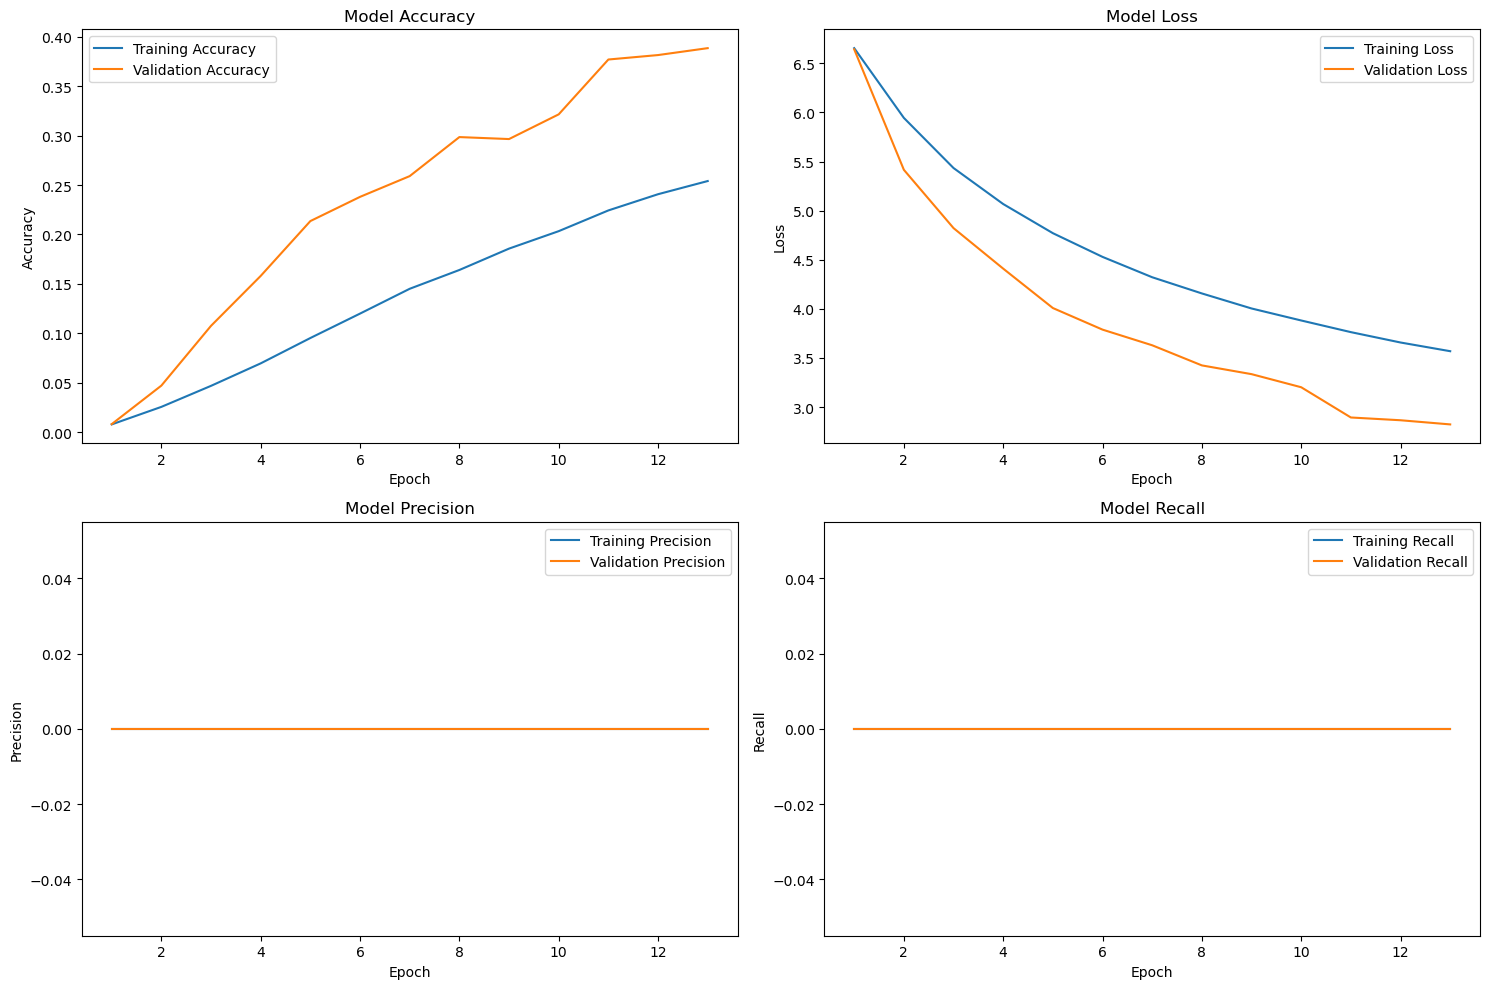

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.2500 - loss: 3.5909 - precision_6: 0.6772 - recall_6: 0.0435 - val_accuracy: 0.3885 - val_loss: 2.8234 - val_precision_6: 0.7811 - val_recall_6: 0.1445 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.38850000500679016

Global Epoch 14/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.2650 - loss: 3.4927 - precision_6: 0.6889 - recall_6: 0.0550
Epoch 1: val_accuracy did not improve from 0.38850



Global Epoch 14 Metrics:
Time taken: 8.93 minutes
Training Accuracy: 0.2665
Validation Accuracy: 0.3655
Training Loss: 3.4888
Validation Loss: 3.0260
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_14.h5


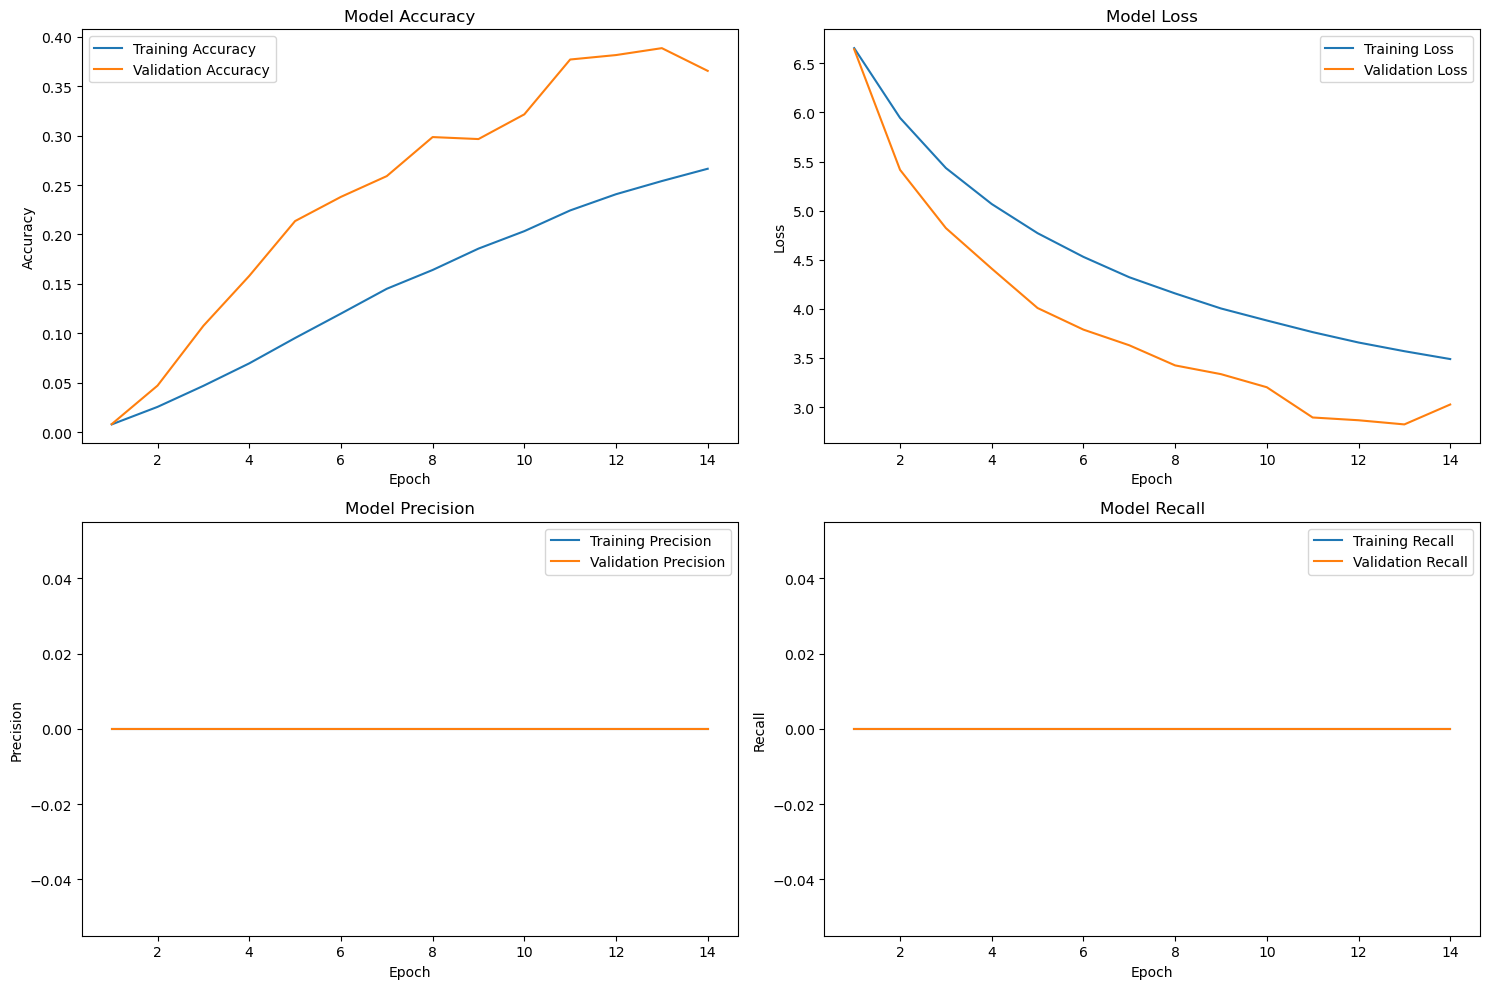

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 536s 294ms/step - accuracy: 0.2650 - loss: 3.4927 - precision_6: 0.6889 - recall_6: 0.0550 - val_accuracy: 0.3655 - val_loss: 3.0260 - val_precision_6: 0.7097 - val_recall_6: 0.1675 - learning_rate: 1.0000e-04

Global Epoch 15/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2815 - loss: 3.4134 - precision_6: 0.7100 - recall_6: 0.0656
Epoch 1: val_accuracy improved from 0.38850 to 0.47250, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.42.weights.h5



Global Epoch 15 Metrics:
Time taken: 8.90 minutes
Training Accuracy: 0.2846
Validation Accuracy: 0.4725
Training Loss: 3.3950
Validation Loss: 2.4213
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_15.h5


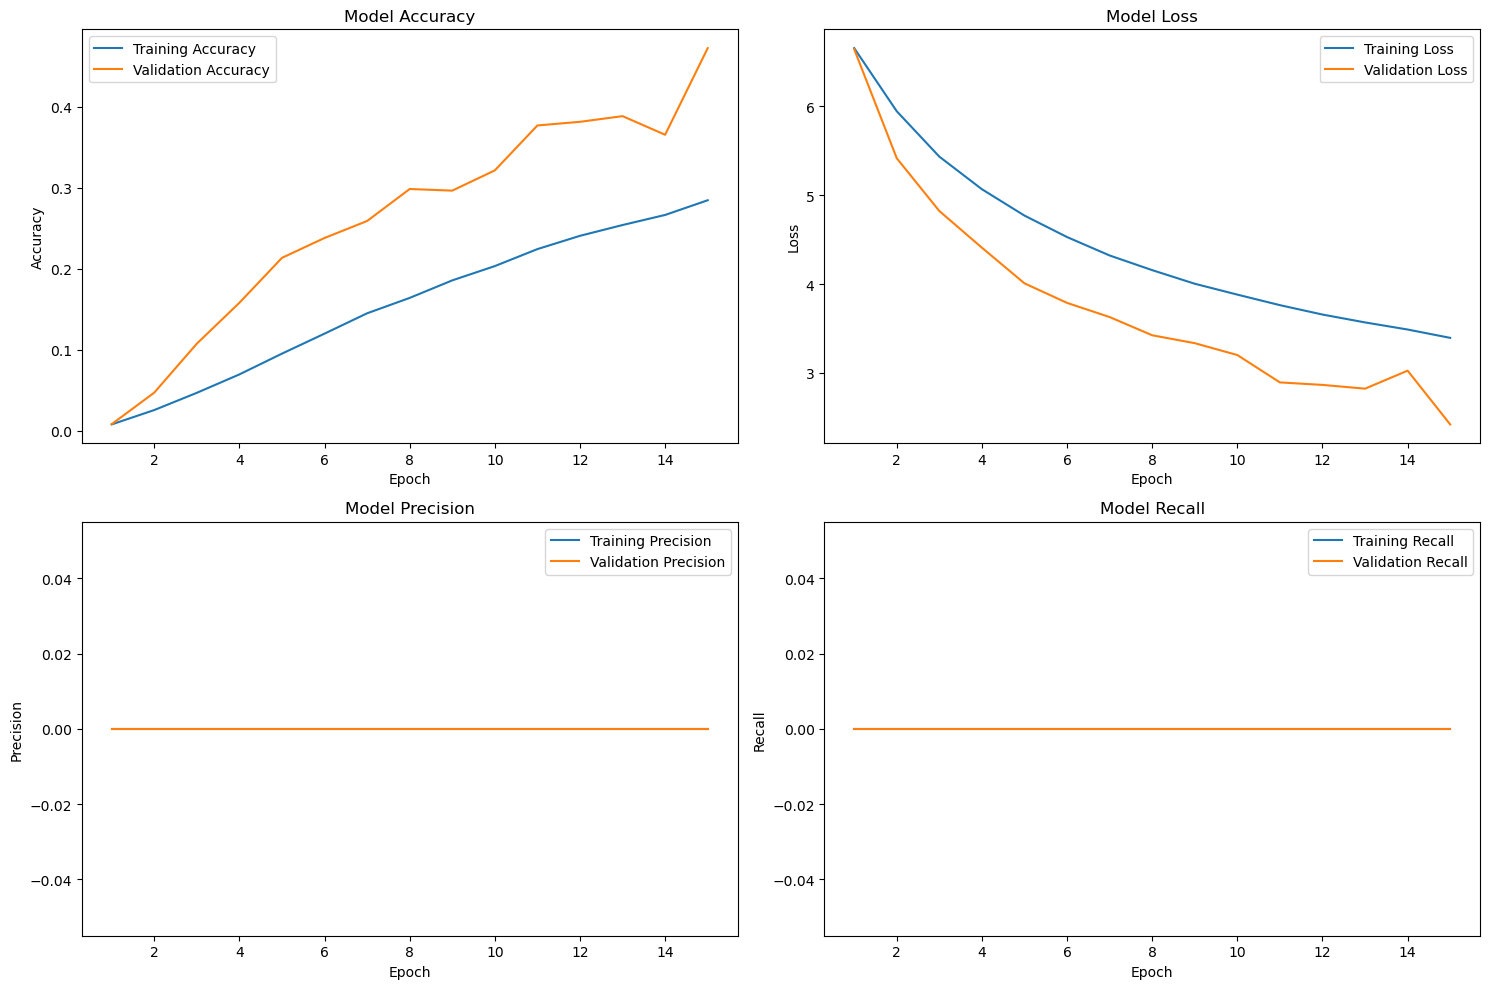

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.2815 - loss: 3.4134 - precision_6: 0.7100 - recall_6: 0.0656 - val_accuracy: 0.4725 - val_loss: 2.4213 - val_precision_6: 0.8194 - val_recall_6: 0.2405 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.4724999964237213

Global Epoch 16/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2957 - loss: 3.3461 - precision_6: 0.7221 - recall_6: 0.0757
Epoch 1: val_accuracy did not improve from 0.47250



Global Epoch 16 Metrics:
Time taken: 8.90 minutes
Training Accuracy: 0.2982
Validation Accuracy: 0.4025
Training Loss: 3.3409
Validation Loss: 2.9203
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_16.h5


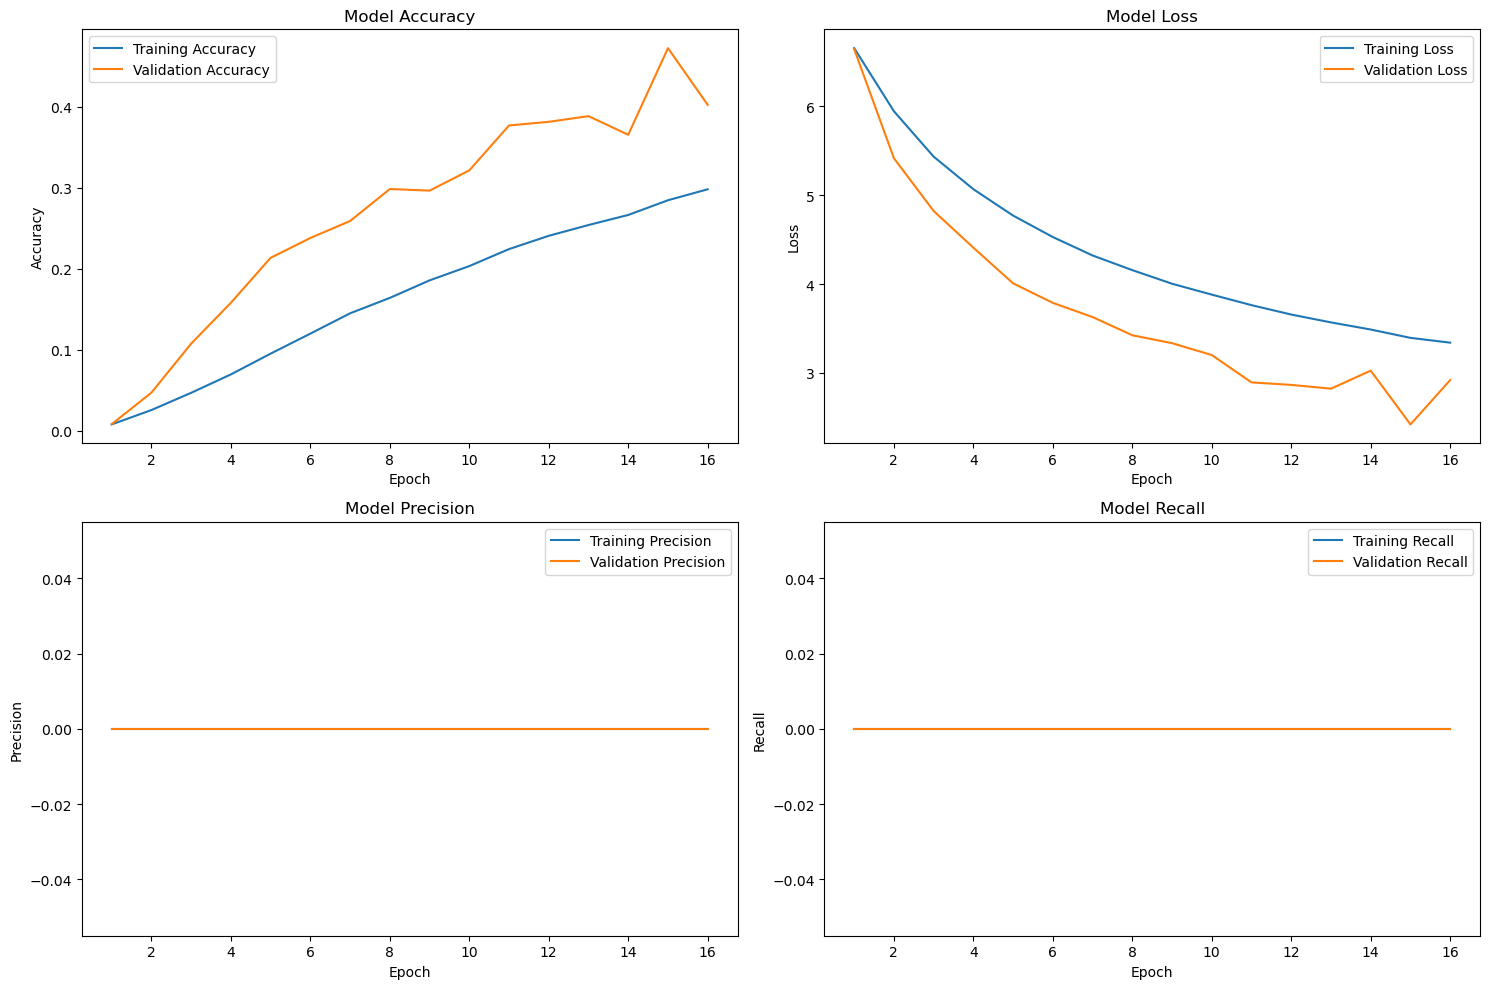

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.2958 - loss: 3.3461 - precision_6: 0.7221 - recall_6: 0.0757 - val_accuracy: 0.4025 - val_loss: 2.9203 - val_precision_6: 0.6958 - val_recall_6: 0.2230 - learning_rate: 1.0000e-04

Global Epoch 17/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.2993 - loss: 3.2956 - precision_6: 0.7095 - recall_6: 0.0816
Epoch 1: val_accuracy improved from 0.47250 to 0.48600, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.35.weights.h5



Global Epoch 17 Metrics:
Time taken: 8.94 minutes
Training Accuracy: 0.3039
Validation Accuracy: 0.4860
Training Loss: 3.2861
Validation Loss: 2.3498
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_17.h5


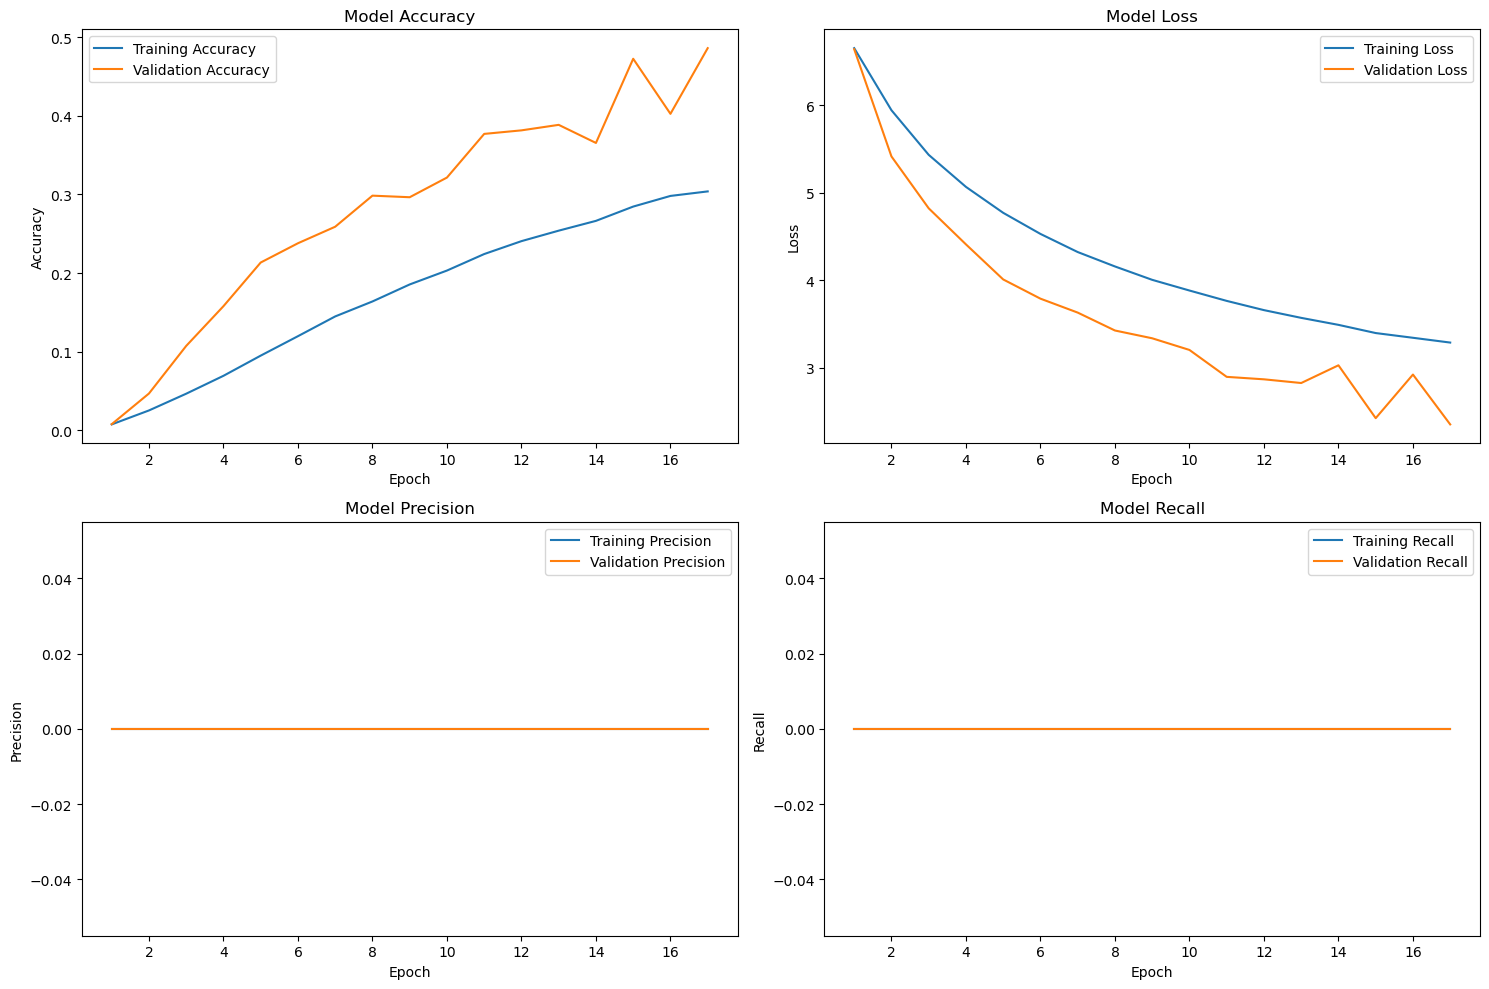

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 537s 294ms/step - accuracy: 0.2993 - loss: 3.2956 - precision_6: 0.7095 - recall_6: 0.0816 - val_accuracy: 0.4860 - val_loss: 2.3498 - val_precision_6: 0.8202 - val_recall_6: 0.2645 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.4860000014305115

Global Epoch 18/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3187 - loss: 3.2079 - precision_6: 0.7229 - recall_6: 0.0933
Epoch 1: val_accuracy improved from 0.48600 to 0.51500, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.27.weights.h5



Global Epoch 18 Metrics:
Time taken: 8.94 minutes
Training Accuracy: 0.3165
Validation Accuracy: 0.5150
Training Loss: 3.2243
Validation Loss: 2.2653
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_18.h5


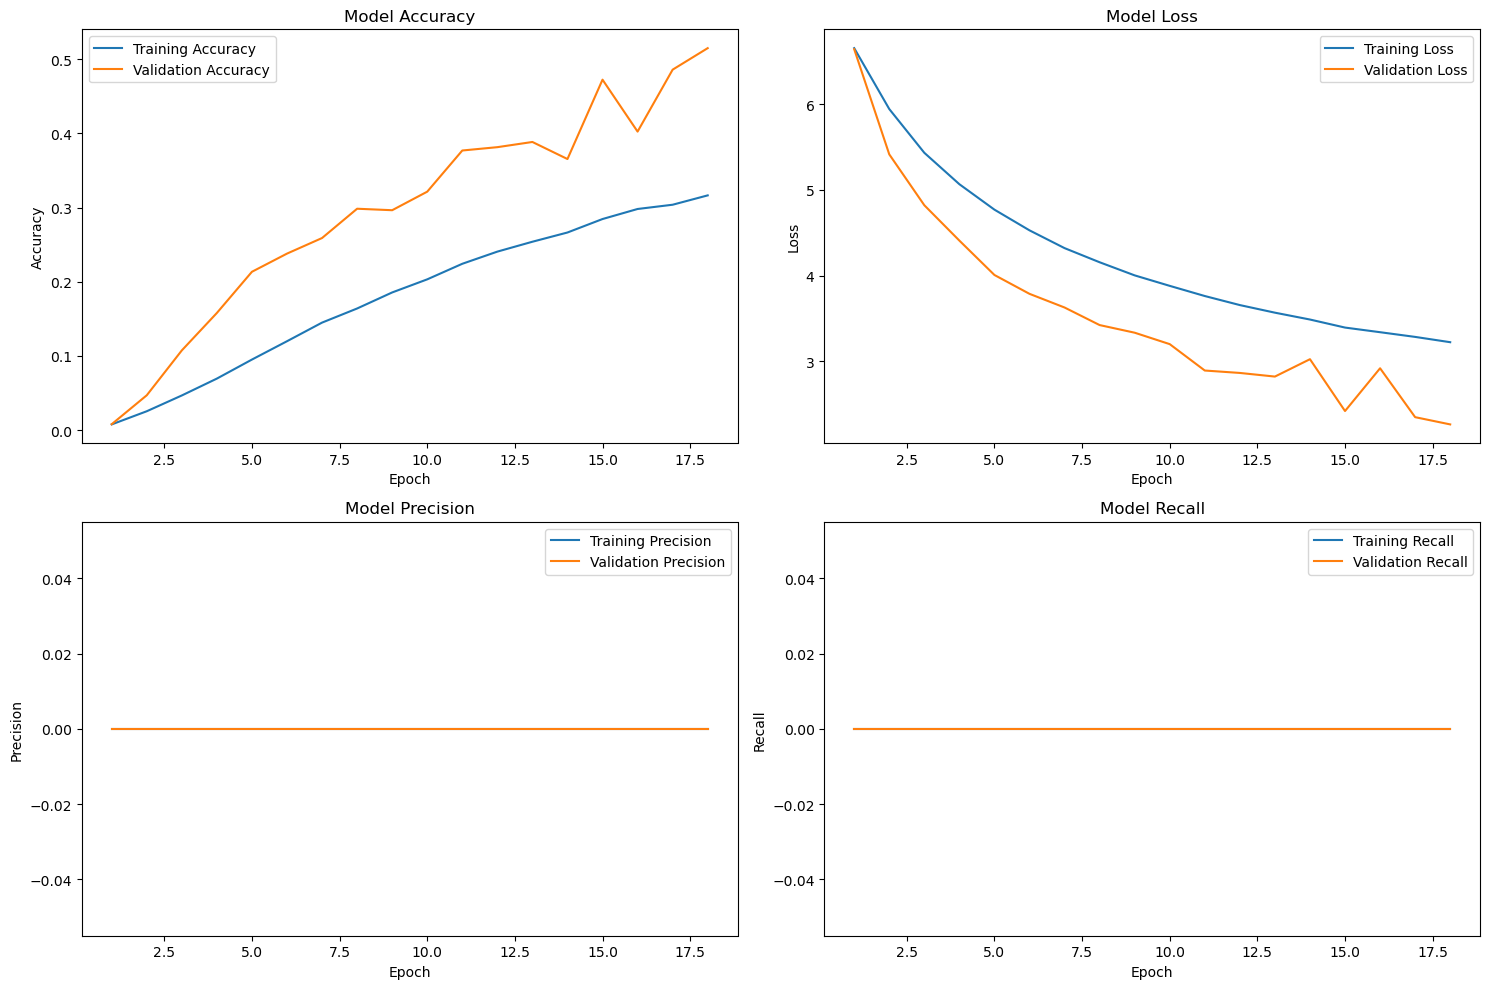

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 537s 294ms/step - accuracy: 0.3187 - loss: 3.2079 - precision_6: 0.7229 - recall_6: 0.0933 - val_accuracy: 0.5150 - val_loss: 2.2653 - val_precision_6: 0.7981 - val_recall_6: 0.2945 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.5149999856948853

Global Epoch 19/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.3248 - loss: 3.1686 - precision_6: 0.7320 - recall_6: 0.1019
Epoch 1: val_accuracy improved from 0.51500 to 0.53200, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.18.weights.h5



Global Epoch 19 Metrics:
Time taken: 9.00 minutes
Training Accuracy: 0.3251
Validation Accuracy: 0.5320
Training Loss: 3.1789
Validation Loss: 2.1848
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_19.h5


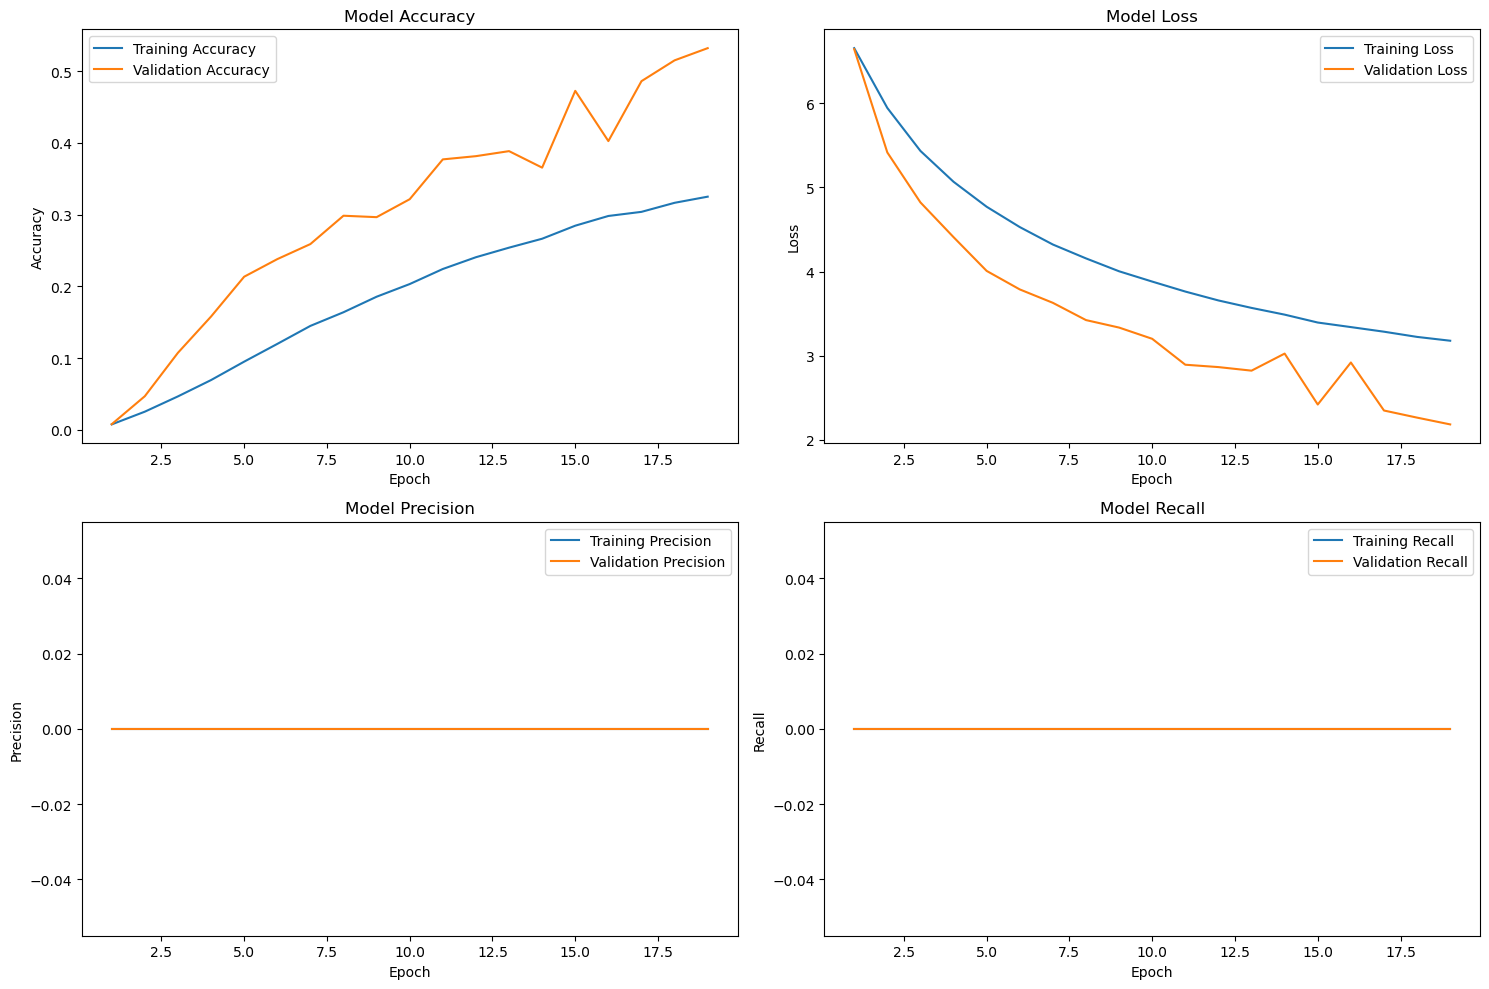

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 540s 296ms/step - accuracy: 0.3248 - loss: 3.1686 - precision_6: 0.7320 - recall_6: 0.1019 - val_accuracy: 0.5320 - val_loss: 2.1848 - val_precision_6: 0.8152 - val_recall_6: 0.3110 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.5320000052452087

Global Epoch 20/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.3353 - loss: 3.1280 - precision_6: 0.7268 - recall_6: 0.1116
Epoch 1: val_accuracy did not improve from 0.53200



Global Epoch 20 Metrics:
Time taken: 8.84 minutes
Training Accuracy: 0.3363
Validation Accuracy: 0.5040
Training Loss: 3.1257
Validation Loss: 2.2900
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_20.h5


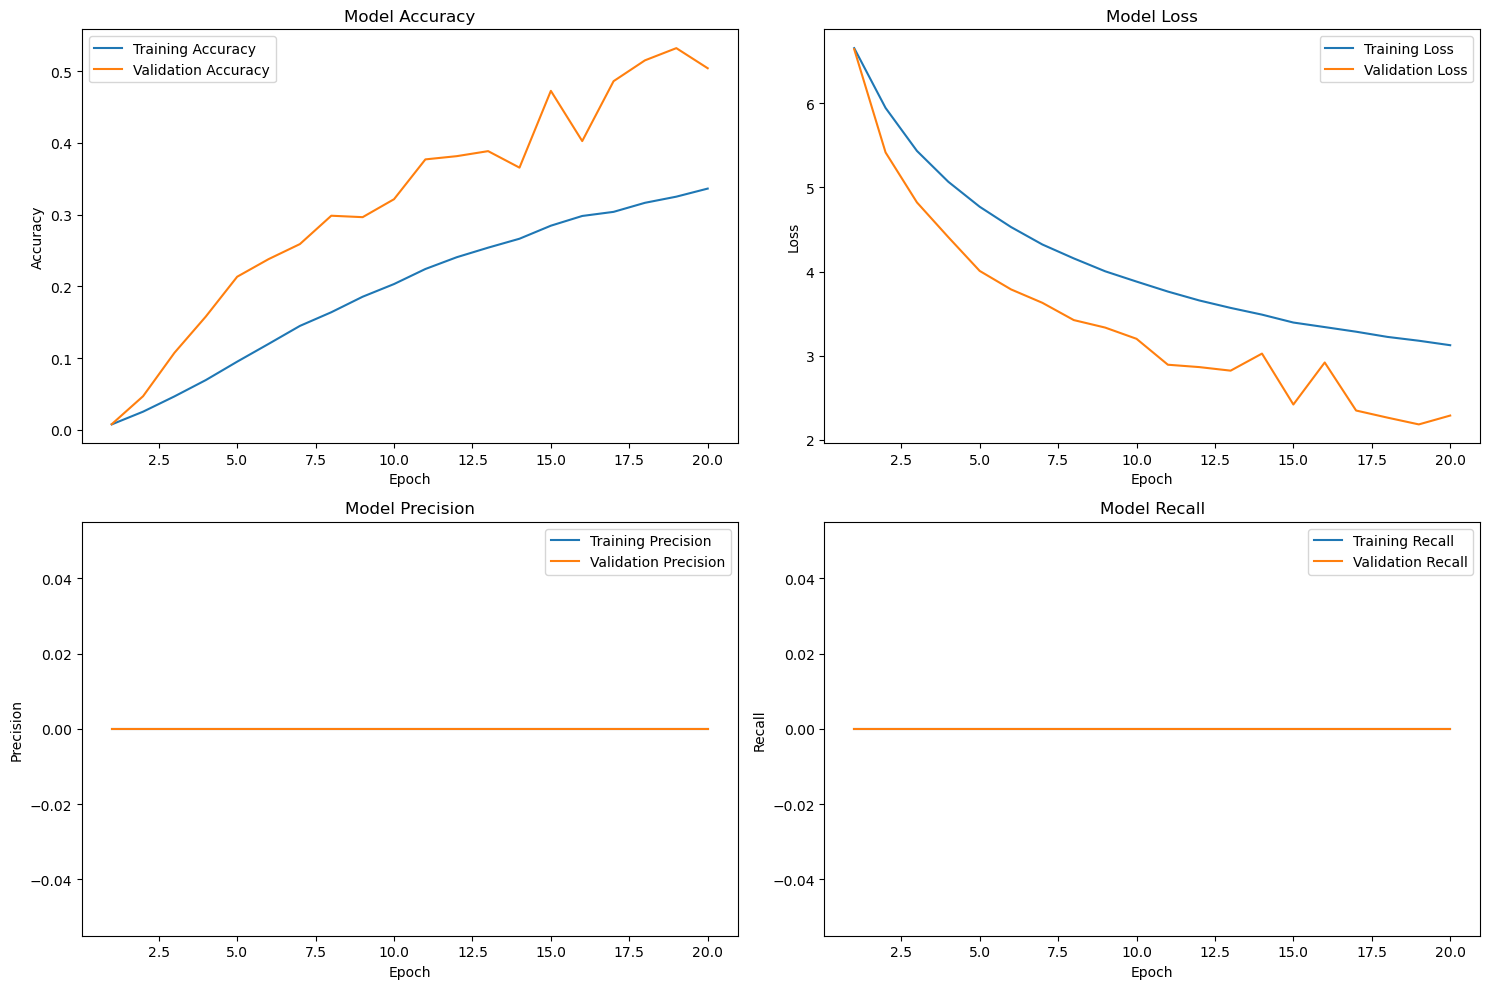

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 531s 291ms/step - accuracy: 0.3353 - loss: 3.1280 - precision_6: 0.7268 - recall_6: 0.1116 - val_accuracy: 0.5040 - val_loss: 2.2900 - val_precision_6: 0.7982 - val_recall_6: 0.3045 - learning_rate: 1.0000e-04

Global Epoch 21/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3477 - loss: 3.0761 - precision_6: 0.7386 - recall_6: 0.1214
Epoch 1: val_accuracy improved from 0.53200 to 0.54300, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.14.weights.h5



Global Epoch 21 Metrics:
Time taken: 8.93 minutes
Training Accuracy: 0.3455
Validation Accuracy: 0.5430
Training Loss: 3.0792
Validation Loss: 2.1356
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_21.h5


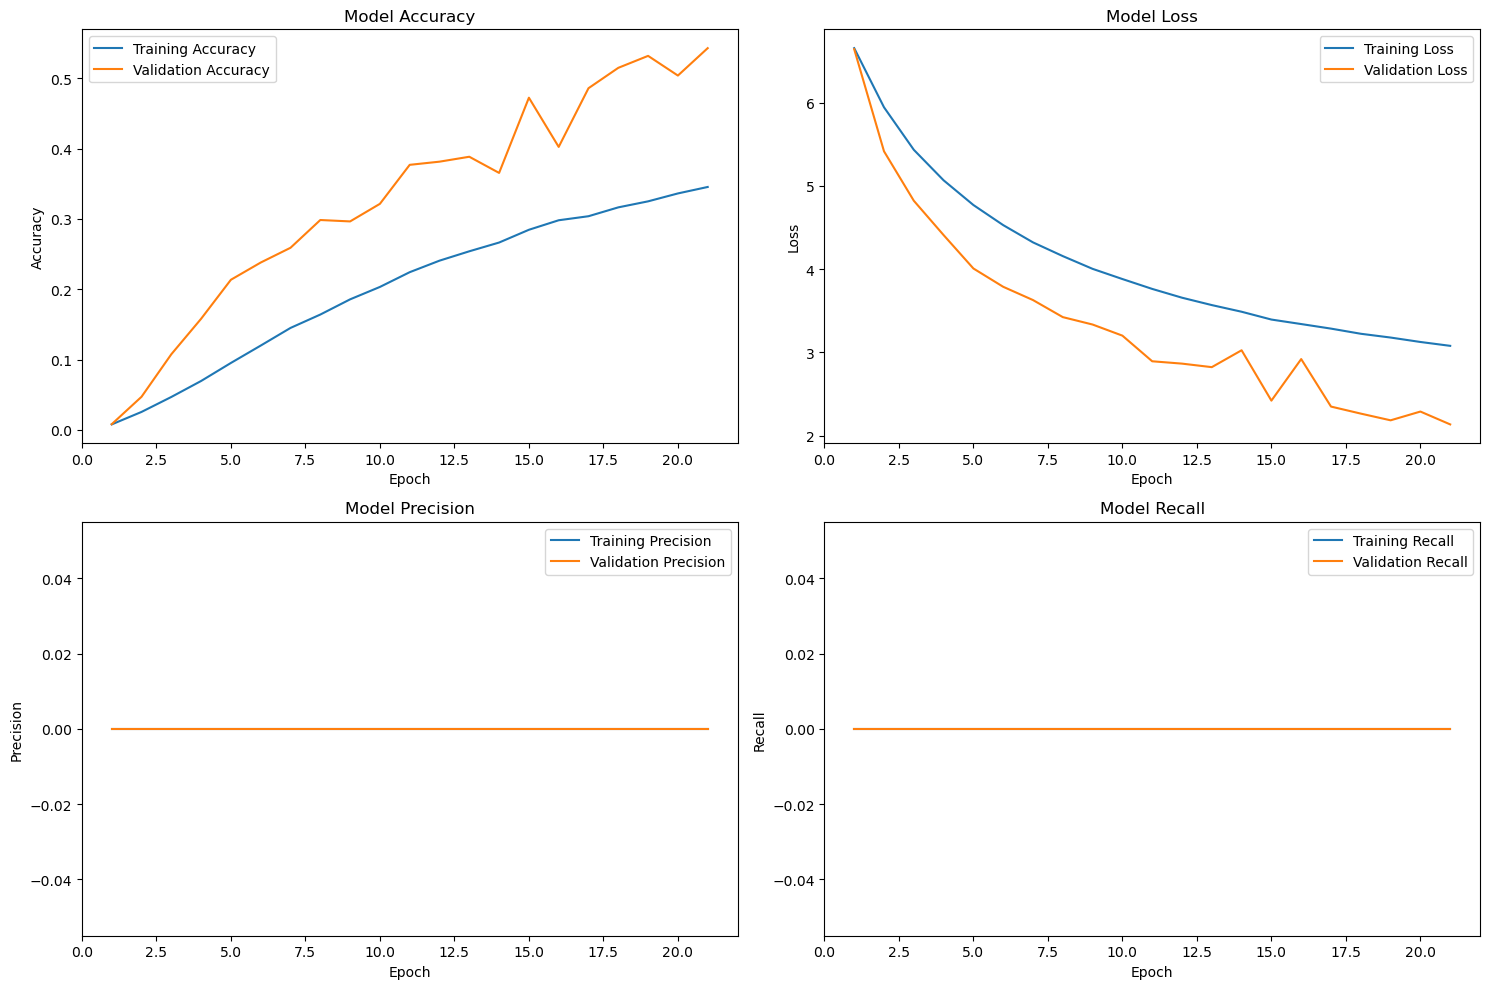

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 536s 294ms/step - accuracy: 0.3477 - loss: 3.0761 - precision_6: 0.7386 - recall_6: 0.1214 - val_accuracy: 0.5430 - val_loss: 2.1356 - val_precision_6: 0.8060 - val_recall_6: 0.3490 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.5429999828338623

Global Epoch 22/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.3548 - loss: 3.0450 - precision_6: 0.7425 - recall_6: 0.1286
Epoch 1: val_accuracy improved from 0.54300 to 0.55100, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-2.09.weights.h5



Global Epoch 22 Metrics:
Time taken: 8.92 minutes
Training Accuracy: 0.3565
Validation Accuracy: 0.5510
Training Loss: 3.0339
Validation Loss: 2.0863
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_22.h5


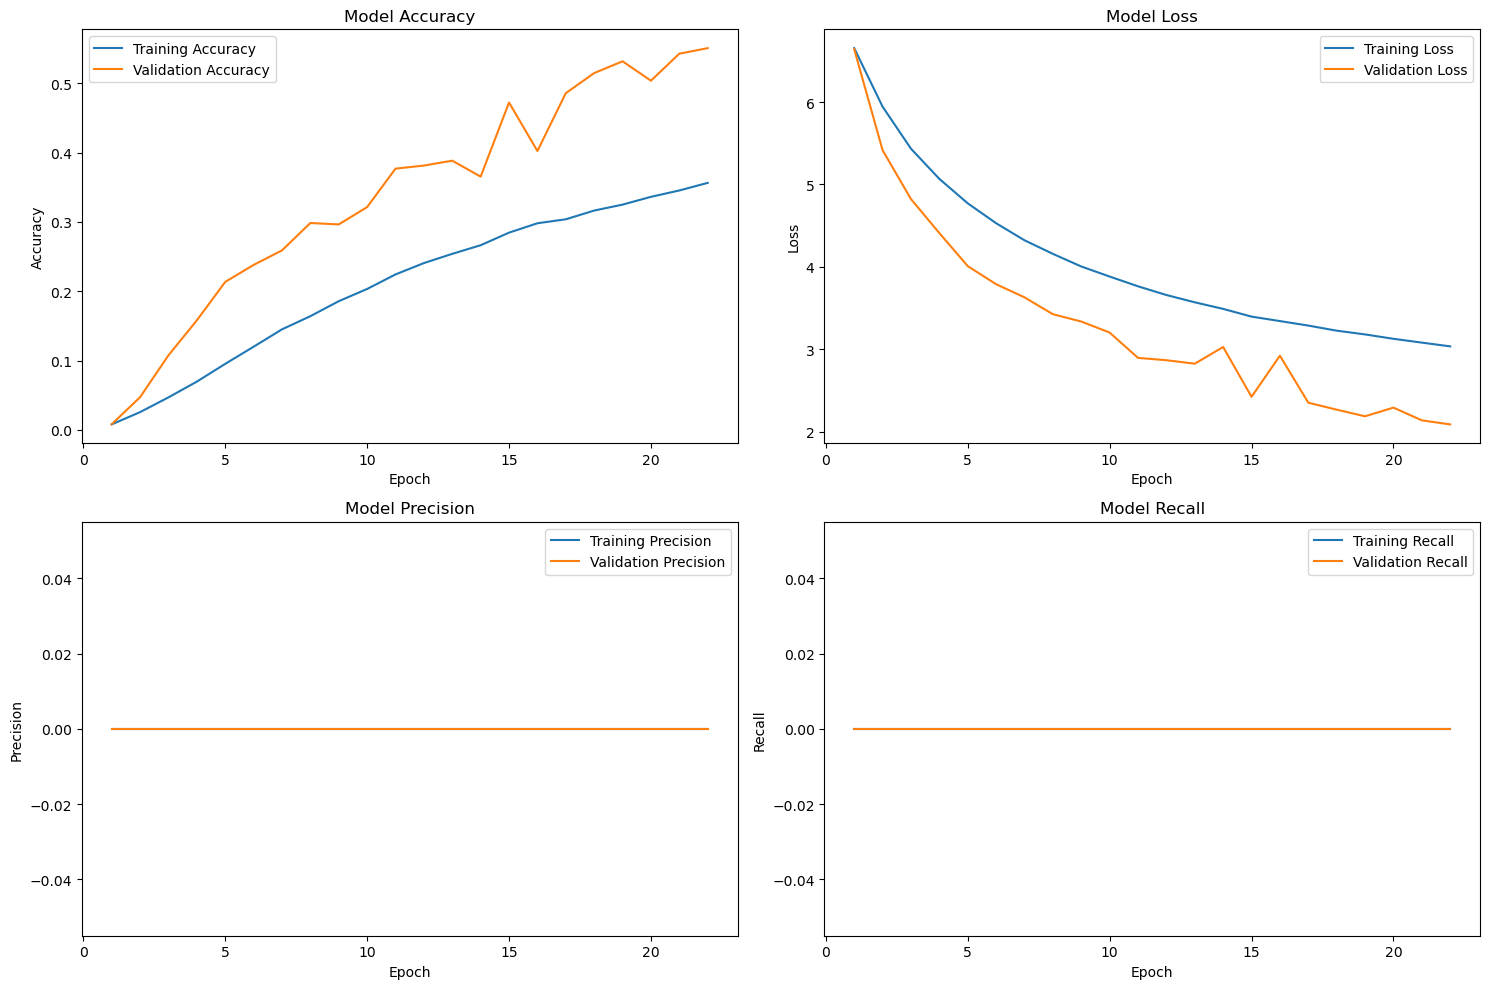

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.3548 - loss: 3.0450 - precision_6: 0.7425 - recall_6: 0.1286 - val_accuracy: 0.5510 - val_loss: 2.0863 - val_precision_6: 0.8243 - val_recall_6: 0.3495 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.5509999990463257

Global Epoch 23/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3645 - loss: 2.9802 - precision_6: 0.7500 - recall_6: 0.1395
Epoch 1: val_accuracy did not improve from 0.55100



Global Epoch 23 Metrics:
Time taken: 8.89 minutes
Training Accuracy: 0.3641
Validation Accuracy: 0.5380
Training Loss: 2.9867
Validation Loss: 2.0836
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_23.h5


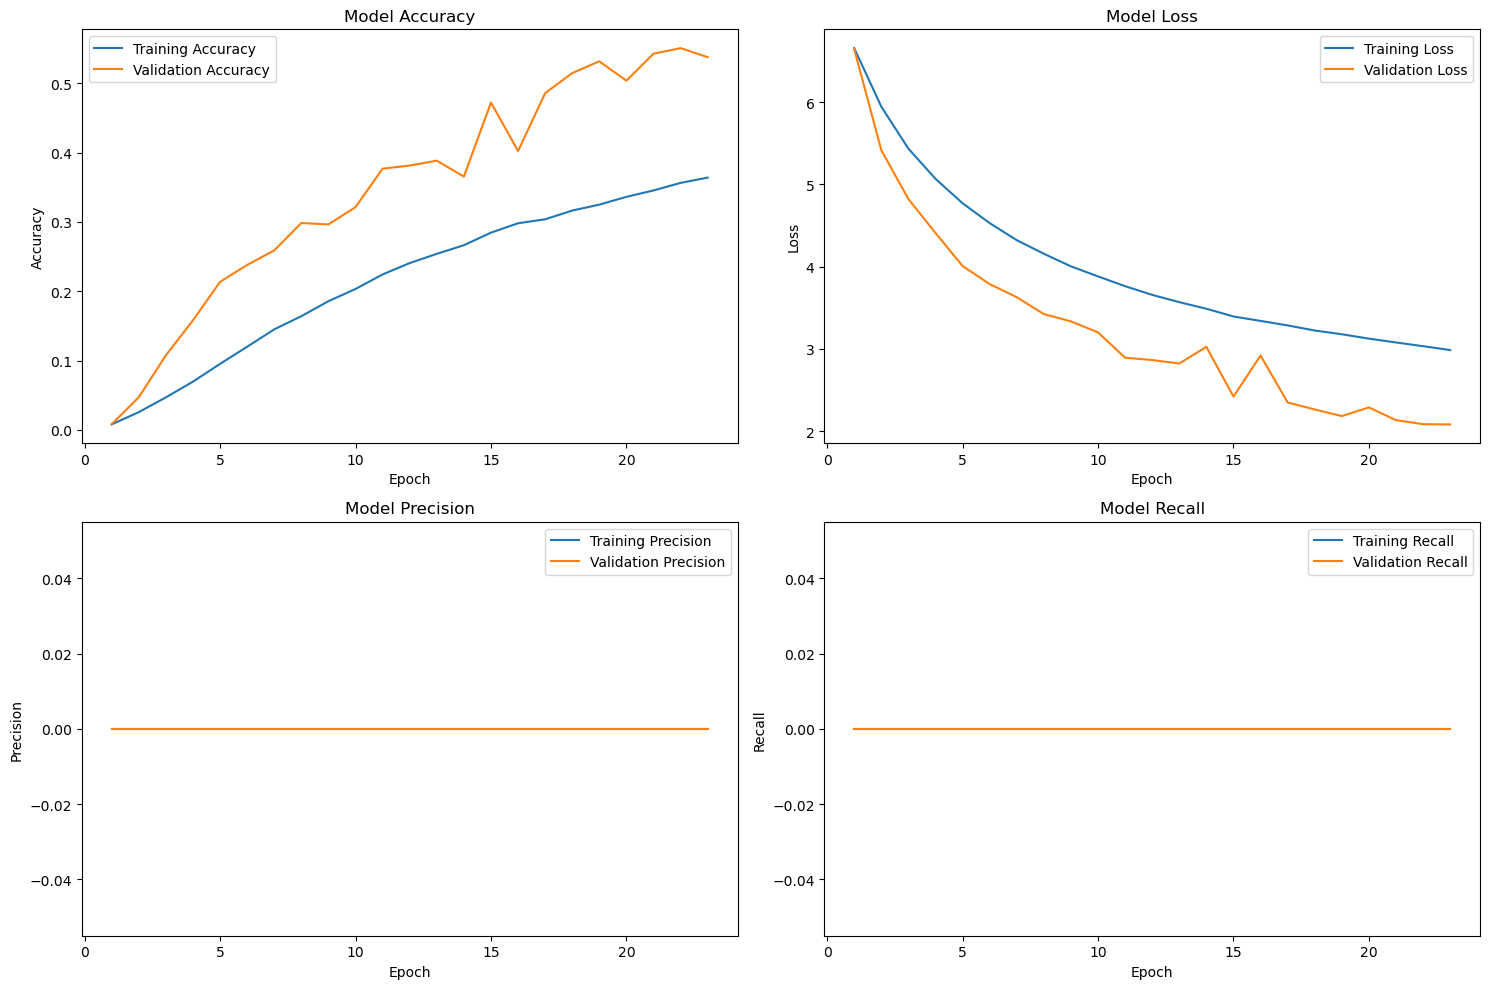

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 534s 293ms/step - accuracy: 0.3645 - loss: 2.9802 - precision_6: 0.7500 - recall_6: 0.1395 - val_accuracy: 0.5380 - val_loss: 2.0836 - val_precision_6: 0.7785 - val_recall_6: 0.3655 - learning_rate: 1.0000e-04

Global Epoch 24/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.3671 - loss: 2.9699 - precision_6: 0.7443 - recall_6: 0.1430
Epoch 1: val_accuracy did not improve from 0.55100



Global Epoch 24 Metrics:
Time taken: 8.92 minutes
Training Accuracy: 0.3701
Validation Accuracy: 0.5300
Training Loss: 2.9601
Validation Loss: 2.1539
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_24.h5


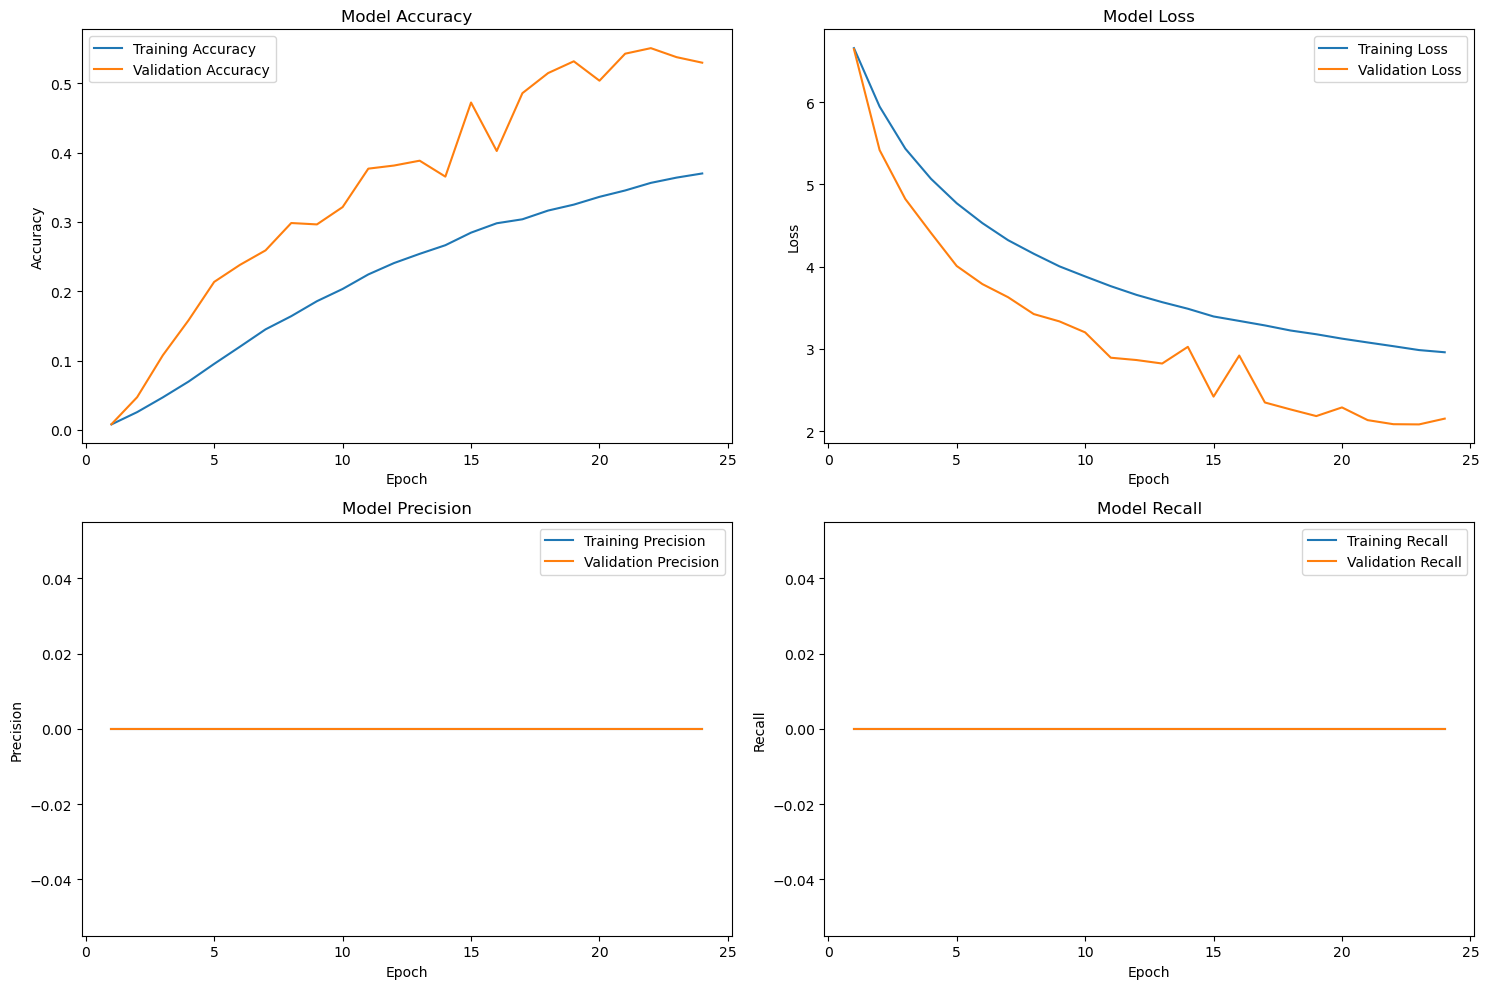

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 536s 293ms/step - accuracy: 0.3671 - loss: 2.9699 - precision_6: 0.7443 - recall_6: 0.1430 - val_accuracy: 0.5300 - val_loss: 2.1539 - val_precision_6: 0.7806 - val_recall_6: 0.3575 - learning_rate: 1.0000e-04

Global Epoch 25/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.3751 - loss: 2.9268 - precision_6: 0.7458 - recall_6: 0.1513
Epoch 1: val_accuracy improved from 0.55100 to 0.57700, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-1.97.weights.h5



Global Epoch 25 Metrics:
Time taken: 8.93 minutes
Training Accuracy: 0.3771
Validation Accuracy: 0.5770
Training Loss: 2.9180
Validation Loss: 1.9728
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_25.h5


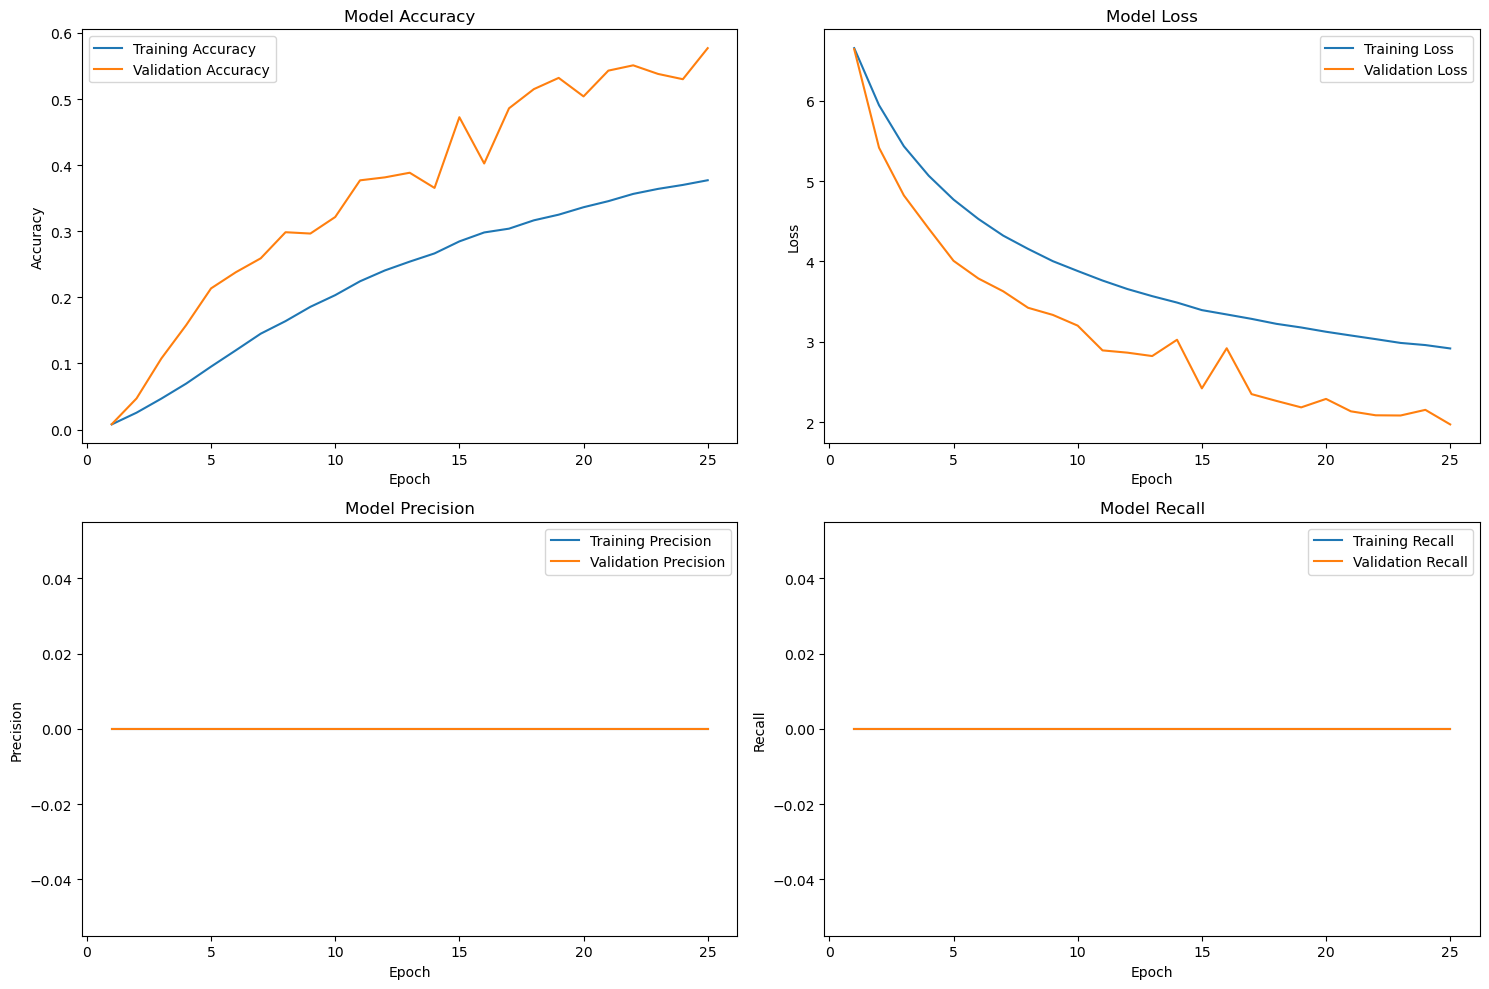

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 536s 294ms/step - accuracy: 0.3751 - loss: 2.9268 - precision_6: 0.7458 - recall_6: 0.1513 - val_accuracy: 0.5770 - val_loss: 1.9728 - val_precision_6: 0.8237 - val_recall_6: 0.3970 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.5770000219345093

Global Epoch 26/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3854 - loss: 2.8826 - precision_6: 0.7530 - recall_6: 0.1593
Epoch 1: val_accuracy did not improve from 0.57700



Global Epoch 26 Metrics:
Time taken: 8.97 minutes
Training Accuracy: 0.3858
Validation Accuracy: 0.5430
Training Loss: 2.8847
Validation Loss: 2.0934
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_26.h5


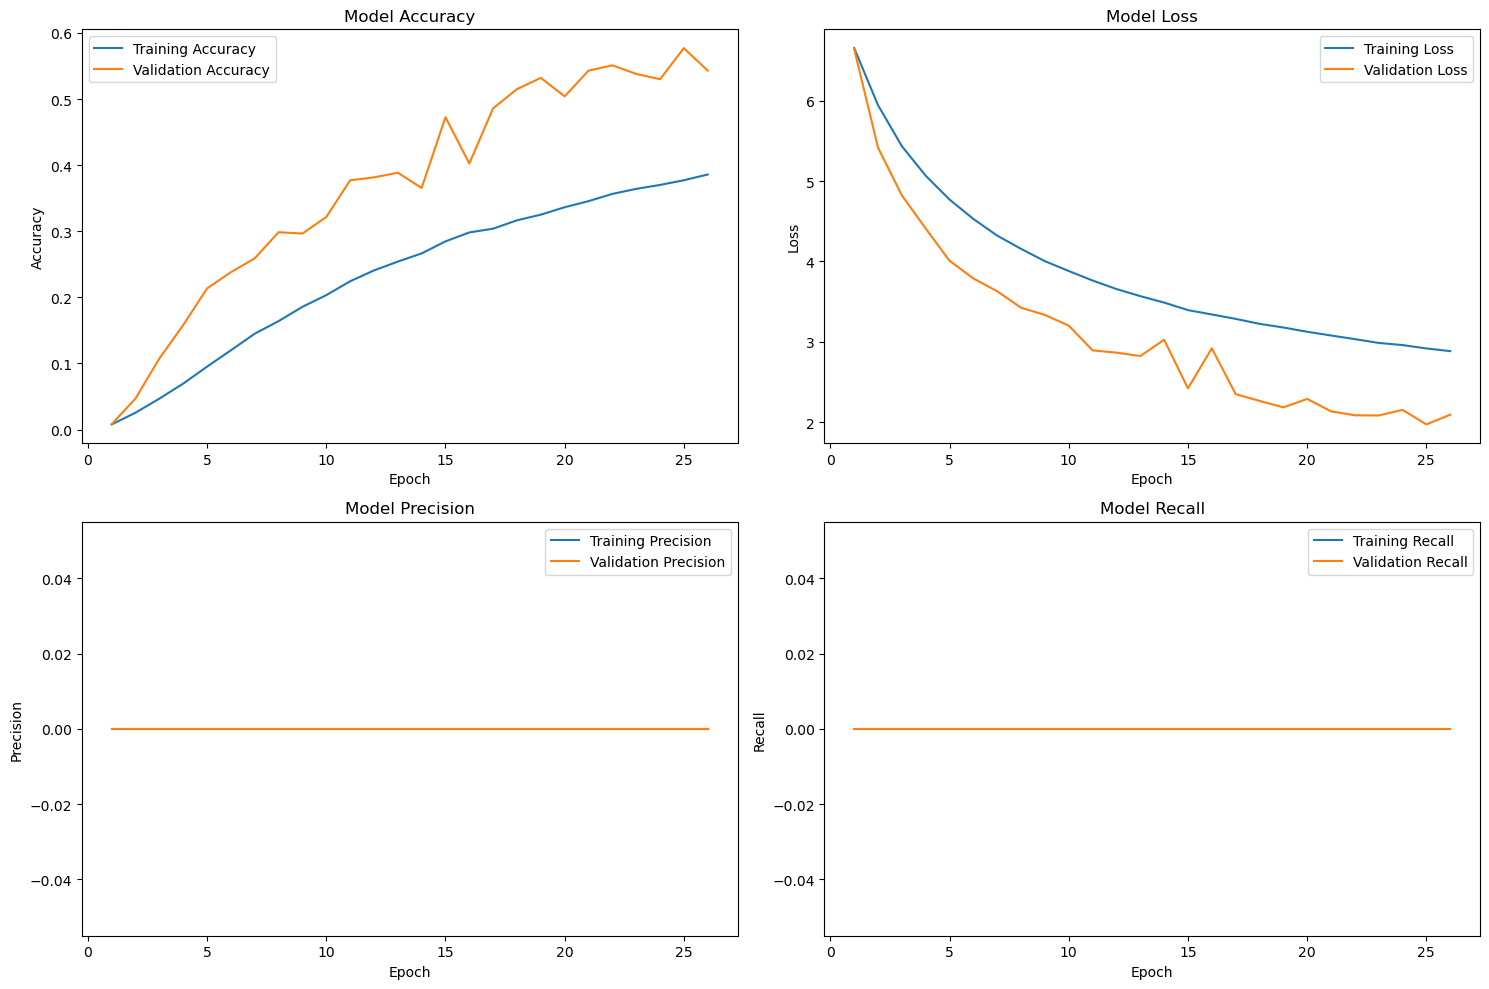

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 538s 295ms/step - accuracy: 0.3854 - loss: 2.8826 - precision_6: 0.7530 - recall_6: 0.1593 - val_accuracy: 0.5430 - val_loss: 2.0934 - val_precision_6: 0.7752 - val_recall_6: 0.3810 - learning_rate: 1.0000e-04

Global Epoch 27/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3915 - loss: 2.8433 - precision_6: 0.7436 - recall_6: 0.1657
Epoch 1: val_accuracy did not improve from 0.57700



Global Epoch 27 Metrics:
Time taken: 8.97 minutes
Training Accuracy: 0.3930
Validation Accuracy: 0.5550
Training Loss: 2.8443
Validation Loss: 2.0163
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_27.h5


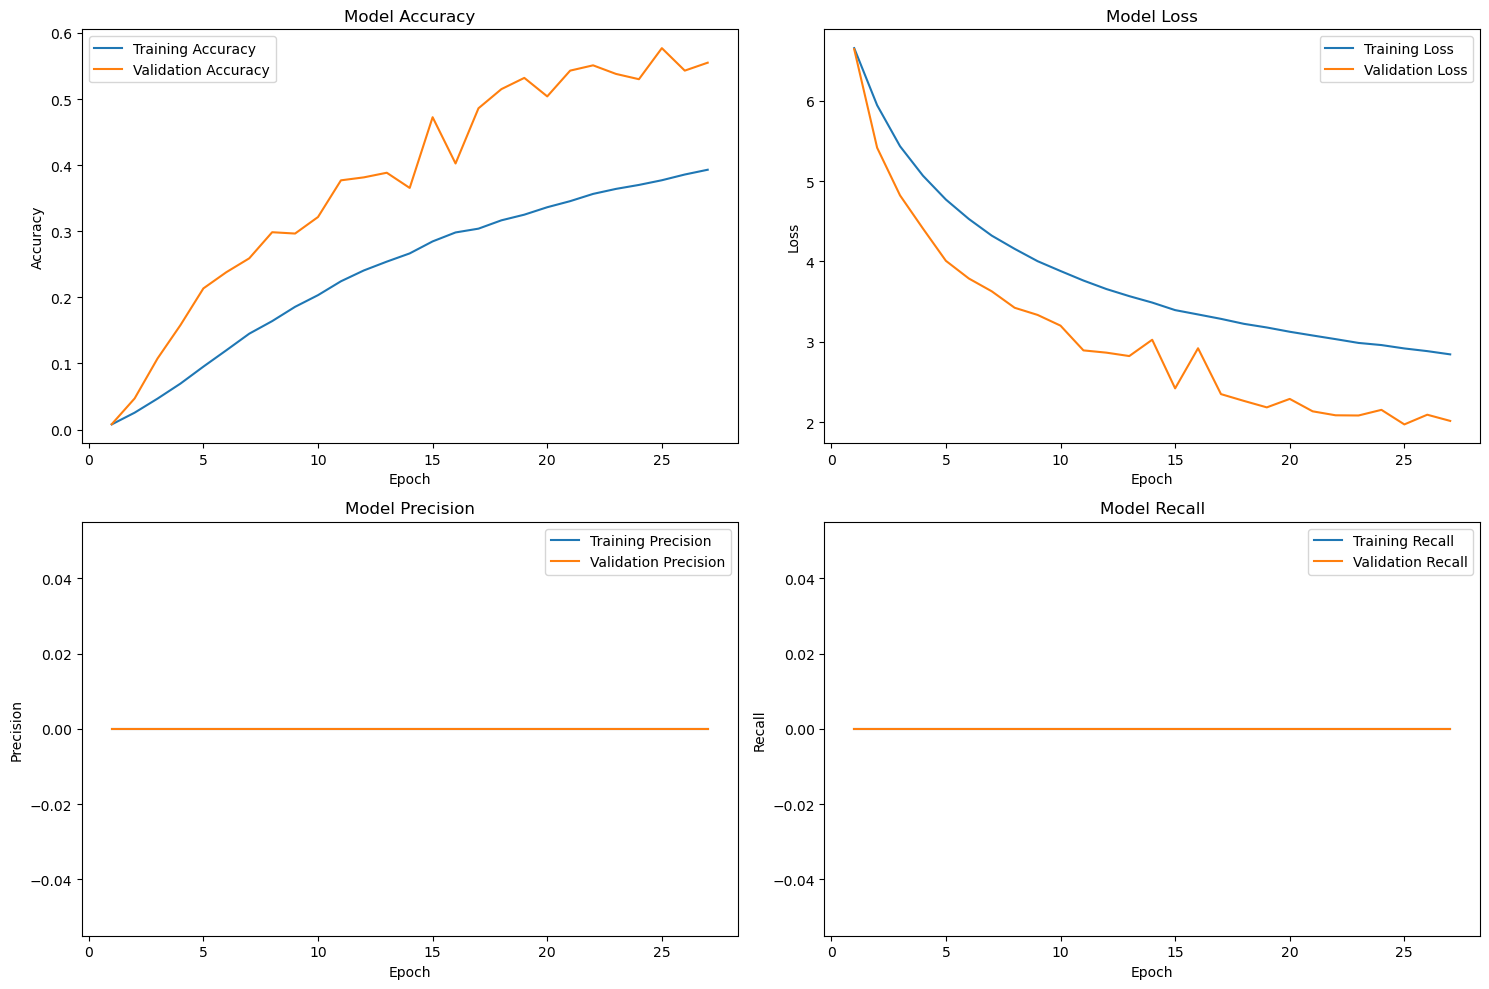

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 539s 295ms/step - accuracy: 0.3915 - loss: 2.8433 - precision_6: 0.7436 - recall_6: 0.1657 - val_accuracy: 0.5550 - val_loss: 2.0163 - val_precision_6: 0.8028 - val_recall_6: 0.3970 - learning_rate: 1.0000e-04

Global Epoch 28/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3977 - loss: 2.8109 - precision_6: 0.7532 - recall_6: 0.1770
Epoch 1: val_accuracy improved from 0.57700 to 0.63050, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-1.74.weights.h5



Global Epoch 28 Metrics:
Time taken: 8.98 minutes
Training Accuracy: 0.3963
Validation Accuracy: 0.6305
Training Loss: 2.8149
Validation Loss: 1.7409
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_28.h5


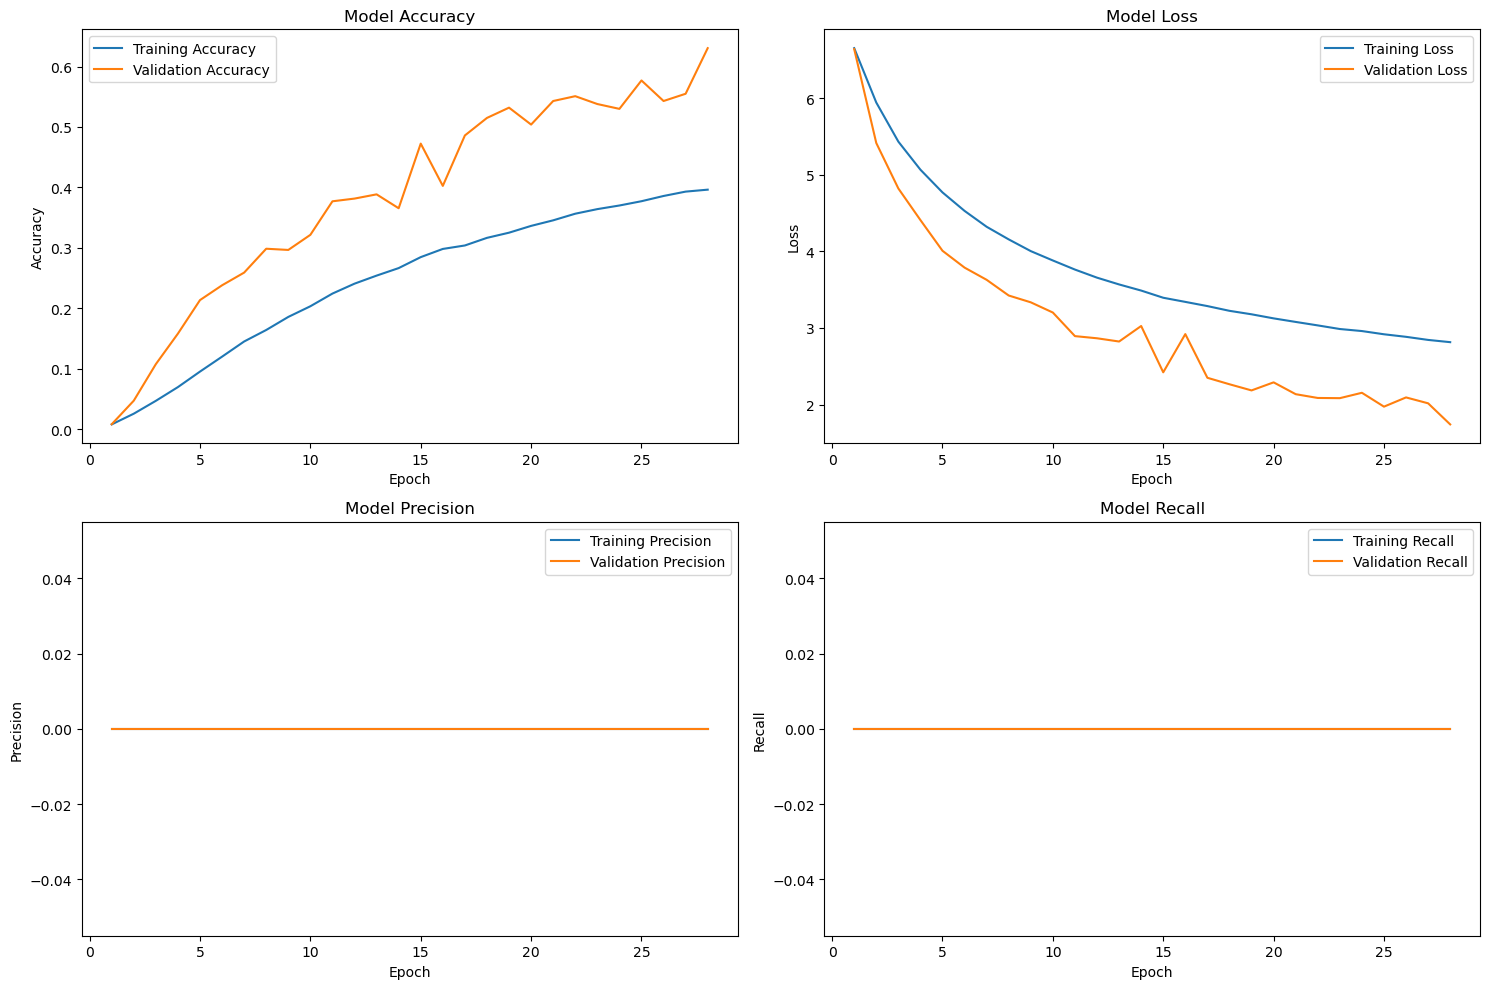

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 539s 295ms/step - accuracy: 0.3977 - loss: 2.8109 - precision_6: 0.7532 - recall_6: 0.1770 - val_accuracy: 0.6305 - val_loss: 1.7409 - val_precision_6: 0.8600 - val_recall_6: 0.4360 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.6305000185966492

Global Epoch 29/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4078 - loss: 2.7756 - precision_6: 0.7551 - recall_6: 0.1813
Epoch 1: val_accuracy did not improve from 0.63050



Global Epoch 29 Metrics:
Time taken: 9.14 minutes
Training Accuracy: 0.4053
Validation Accuracy: 0.5805
Training Loss: 2.7864
Validation Loss: 1.9910
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_29.h5


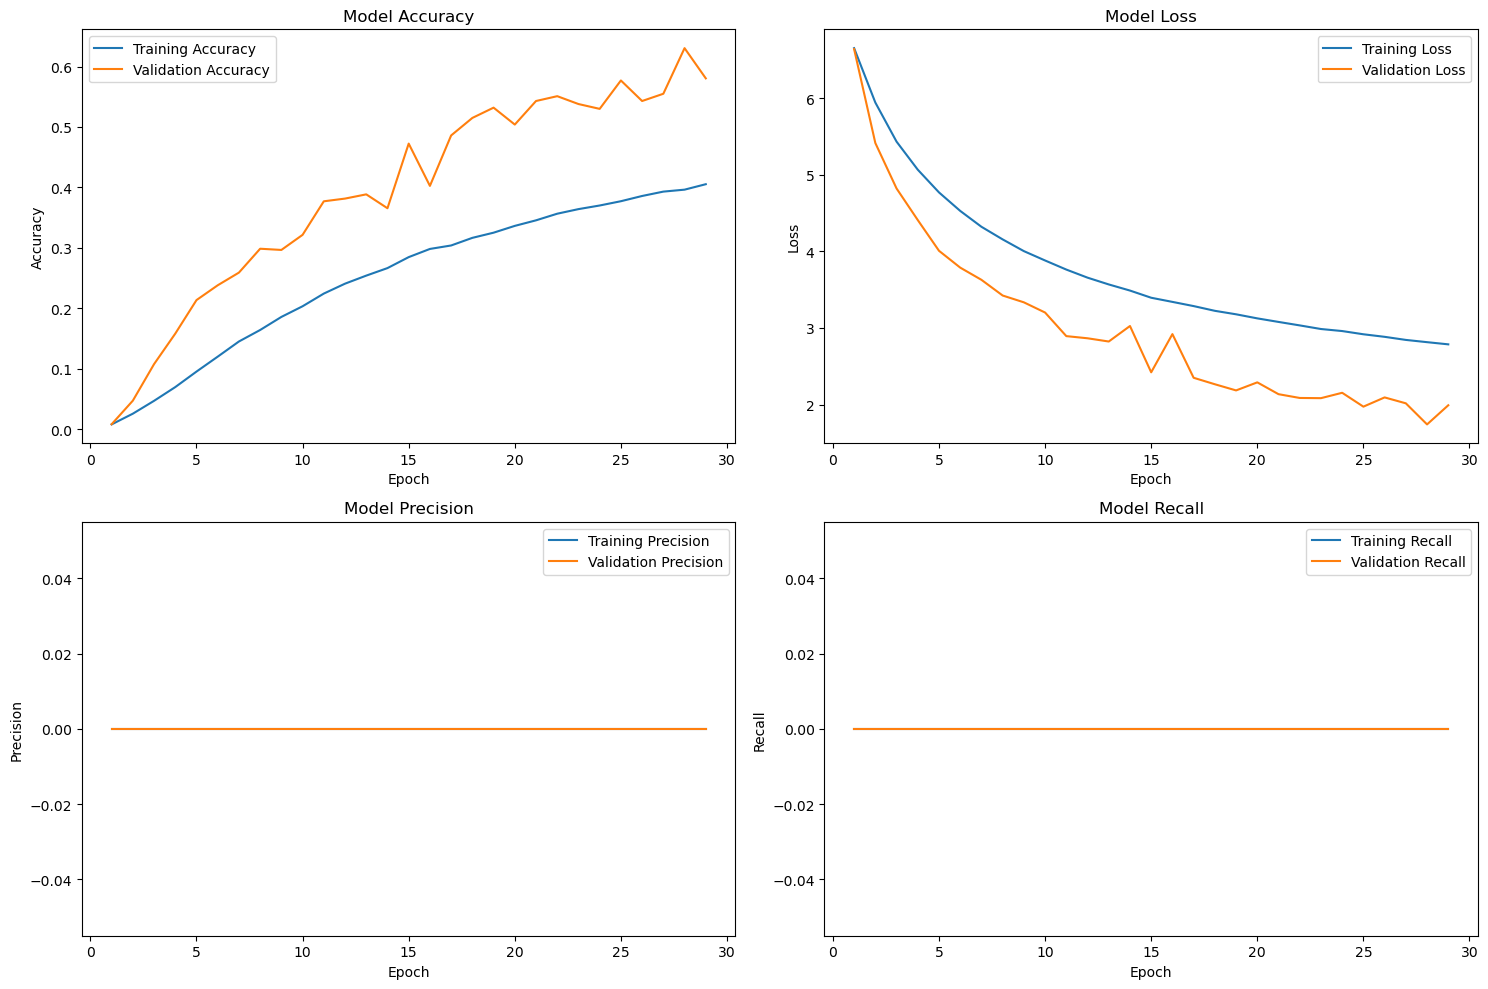

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 549s 301ms/step - accuracy: 0.4078 - loss: 2.7756 - precision_6: 0.7551 - recall_6: 0.1813 - val_accuracy: 0.5805 - val_loss: 1.9910 - val_precision_6: 0.8065 - val_recall_6: 0.4190 - learning_rate: 1.0000e-04

Global Epoch 30/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.4104 - loss: 2.7428 - precision_6: 0.7665 - recall_6: 0.1925
Epoch 1: val_accuracy did not improve from 0.63050



Global Epoch 30 Metrics:
Time taken: 9.02 minutes
Training Accuracy: 0.4134
Validation Accuracy: 0.6280
Training Loss: 2.7360
Validation Loss: 1.7928
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_30.h5


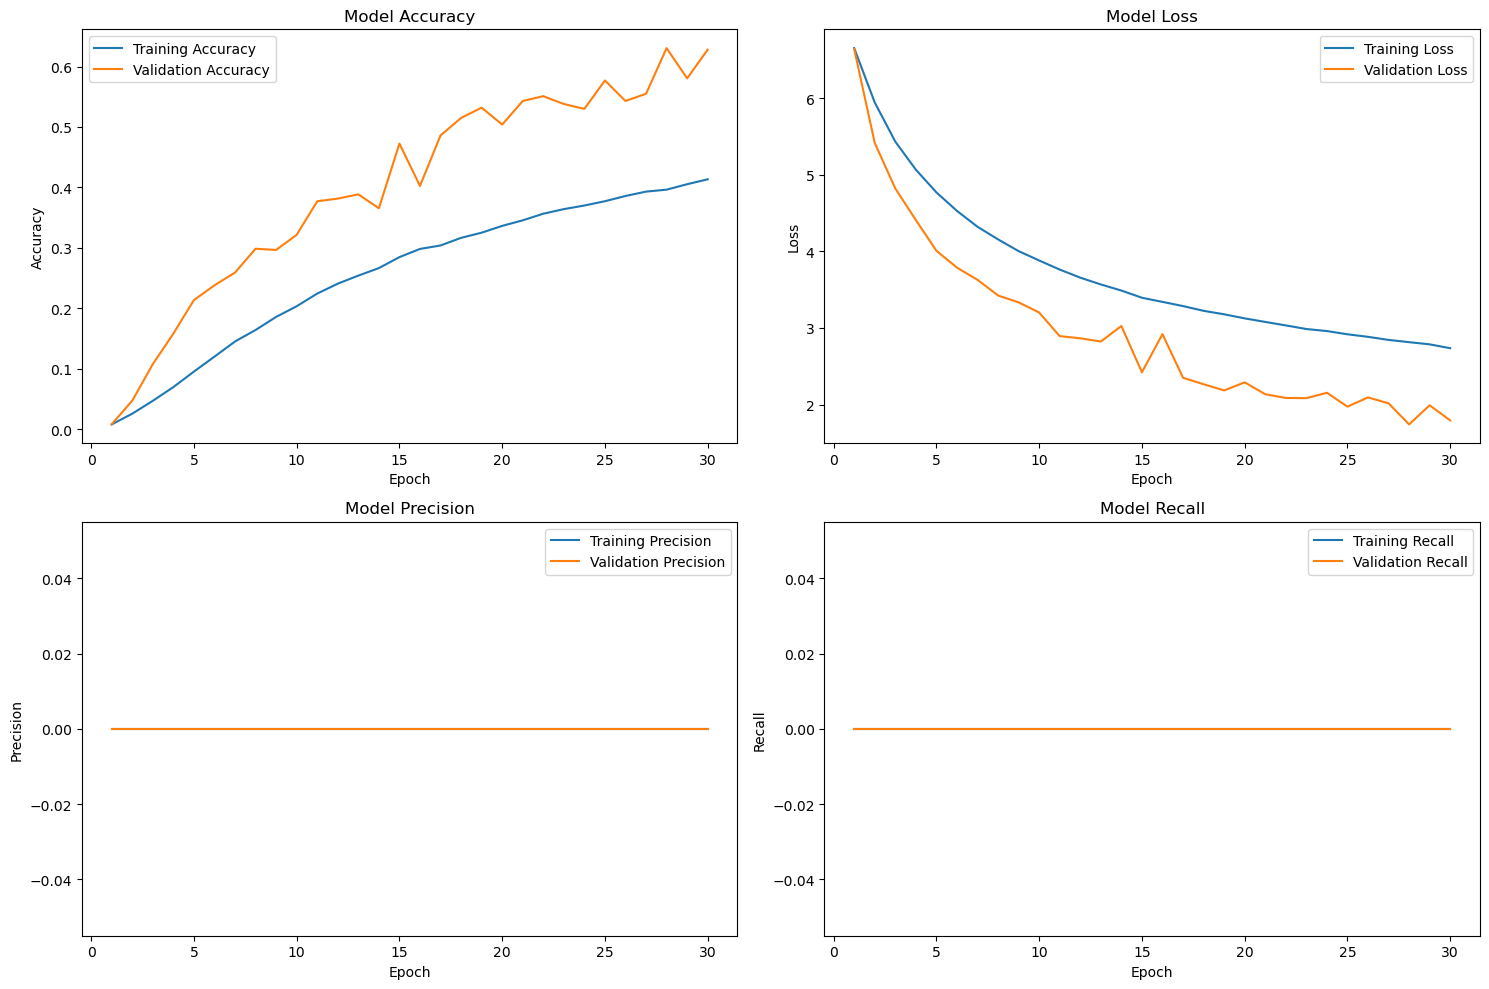

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 542s 297ms/step - accuracy: 0.4104 - loss: 2.7428 - precision_6: 0.7664 - recall_6: 0.1925 - val_accuracy: 0.6280 - val_loss: 1.7928 - val_precision_6: 0.8517 - val_recall_6: 0.4595 - learning_rate: 1.0000e-04

Global Epoch 31/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4171 - loss: 2.7174 - precision_6: 0.7625 - recall_6: 0.1980
Epoch 1: val_accuracy did not improve from 0.63050



Global Epoch 31 Metrics:
Time taken: 8.99 minutes
Training Accuracy: 0.4172
Validation Accuracy: 0.6275
Training Loss: 2.7244
Validation Loss: 1.7528
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_31.h5


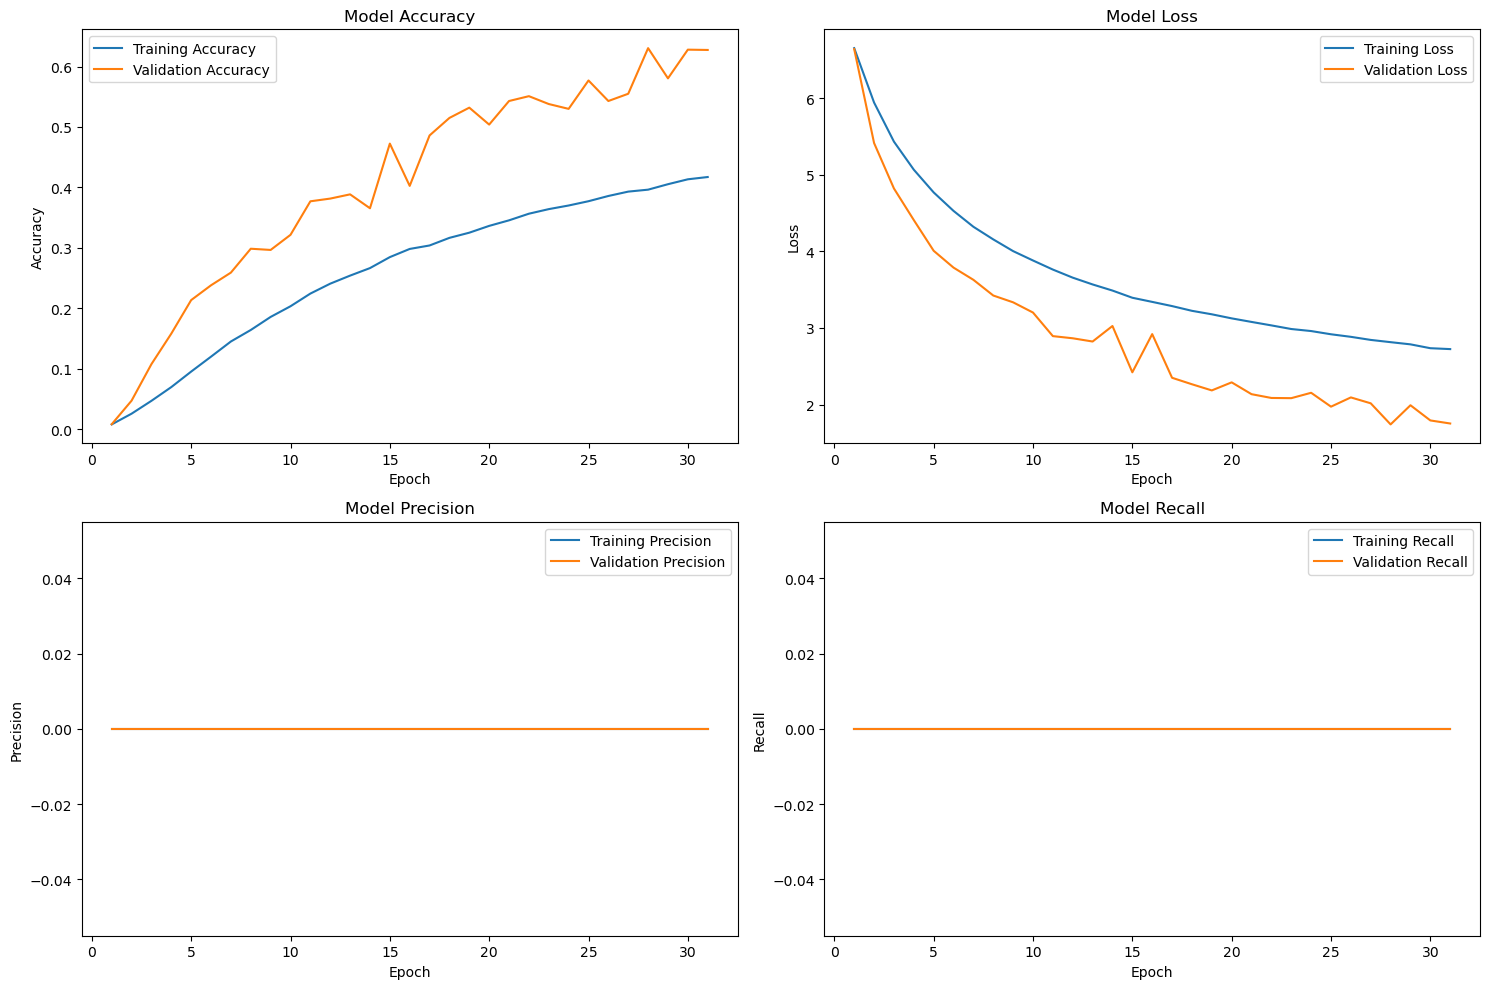

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 540s 296ms/step - accuracy: 0.4171 - loss: 2.7174 - precision_6: 0.7625 - recall_6: 0.1980 - val_accuracy: 0.6275 - val_loss: 1.7528 - val_precision_6: 0.8297 - val_recall_6: 0.4505 - learning_rate: 1.0000e-04

Global Epoch 32/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4316 - loss: 2.6706 - precision_6: 0.7714 - recall_6: 0.2087
Epoch 1: val_accuracy did not improve from 0.63050



Global Epoch 32 Metrics:
Time taken: 8.98 minutes
Training Accuracy: 0.4248
Validation Accuracy: 0.6115
Training Loss: 2.6881
Validation Loss: 1.8289
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_32.h5


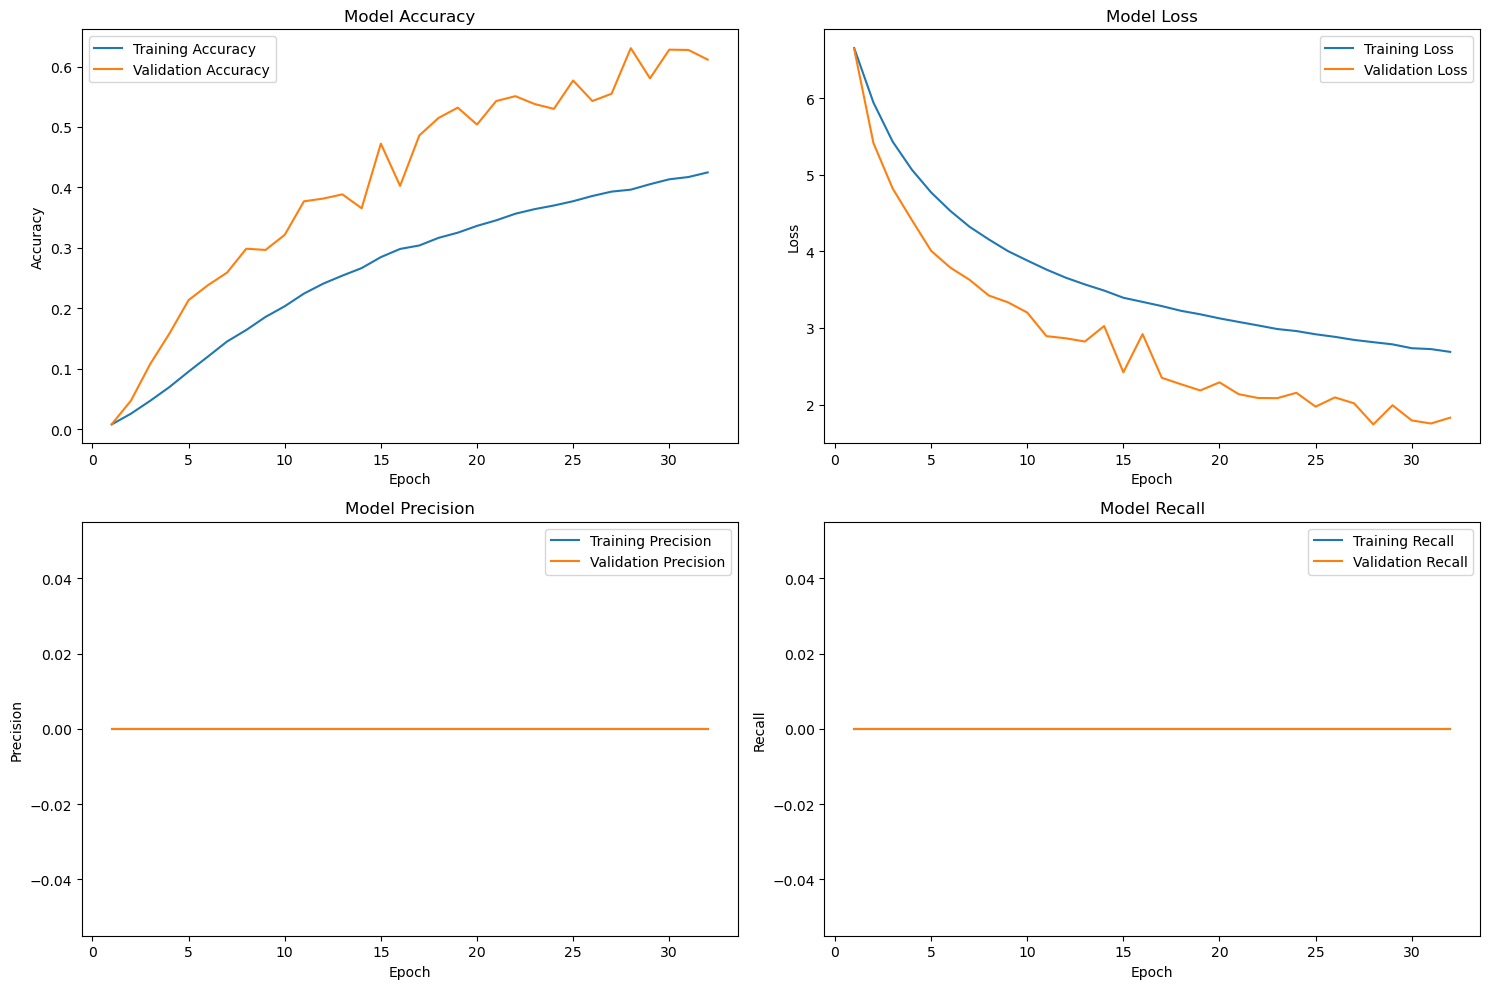

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 539s 295ms/step - accuracy: 0.4316 - loss: 2.6706 - precision_6: 0.7714 - recall_6: 0.2087 - val_accuracy: 0.6115 - val_loss: 1.8289 - val_precision_6: 0.8029 - val_recall_6: 0.4645 - learning_rate: 1.0000e-04

Global Epoch 33/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4301 - loss: 2.6702 - precision_6: 0.7644 - recall_6: 0.2151
Epoch 1: val_accuracy did not improve from 0.63050



Global Epoch 33 Metrics:
Time taken: 8.96 minutes
Training Accuracy: 0.4305
Validation Accuracy: 0.6180
Training Loss: 2.6662
Validation Loss: 1.8158
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_33.h5


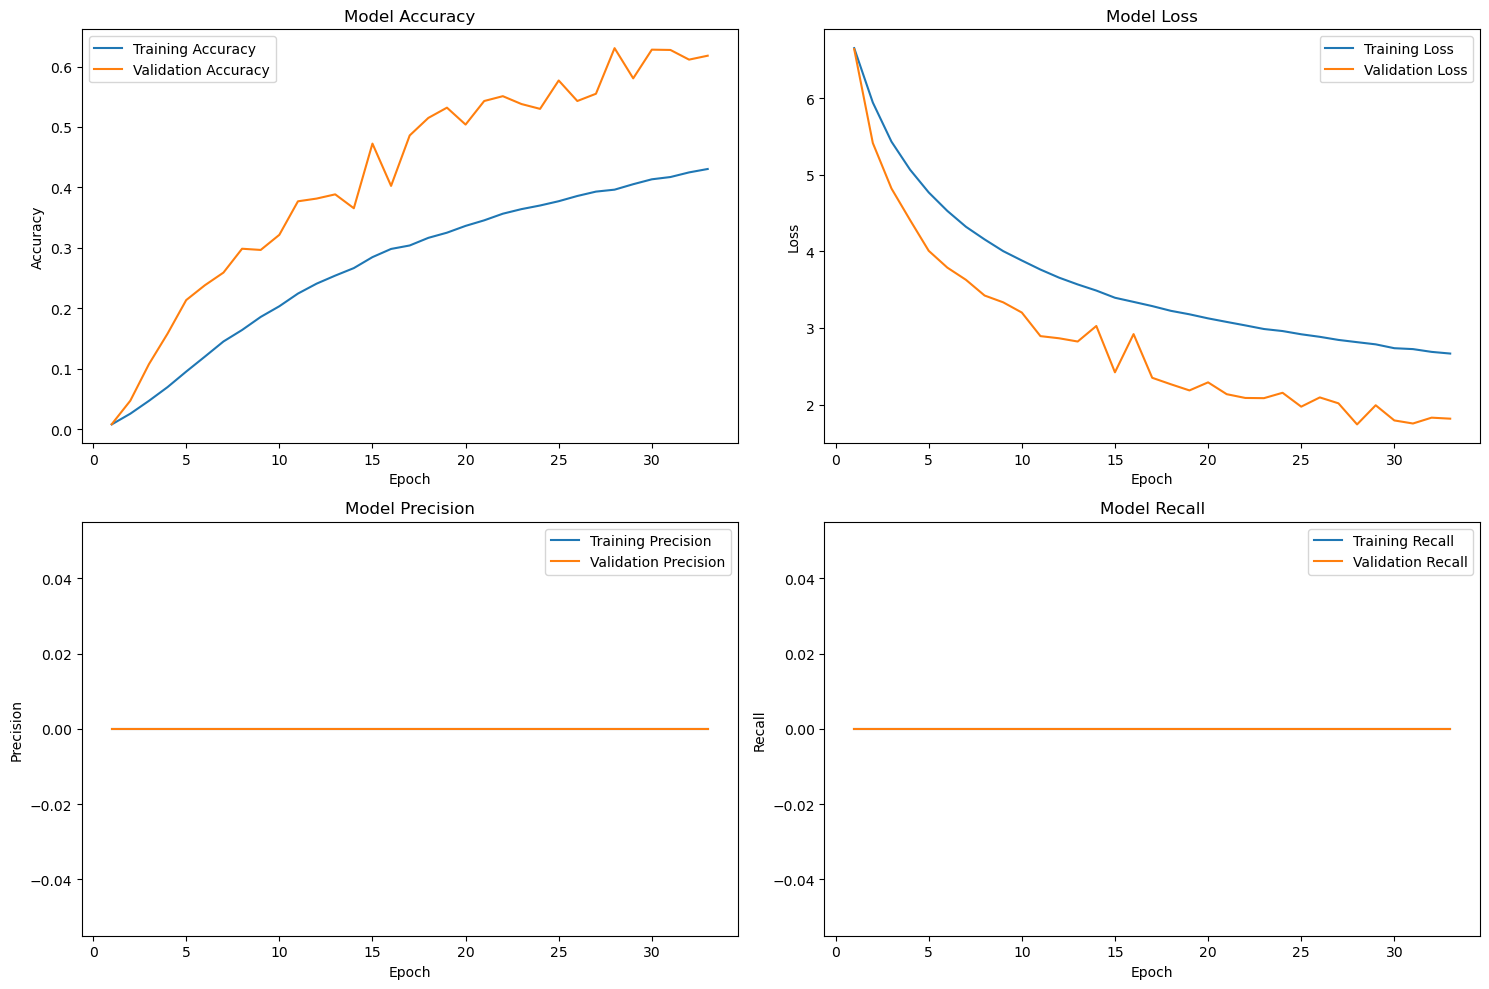

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 538s 295ms/step - accuracy: 0.4301 - loss: 2.6702 - precision_6: 0.7644 - recall_6: 0.2151 - val_accuracy: 0.6180 - val_loss: 1.8158 - val_precision_6: 0.8157 - val_recall_6: 0.4715 - learning_rate: 1.0000e-04

Global Epoch 34/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4378 - loss: 2.6165 - precision_6: 0.7656 - recall_6: 0.2163
Epoch 1: val_accuracy improved from 0.63050 to 0.63550, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-1.76.weights.h5



Global Epoch 34 Metrics:
Time taken: 8.93 minutes
Training Accuracy: 0.4354
Validation Accuracy: 0.6355
Training Loss: 2.6309
Validation Loss: 1.7599
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_34.h5


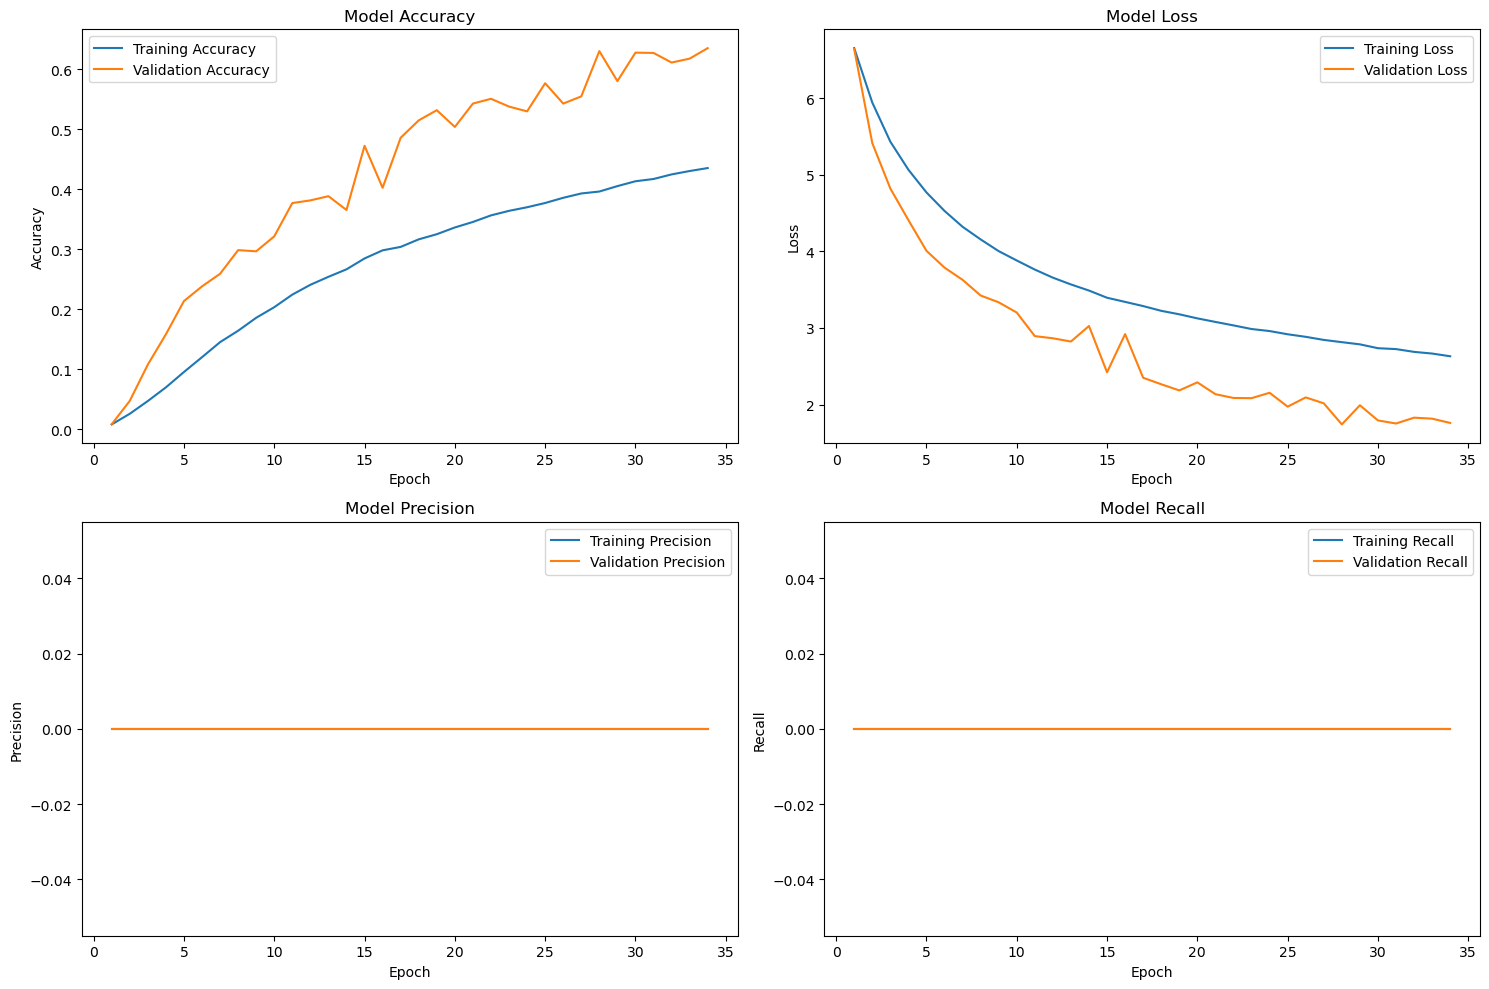

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 536s 294ms/step - accuracy: 0.4378 - loss: 2.6166 - precision_6: 0.7656 - recall_6: 0.2163 - val_accuracy: 0.6355 - val_loss: 1.7599 - val_precision_6: 0.8308 - val_recall_6: 0.4860 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.6355000138282776

Global Epoch 35/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4404 - loss: 2.5949 - precision_6: 0.7748 - recall_6: 0.2278
Epoch 1: val_accuracy did not improve from 0.63550



Global Epoch 35 Metrics:
Time taken: 8.92 minutes
Training Accuracy: 0.4404
Validation Accuracy: 0.6040
Training Loss: 2.6032
Validation Loss: 1.8997
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_35.h5


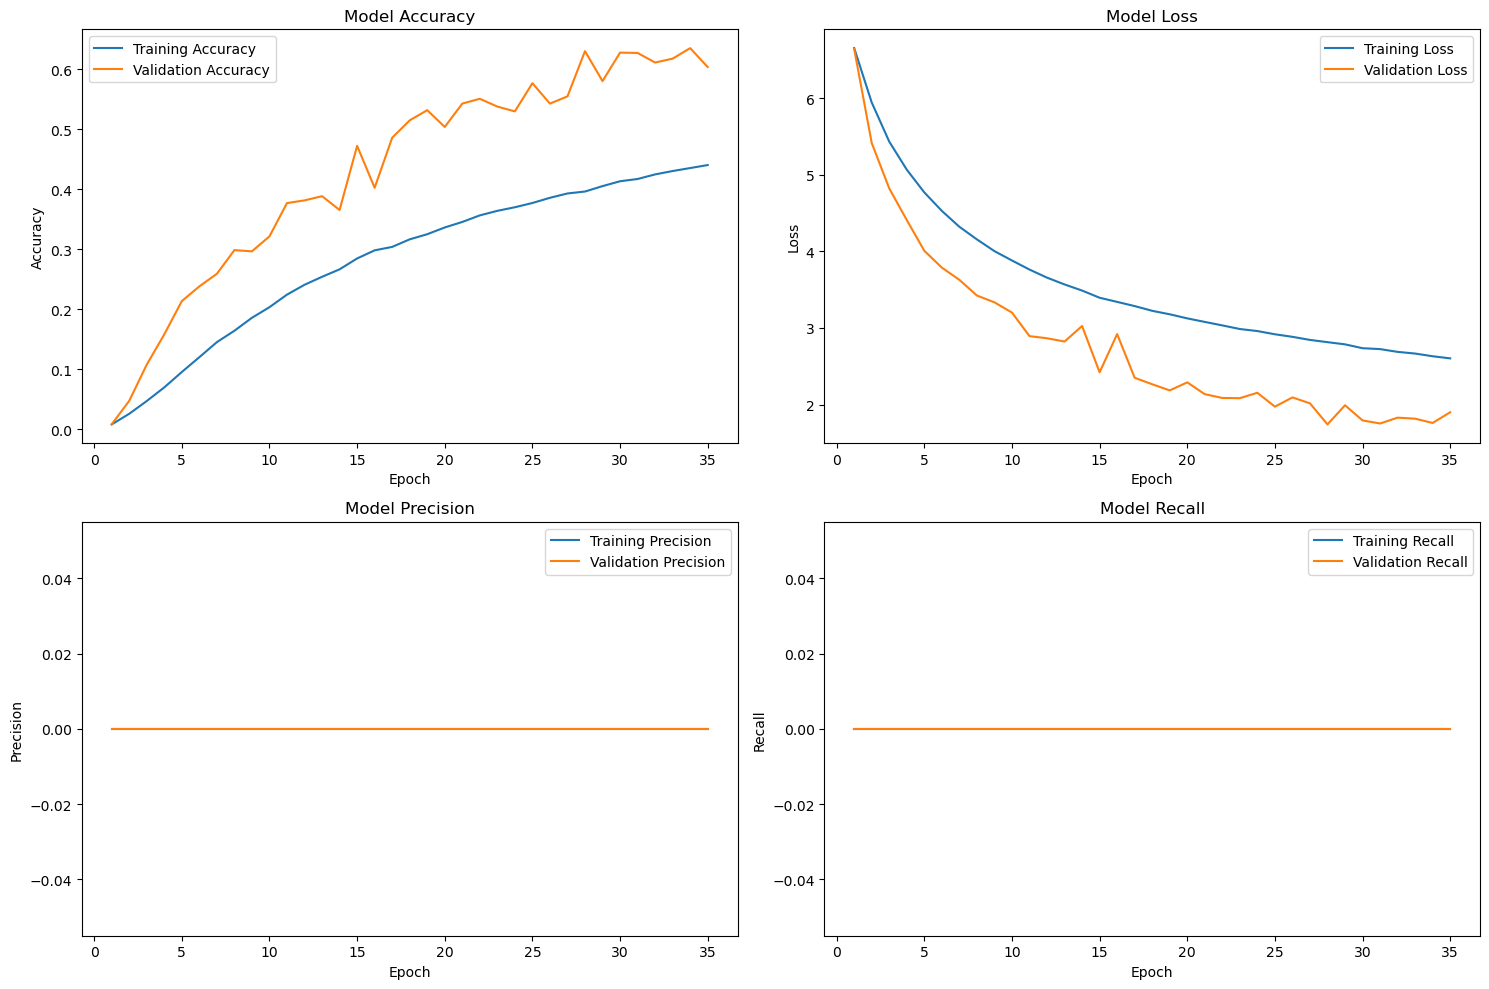

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 536s 294ms/step - accuracy: 0.4404 - loss: 2.5949 - precision_6: 0.7748 - recall_6: 0.2278 - val_accuracy: 0.6040 - val_loss: 1.8997 - val_precision_6: 0.7974 - val_recall_6: 0.4525 - learning_rate: 1.0000e-04

Global Epoch 36/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4482 - loss: 2.5657 - precision_6: 0.7759 - recall_6: 0.2360
Epoch 1: val_accuracy did not improve from 0.63550



Global Epoch 36 Metrics:
Time taken: 8.94 minutes
Training Accuracy: 0.4446
Validation Accuracy: 0.6270
Training Loss: 2.5870
Validation Loss: 1.7687
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_36.h5


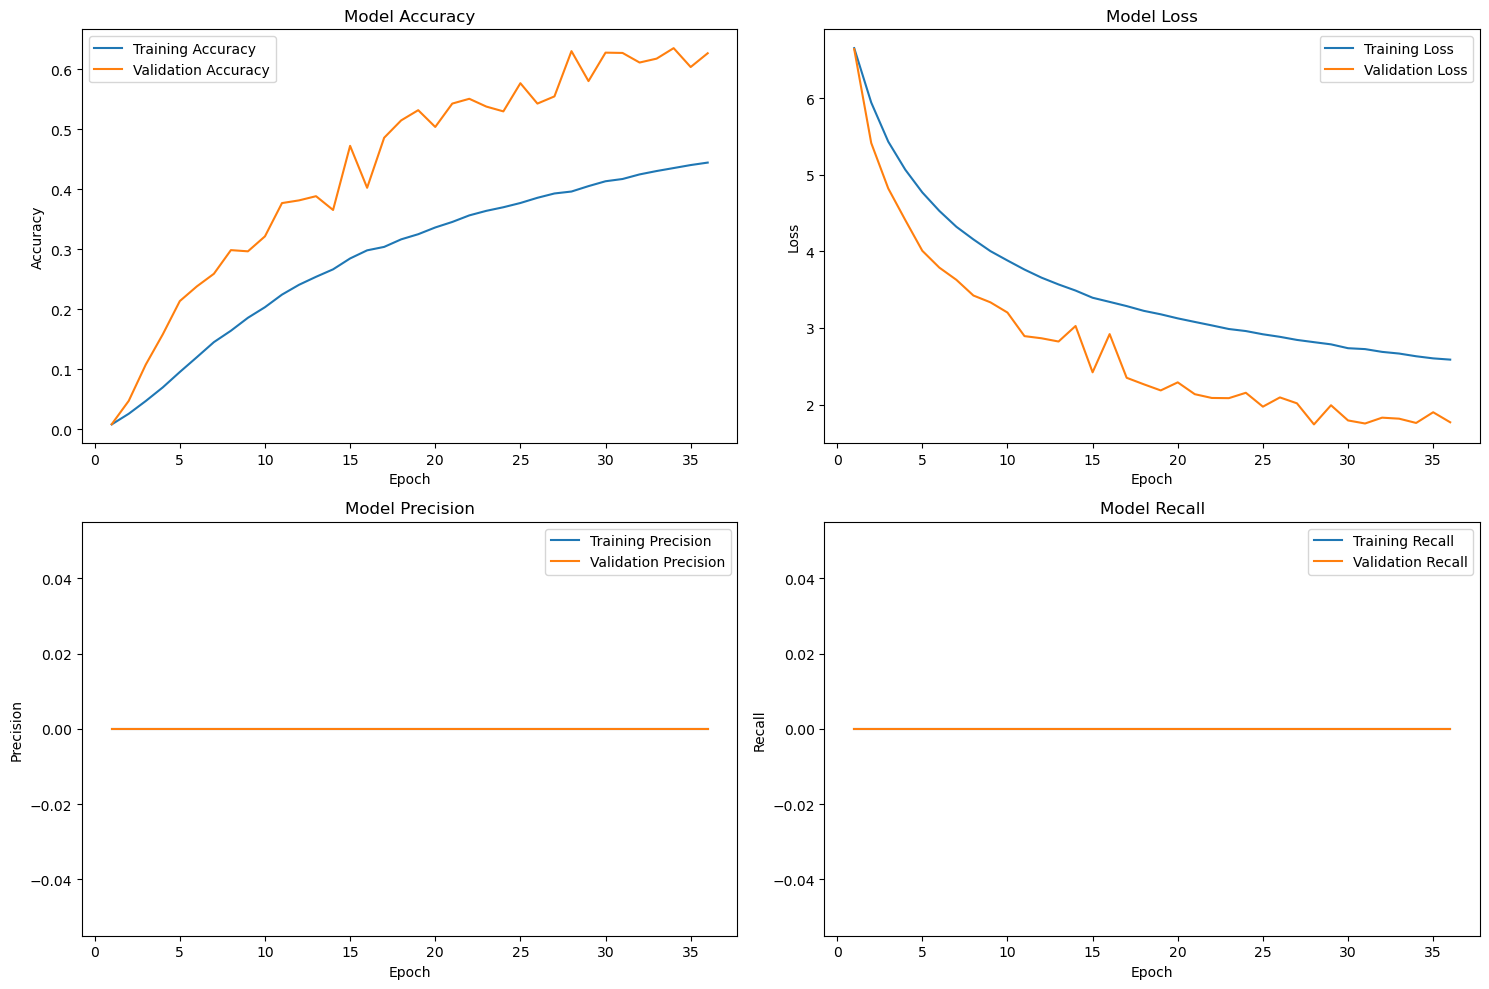

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 537s 294ms/step - accuracy: 0.4482 - loss: 2.5657 - precision_6: 0.7759 - recall_6: 0.2360 - val_accuracy: 0.6270 - val_loss: 1.7687 - val_precision_6: 0.8196 - val_recall_6: 0.4885 - learning_rate: 1.0000e-04

Global Epoch 37/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4497 - loss: 2.5568 - precision_6: 0.7773 - recall_6: 0.2379
Epoch 1: val_accuracy did not improve from 0.63550



Global Epoch 37 Metrics:
Time taken: 8.95 minutes
Training Accuracy: 0.4468
Validation Accuracy: 0.6300
Training Loss: 2.5725
Validation Loss: 1.7120
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_37.h5


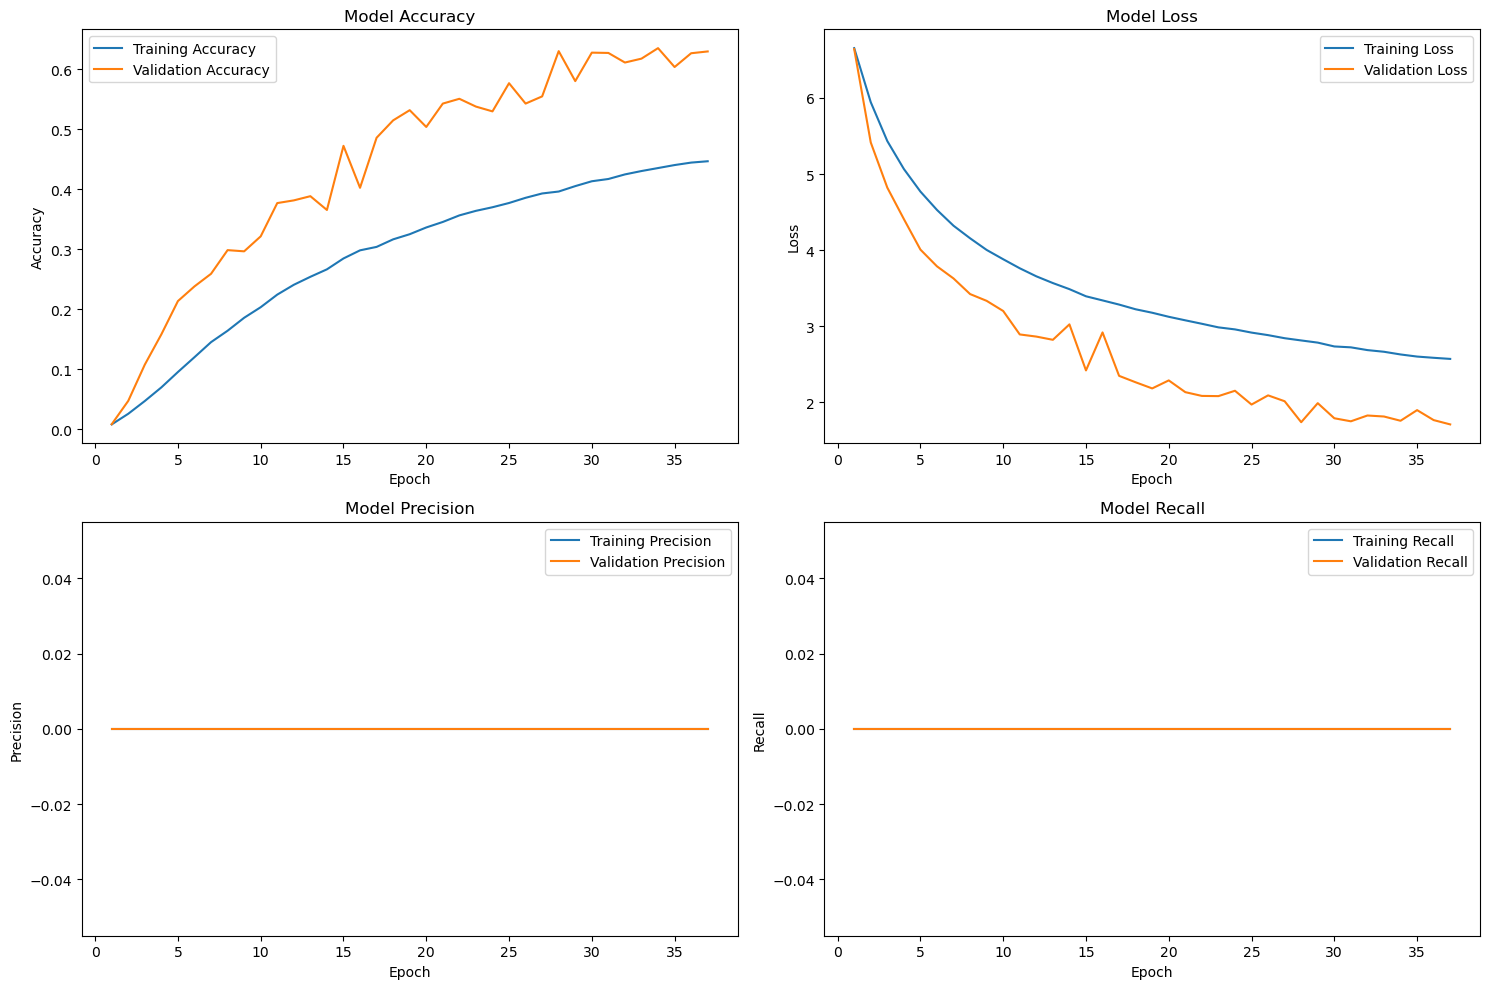

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 538s 295ms/step - accuracy: 0.4497 - loss: 2.5568 - precision_6: 0.7773 - recall_6: 0.2379 - val_accuracy: 0.6300 - val_loss: 1.7120 - val_precision_6: 0.8176 - val_recall_6: 0.4930 - learning_rate: 1.0000e-04

Global Epoch 38/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4535 - loss: 2.5577 - precision_6: 0.7663 - recall_6: 0.2401
Epoch 1: val_accuracy improved from 0.63550 to 0.67250, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-1.57.weights.h5



Global Epoch 38 Metrics:
Time taken: 8.95 minutes
Training Accuracy: 0.4506
Validation Accuracy: 0.6725
Training Loss: 2.5590
Validation Loss: 1.5682
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_38.h5


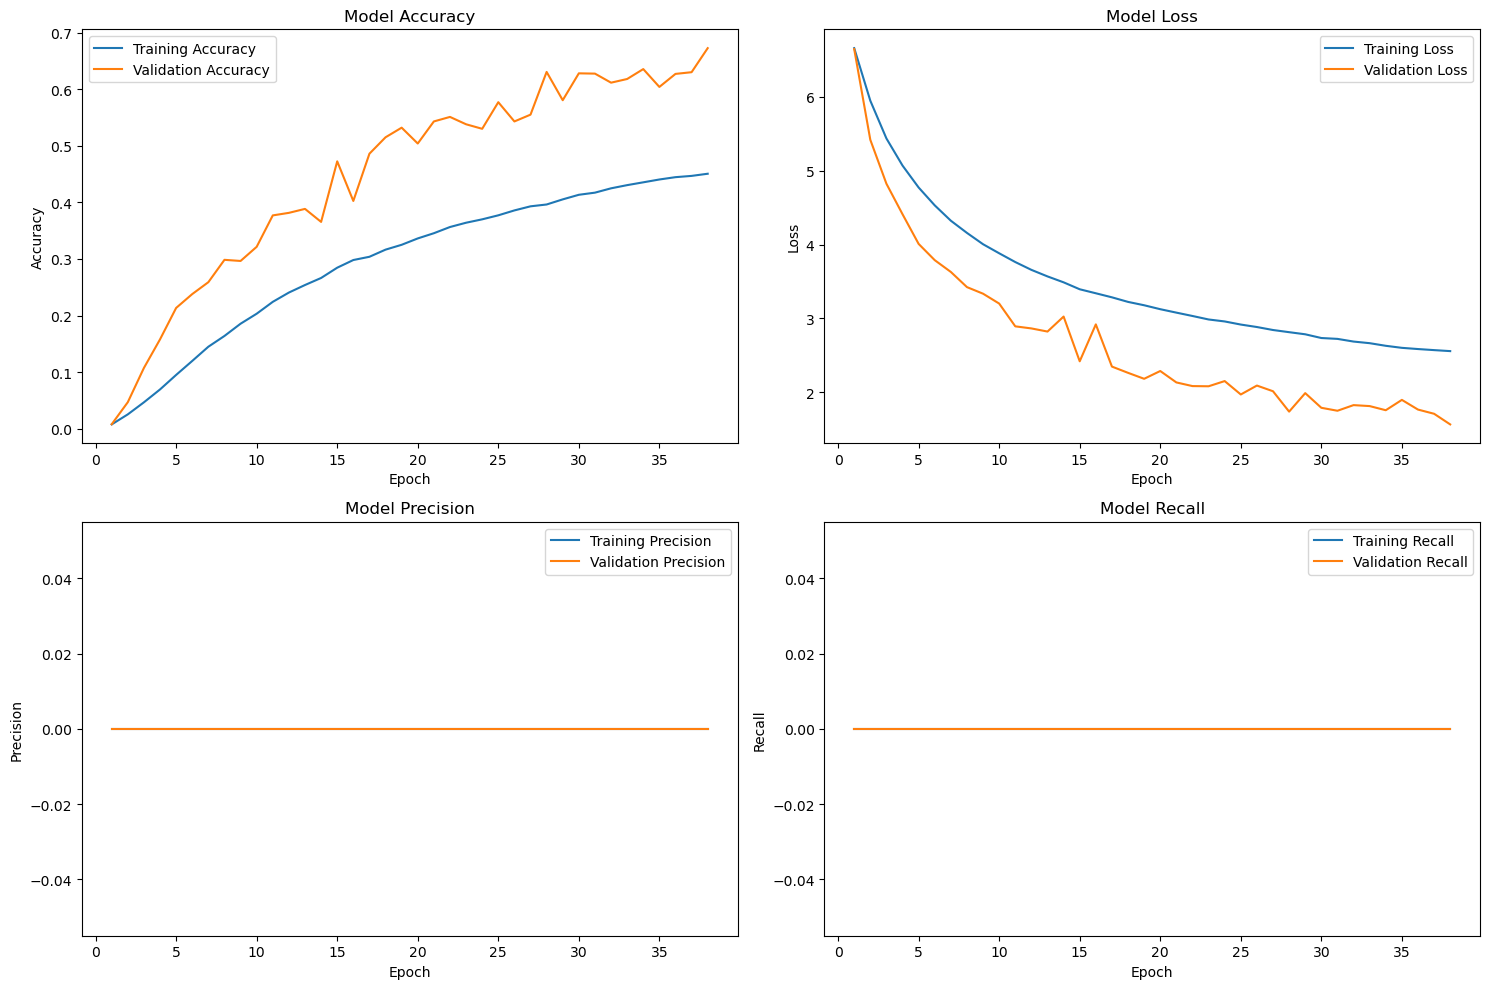

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 537s 294ms/step - accuracy: 0.4535 - loss: 2.5577 - precision_6: 0.7663 - recall_6: 0.2401 - val_accuracy: 0.6725 - val_loss: 1.5682 - val_precision_6: 0.8435 - val_recall_6: 0.5390 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.6725000143051147

Global Epoch 39/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4583 - loss: 2.5275 - precision_6: 0.7708 - recall_6: 0.2480
Epoch 1: val_accuracy did not improve from 0.67250



Global Epoch 39 Metrics:
Time taken: 9.01 minutes
Training Accuracy: 0.4573
Validation Accuracy: 0.6375
Training Loss: 2.5291
Validation Loss: 1.7088
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_39.h5


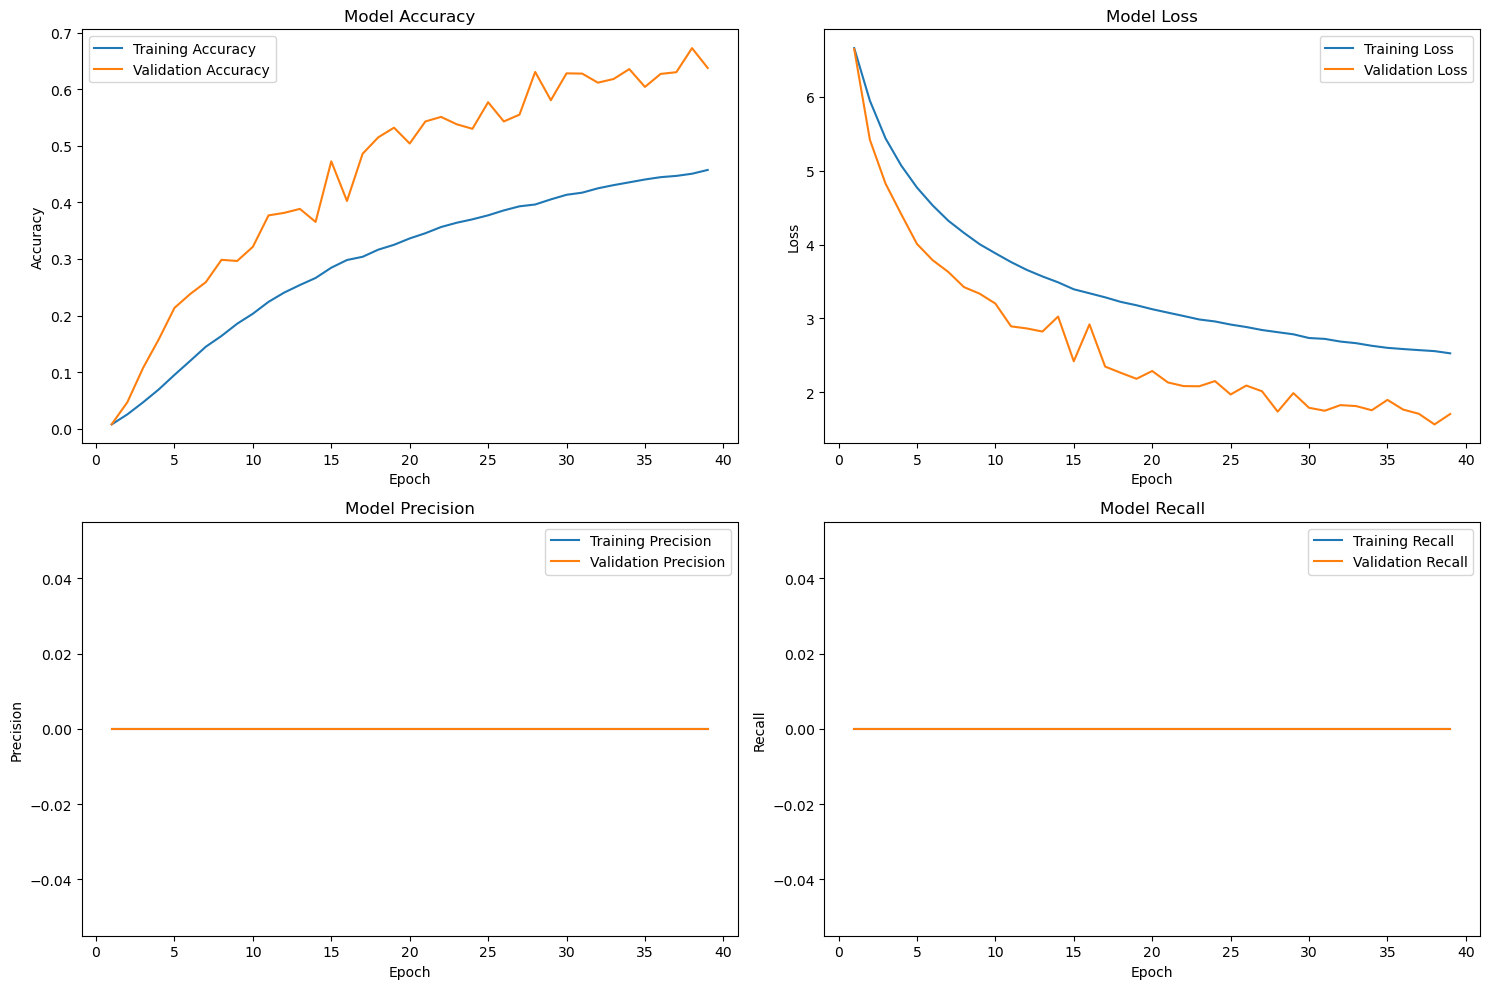

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 541s 296ms/step - accuracy: 0.4583 - loss: 2.5275 - precision_6: 0.7708 - recall_6: 0.2480 - val_accuracy: 0.6375 - val_loss: 1.7088 - val_precision_6: 0.8093 - val_recall_6: 0.4985 - learning_rate: 1.0000e-04

Global Epoch 40/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4594 - loss: 2.5185 - precision_6: 0.7758 - recall_6: 0.2516
Epoch 1: val_accuracy improved from 0.67250 to 0.68100, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-1.53.weights.h5



Global Epoch 40 Metrics:
Time taken: 8.97 minutes
Training Accuracy: 0.4625
Validation Accuracy: 0.6810
Training Loss: 2.5128
Validation Loss: 1.5282
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_40.h5


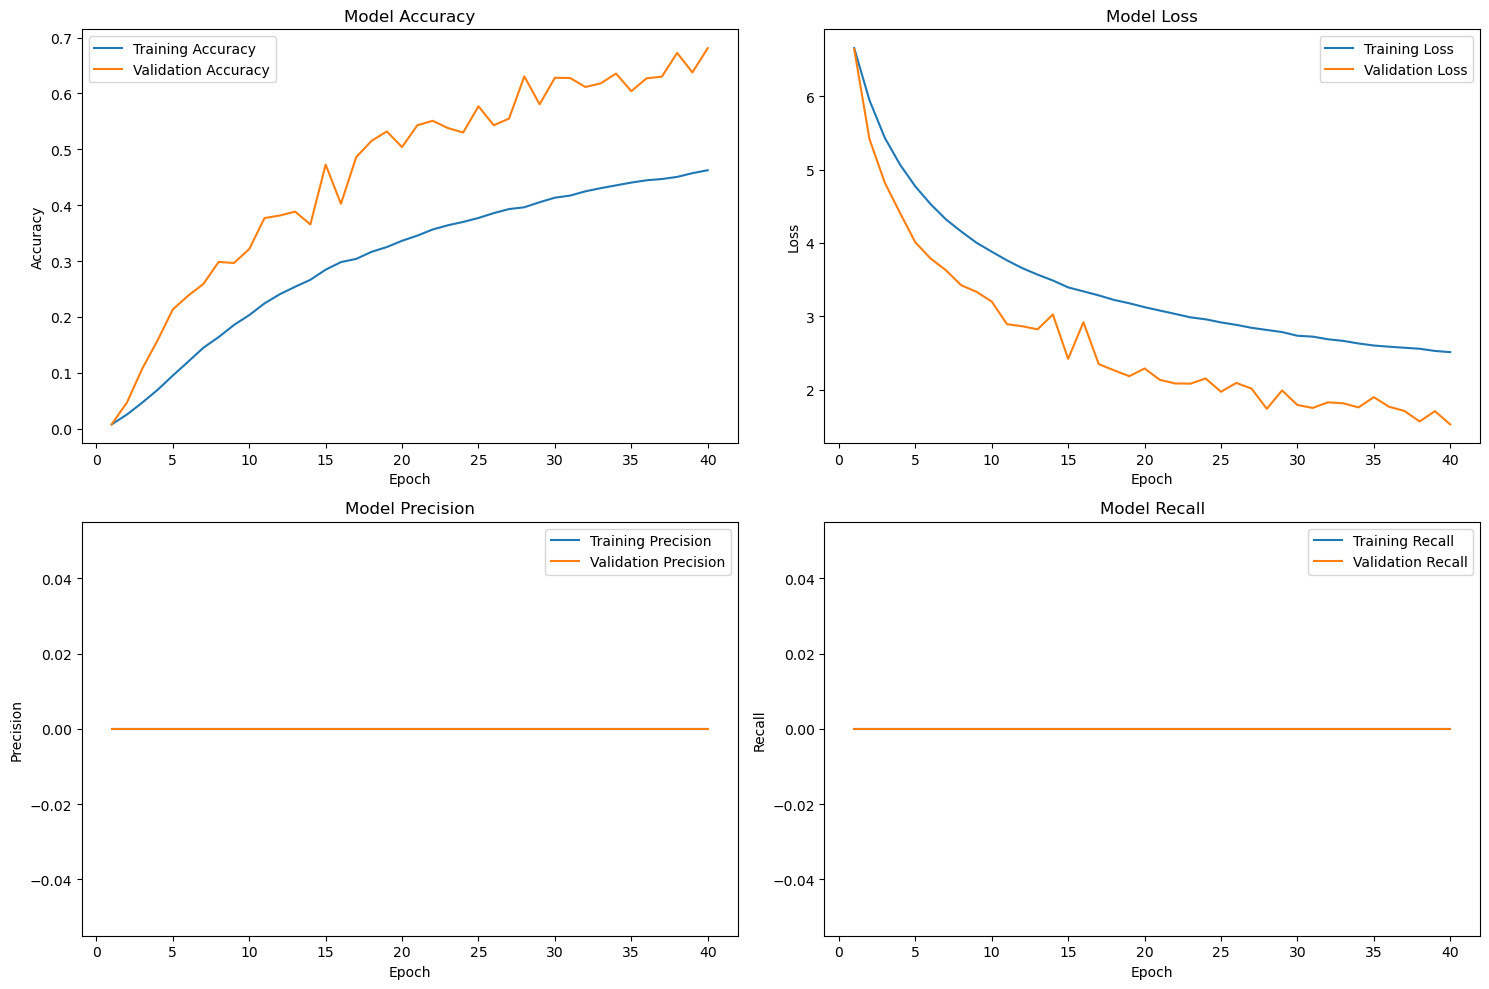

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 538s 295ms/step - accuracy: 0.4594 - loss: 2.5185 - precision_6: 0.7758 - recall_6: 0.2516 - val_accuracy: 0.6810 - val_loss: 1.5282 - val_precision_6: 0.8592 - val_recall_6: 0.5340 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.6809999942779541

Global Epoch 41/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4646 - loss: 2.4935 - precision_6: 0.7802 - recall_6: 0.2569
Epoch 1: val_accuracy did not improve from 0.68100



Global Epoch 41 Metrics:
Time taken: 8.99 minutes
Training Accuracy: 0.4659
Validation Accuracy: 0.6745
Training Loss: 2.4816
Validation Loss: 1.5794
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_41.h5


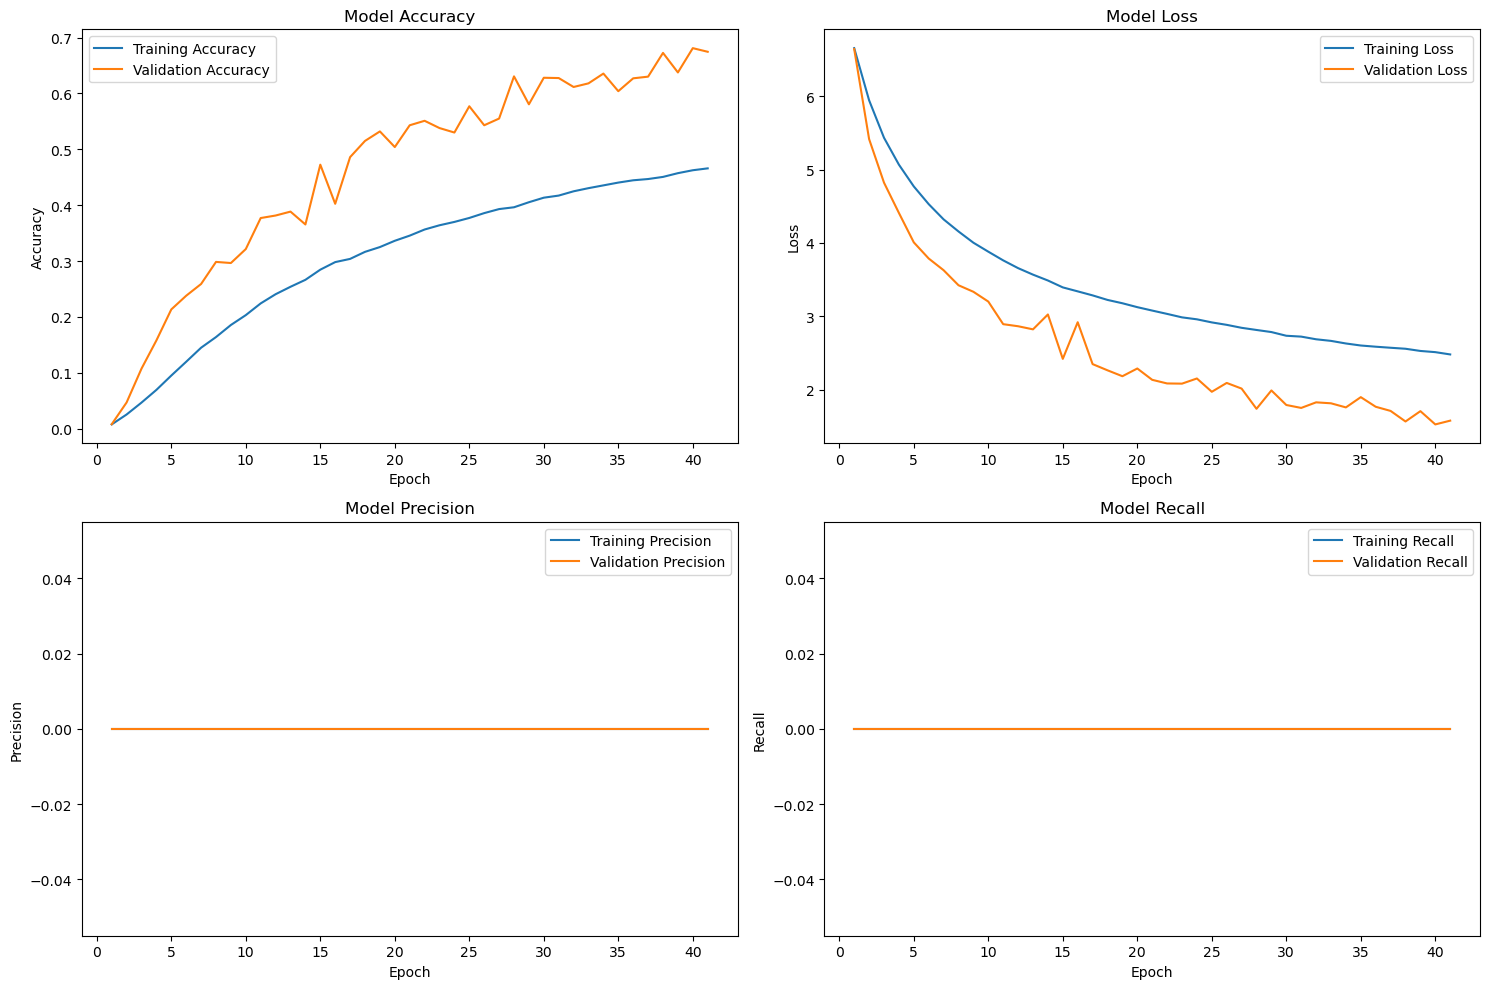

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 540s 296ms/step - accuracy: 0.4646 - loss: 2.4935 - precision_6: 0.7802 - recall_6: 0.2569 - val_accuracy: 0.6745 - val_loss: 1.5794 - val_precision_6: 0.8509 - val_recall_6: 0.5280 - learning_rate: 1.0000e-04

Global Epoch 42/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4664 - loss: 2.4630 - precision_6: 0.7738 - recall_6: 0.2627
Epoch 1: val_accuracy did not improve from 0.68100



Global Epoch 42 Metrics:
Time taken: 8.94 minutes
Training Accuracy: 0.4680
Validation Accuracy: 0.6475
Training Loss: 2.4679
Validation Loss: 1.7098
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_42.h5


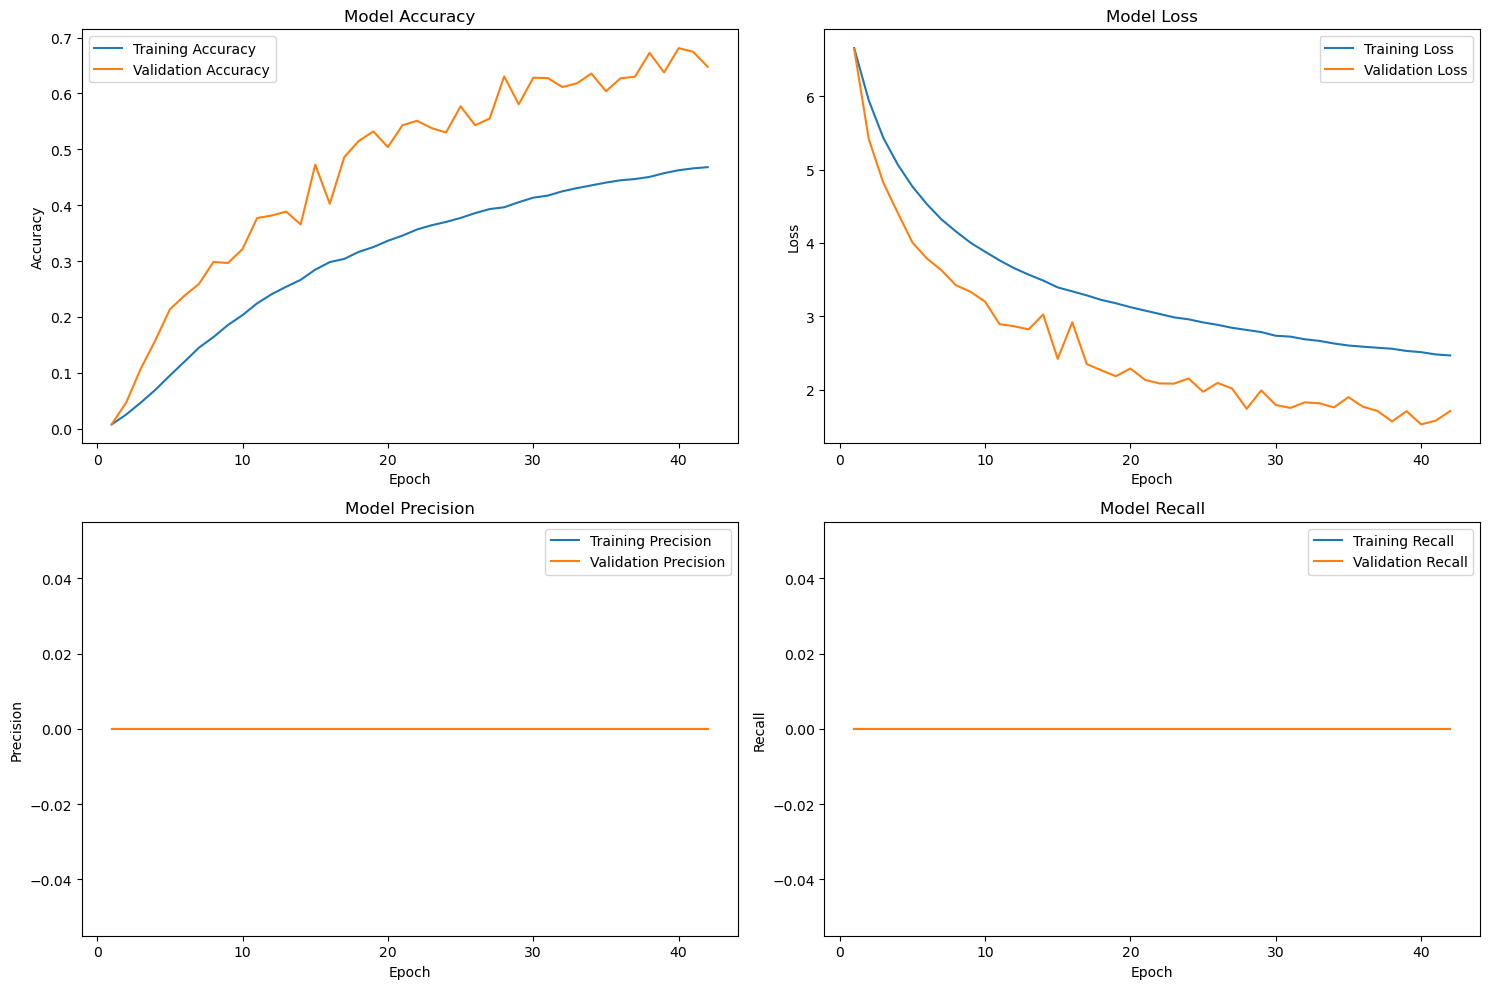

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 537s 294ms/step - accuracy: 0.4664 - loss: 2.4630 - precision_6: 0.7738 - recall_6: 0.2627 - val_accuracy: 0.6475 - val_loss: 1.7098 - val_precision_6: 0.8215 - val_recall_6: 0.5225 - learning_rate: 1.0000e-04

Global Epoch 43/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4746 - loss: 2.4569 - precision_6: 0.7793 - recall_6: 0.2696
Epoch 1: val_accuracy did not improve from 0.68100



Global Epoch 43 Metrics:
Time taken: 8.99 minutes
Training Accuracy: 0.4749
Validation Accuracy: 0.6610
Training Loss: 2.4546
Validation Loss: 1.6477
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_43.h5


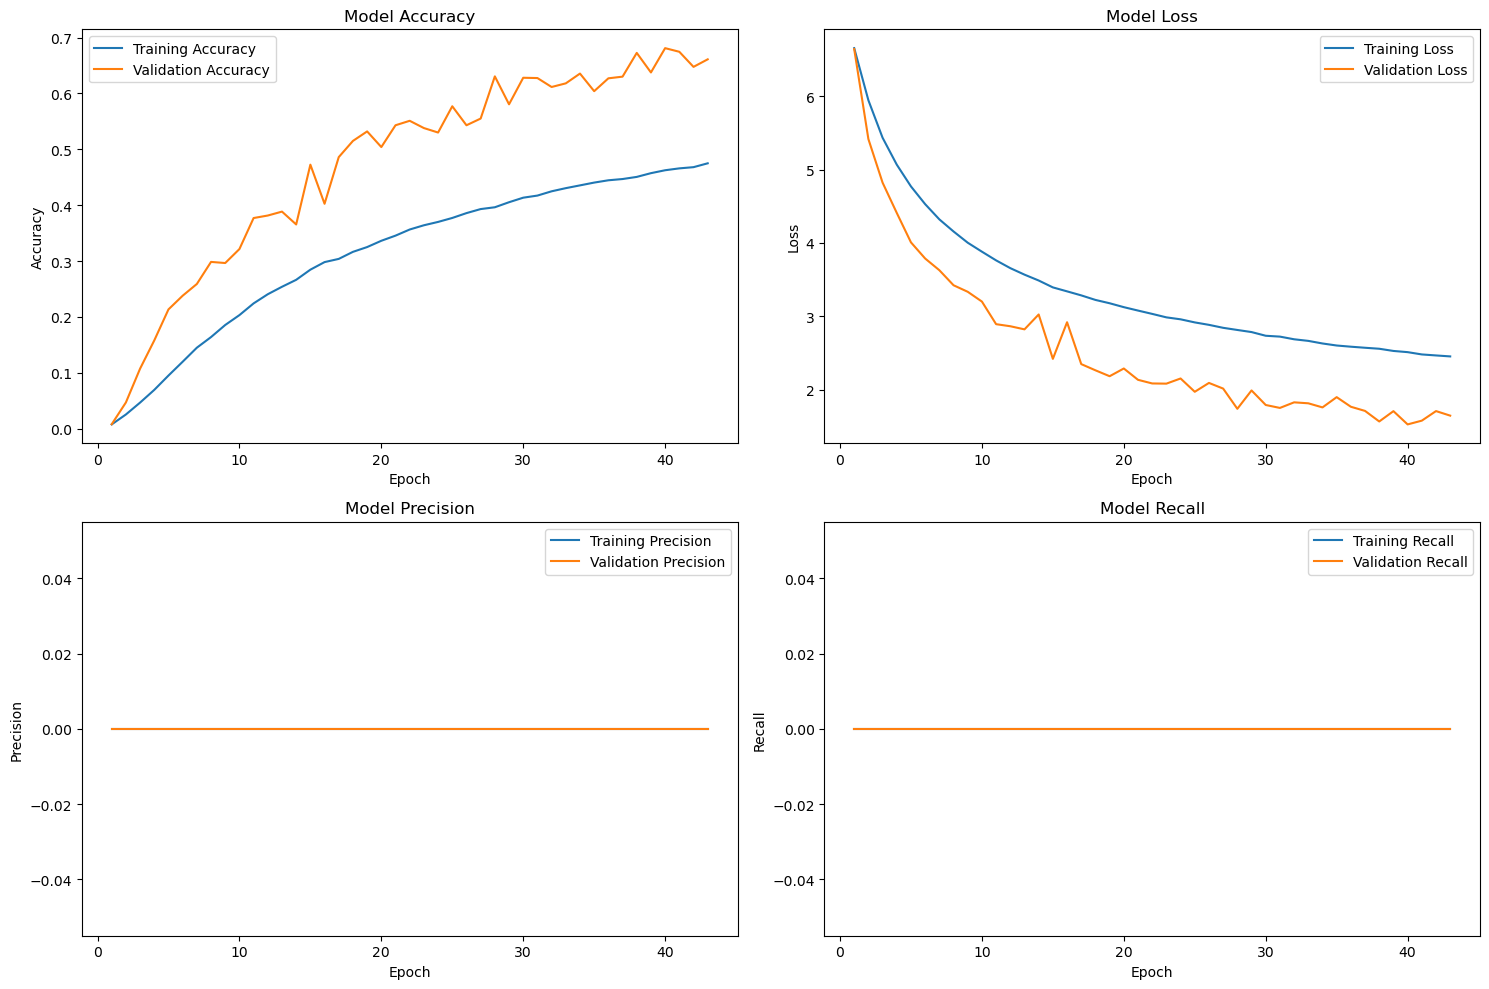

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 540s 296ms/step - accuracy: 0.4746 - loss: 2.4569 - precision_6: 0.7793 - recall_6: 0.2696 - val_accuracy: 0.6610 - val_loss: 1.6477 - val_precision_6: 0.8339 - val_recall_6: 0.5320 - learning_rate: 1.0000e-04

Global Epoch 44/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4748 - loss: 2.4360 - precision_6: 0.7783 - recall_6: 0.2760
Epoch 1: val_accuracy improved from 0.68100 to 0.70000, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-1.50.weights.h5



Global Epoch 44 Metrics:
Time taken: 8.96 minutes
Training Accuracy: 0.4786
Validation Accuracy: 0.7000
Training Loss: 2.4305
Validation Loss: 1.4951
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_44.h5


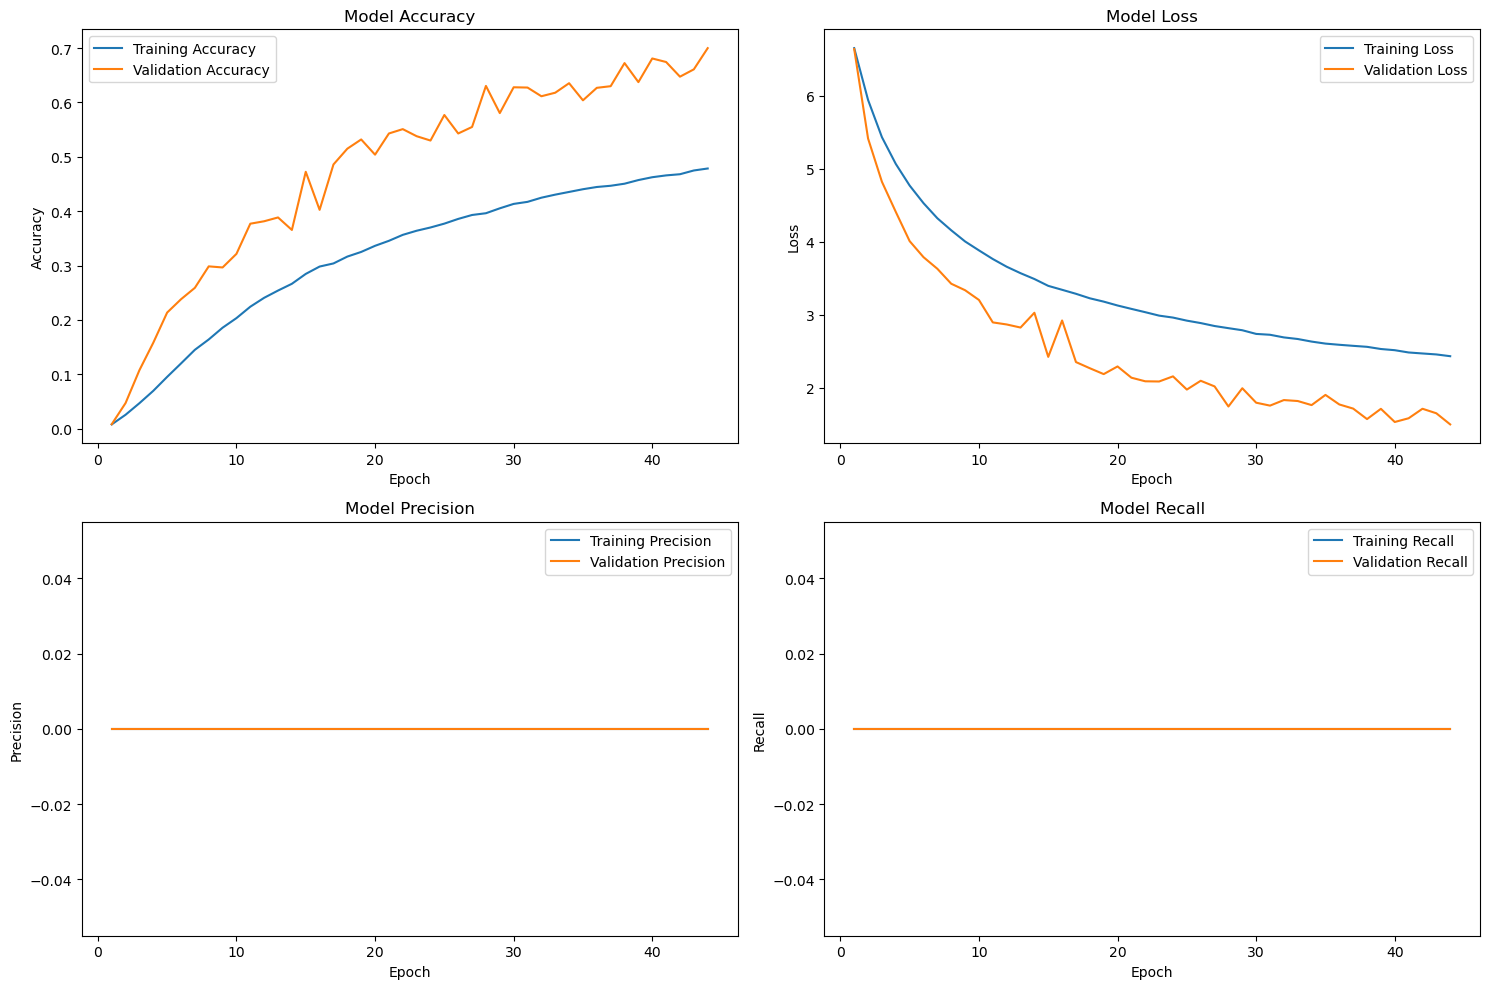

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 538s 295ms/step - accuracy: 0.4748 - loss: 2.4360 - precision_6: 0.7783 - recall_6: 0.2760 - val_accuracy: 0.7000 - val_loss: 1.4951 - val_precision_6: 0.8586 - val_recall_6: 0.5525 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.699999988079071

Global Epoch 45/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4806 - loss: 2.4136 - precision_6: 0.7867 - recall_6: 0.2824
Epoch 1: val_accuracy improved from 0.70000 to 0.70050, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-1.45.weights.h5



Global Epoch 45 Metrics:
Time taken: 9.09 minutes
Training Accuracy: 0.4825
Validation Accuracy: 0.7005
Training Loss: 2.4150
Validation Loss: 1.4548
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_45.h5


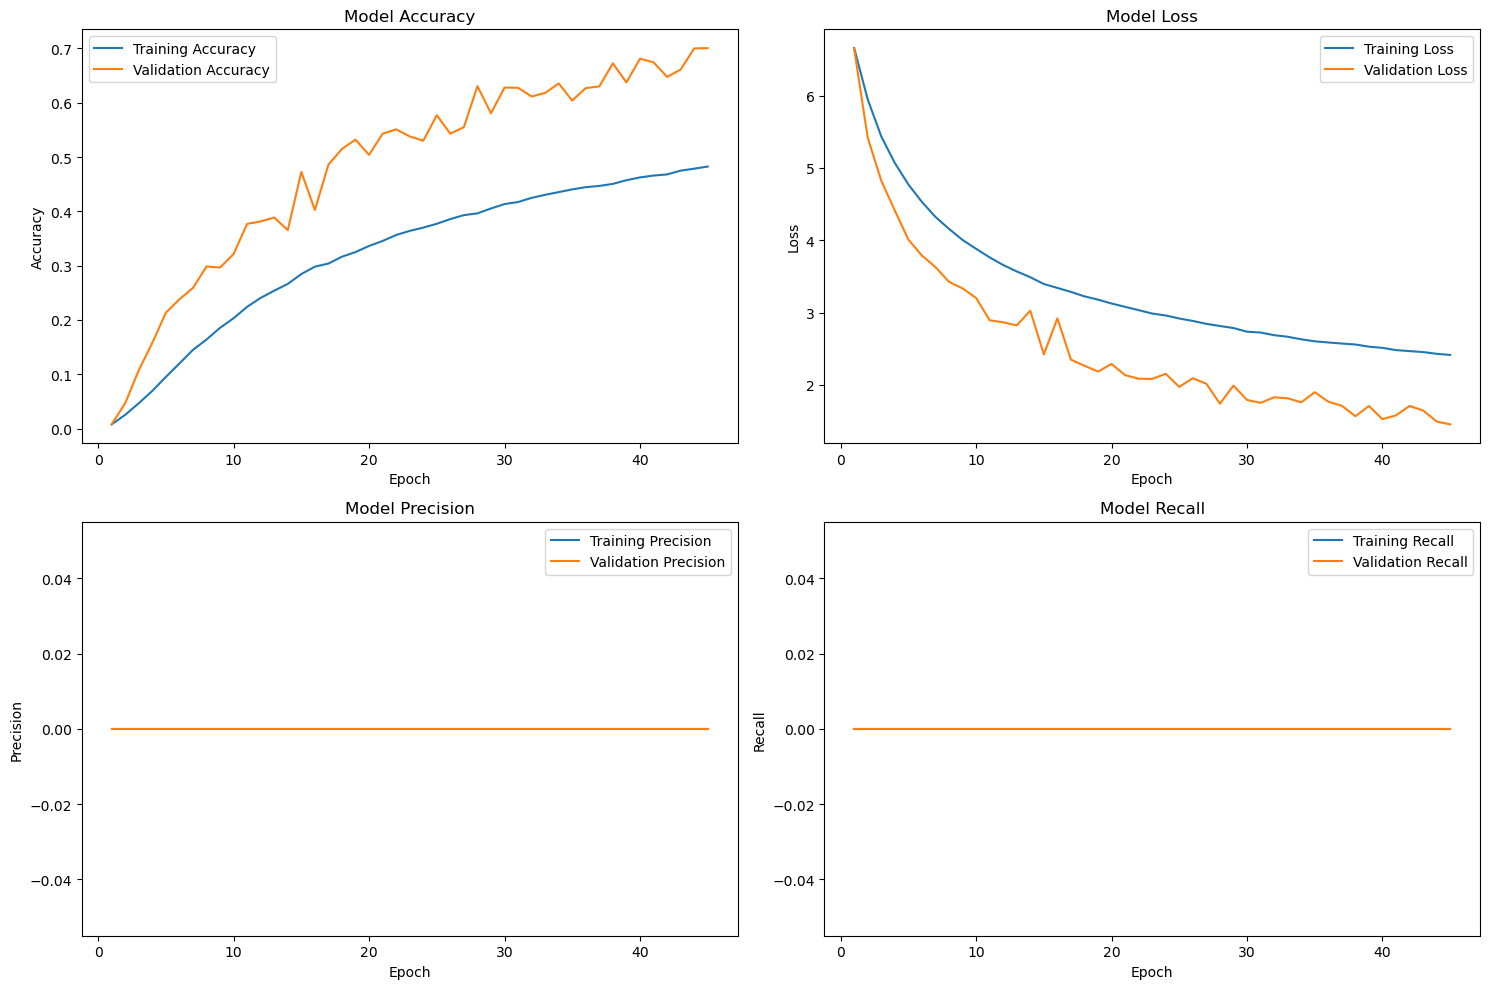

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 546s 299ms/step - accuracy: 0.4806 - loss: 2.4136 - precision_6: 0.7867 - recall_6: 0.2824 - val_accuracy: 0.7005 - val_loss: 1.4548 - val_precision_6: 0.8660 - val_recall_6: 0.5560 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.7005000114440918

Global Epoch 46/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4872 - loss: 2.3896 - precision_6: 0.7788 - recall_6: 0.2818
Epoch 1: val_accuracy did not improve from 0.70050



Global Epoch 46 Metrics:
Time taken: 9.14 minutes
Training Accuracy: 0.4846
Validation Accuracy: 0.6845
Training Loss: 2.3958
Validation Loss: 1.5178
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_46.h5


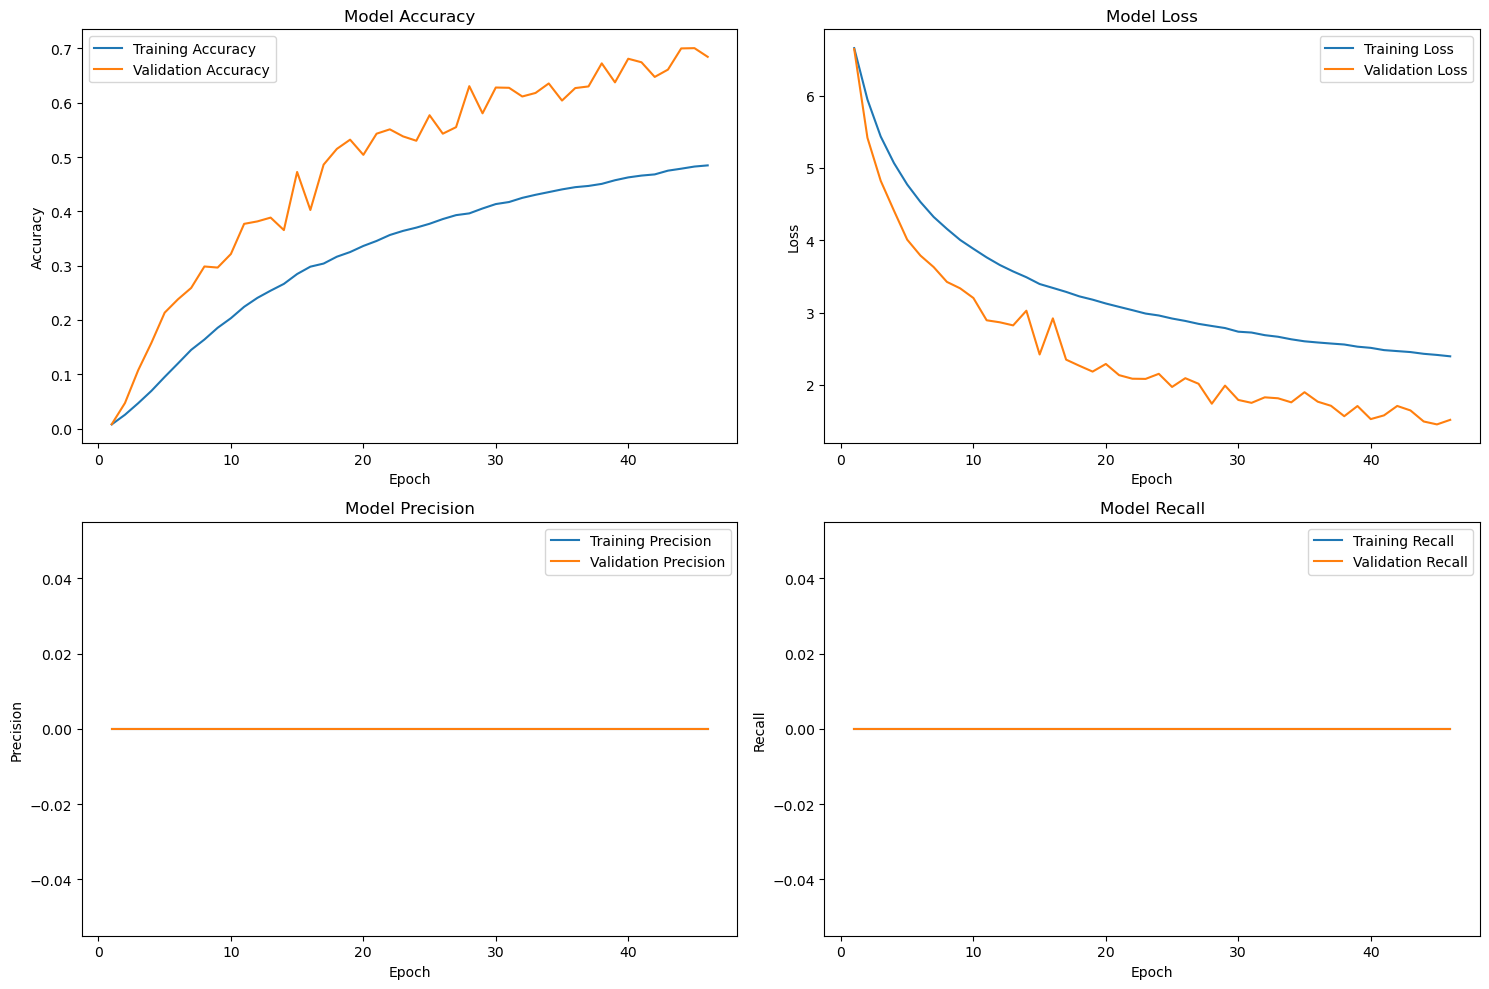

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 549s 301ms/step - accuracy: 0.4872 - loss: 2.3896 - precision_6: 0.7788 - recall_6: 0.2818 - val_accuracy: 0.6845 - val_loss: 1.5178 - val_precision_6: 0.8399 - val_recall_6: 0.5615 - learning_rate: 1.0000e-04

Global Epoch 47/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4910 - loss: 2.3693 - precision_6: 0.7851 - recall_6: 0.2878
Epoch 1: val_accuracy did not improve from 0.70050



Global Epoch 47 Metrics:
Time taken: 8.91 minutes
Training Accuracy: 0.4931
Validation Accuracy: 0.6775
Training Loss: 2.3608
Validation Loss: 1.5300
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_47.h5


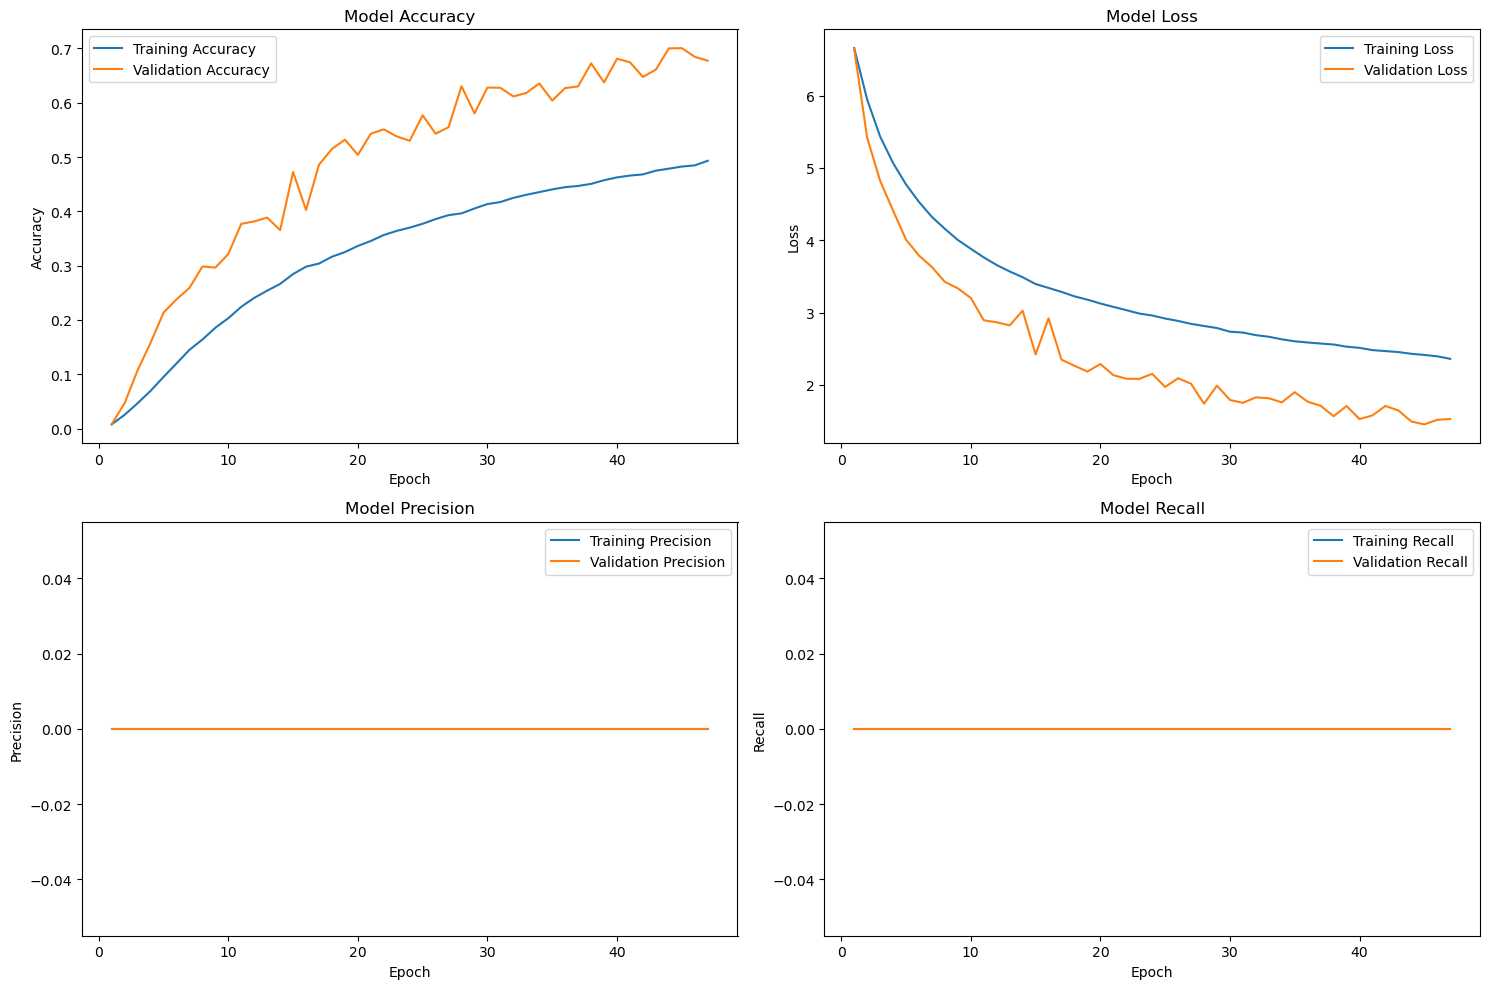

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.4910 - loss: 2.3693 - precision_6: 0.7851 - recall_6: 0.2878 - val_accuracy: 0.6775 - val_loss: 1.5300 - val_precision_6: 0.8521 - val_recall_6: 0.5530 - learning_rate: 1.0000e-04

Global Epoch 48/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4929 - loss: 2.3607 - precision_6: 0.7917 - recall_6: 0.2947
Epoch 1: val_accuracy did not improve from 0.70050



Global Epoch 48 Metrics:
Time taken: 8.90 minutes
Training Accuracy: 0.4927
Validation Accuracy: 0.6965
Training Loss: 2.3686
Validation Loss: 1.4558
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_48.h5


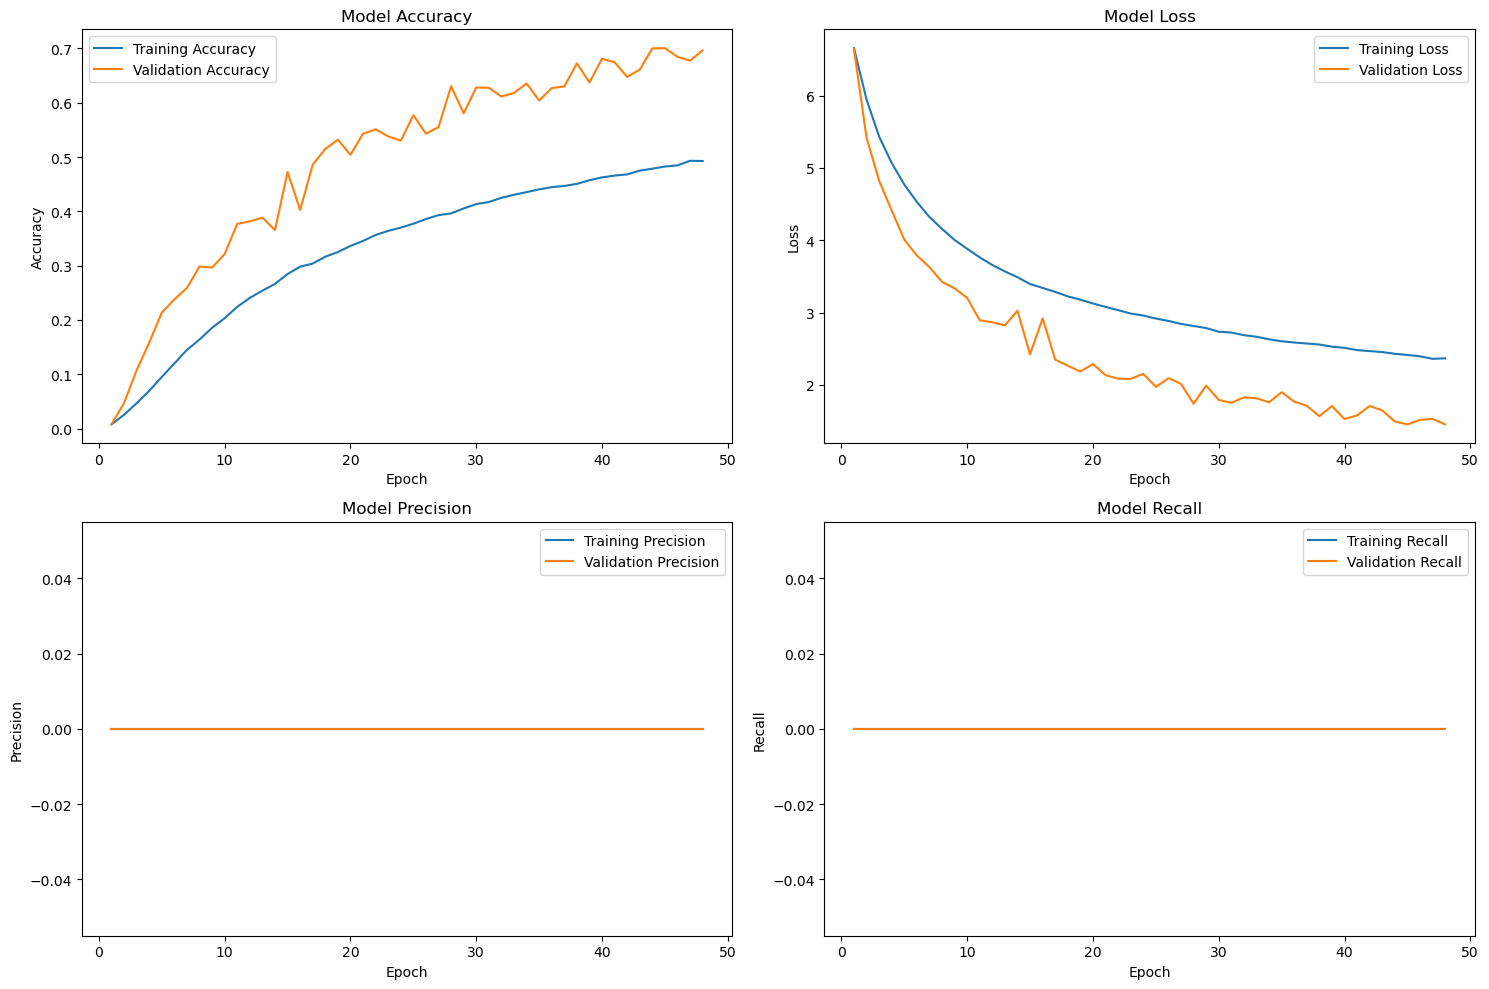

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.4929 - loss: 2.3607 - precision_6: 0.7917 - recall_6: 0.2947 - val_accuracy: 0.6965 - val_loss: 1.4558 - val_precision_6: 0.8548 - val_recall_6: 0.5710 - learning_rate: 1.0000e-04

Global Epoch 49/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.4948 - loss: 2.3374 - precision_6: 0.7882 - recall_6: 0.2977
Epoch 1: val_accuracy did not improve from 0.70050



Global Epoch 49 Metrics:
Time taken: 9.04 minutes
Training Accuracy: 0.4955
Validation Accuracy: 0.6885
Training Loss: 2.3428
Validation Loss: 1.5202
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_49.h5


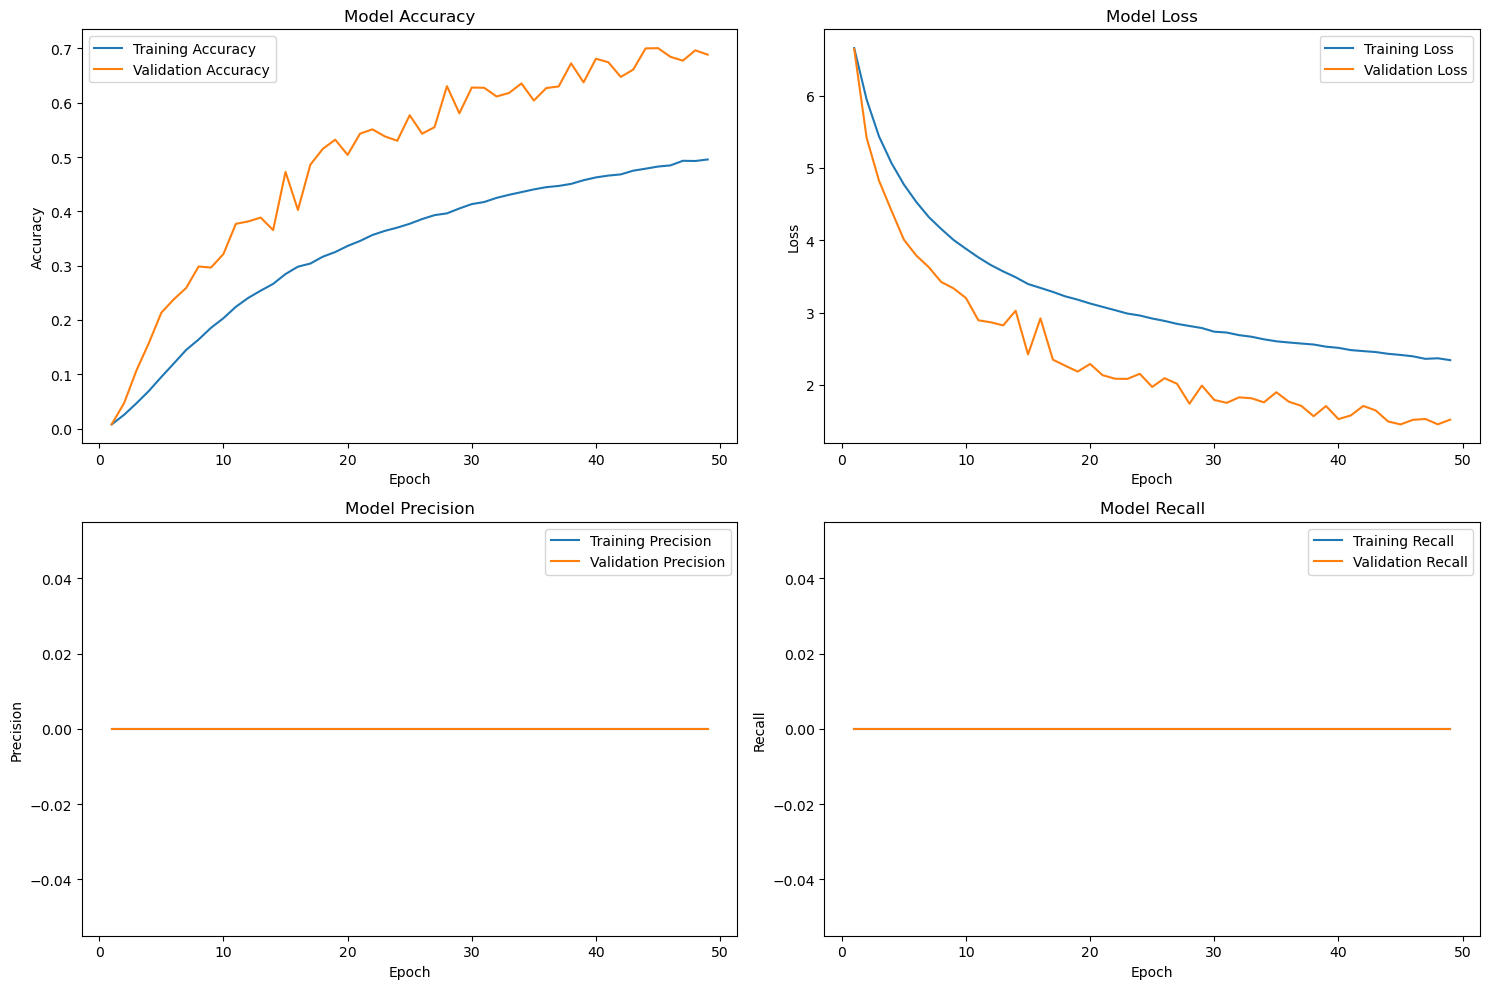

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 543s 297ms/step - accuracy: 0.4948 - loss: 2.3374 - precision_6: 0.7882 - recall_6: 0.2977 - val_accuracy: 0.6885 - val_loss: 1.5202 - val_precision_6: 0.8345 - val_recall_6: 0.5750 - learning_rate: 1.0000e-04

Global Epoch 50/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5021 - loss: 2.3194 - precision_6: 0.7892 - recall_6: 0.3056
Epoch 1: val_accuracy improved from 0.70050 to 0.71950, saving model to /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/checkpoint_epoch-01_val_loss-1.35.weights.h5



Global Epoch 50 Metrics:
Time taken: 8.91 minutes
Training Accuracy: 0.4987
Validation Accuracy: 0.7195
Training Loss: 2.3325
Validation Loss: 1.3480
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_50.h5


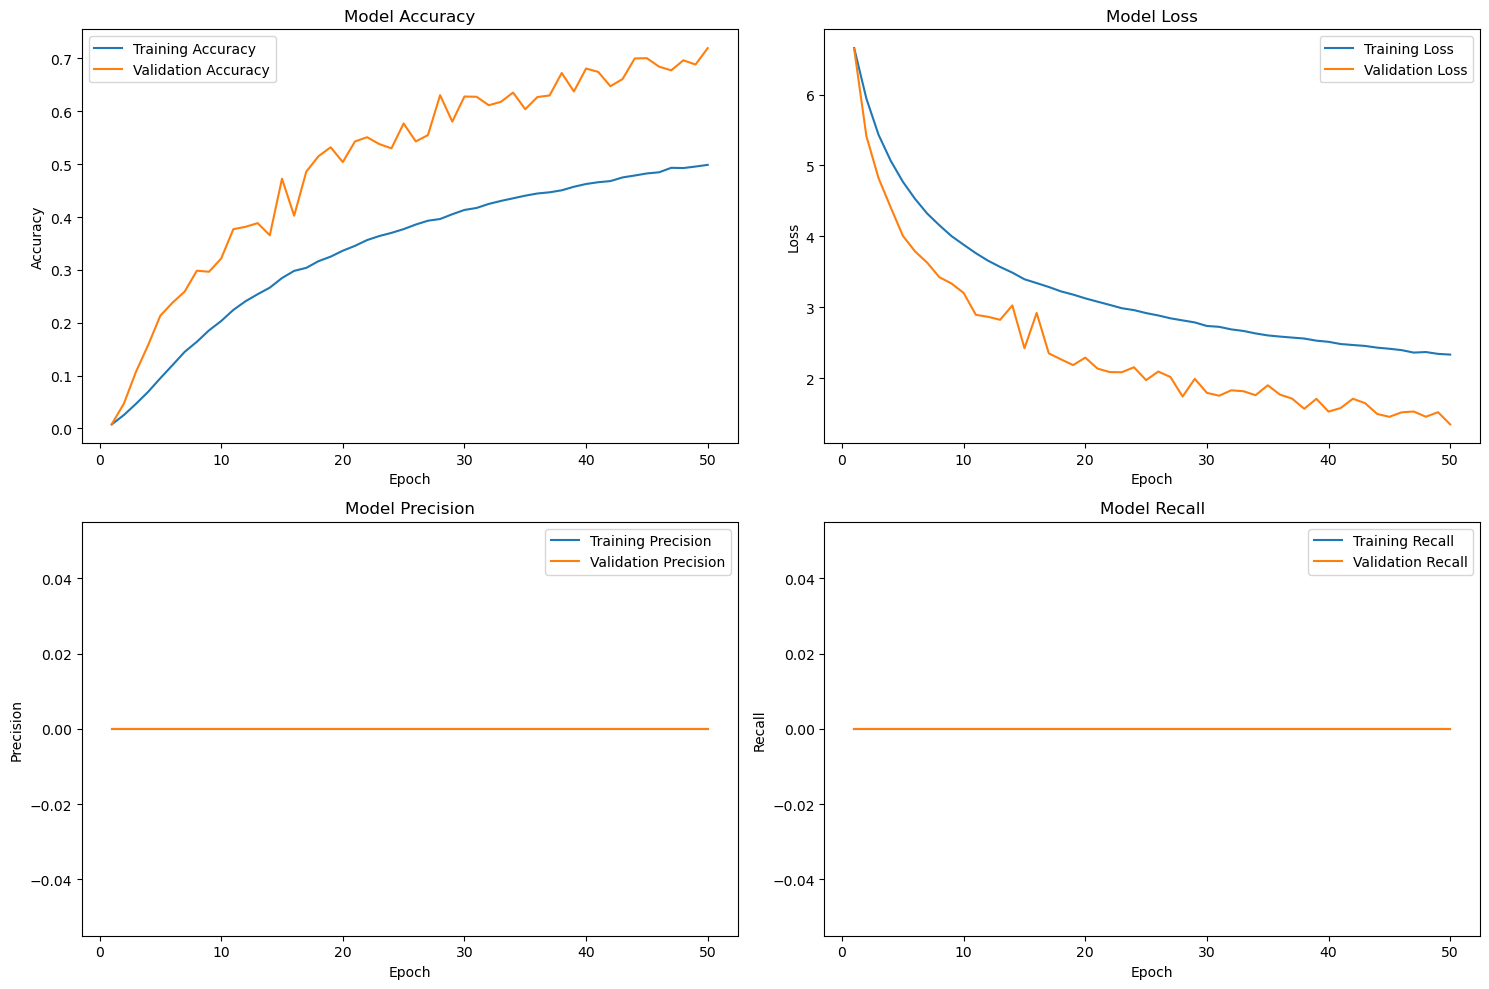

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 535s 293ms/step - accuracy: 0.5021 - loss: 2.3194 - precision_6: 0.7892 - recall_6: 0.3056 - val_accuracy: 0.7195 - val_loss: 1.3480 - val_precision_6: 0.8572 - val_recall_6: 0.6005 - learning_rate: 1.0000e-04


New best model saved with validation accuracy: 0.7195000052452087

Global Epoch 51/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5016 - loss: 2.3214 - precision_6: 0.7855 - recall_6: 0.3057
Epoch 1: val_accuracy did not improve from 0.71950



Global Epoch 51 Metrics:
Time taken: 8.90 minutes
Training Accuracy: 0.5010
Validation Accuracy: 0.7070
Training Loss: 2.3262
Validation Loss: 1.4160
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_51.h5


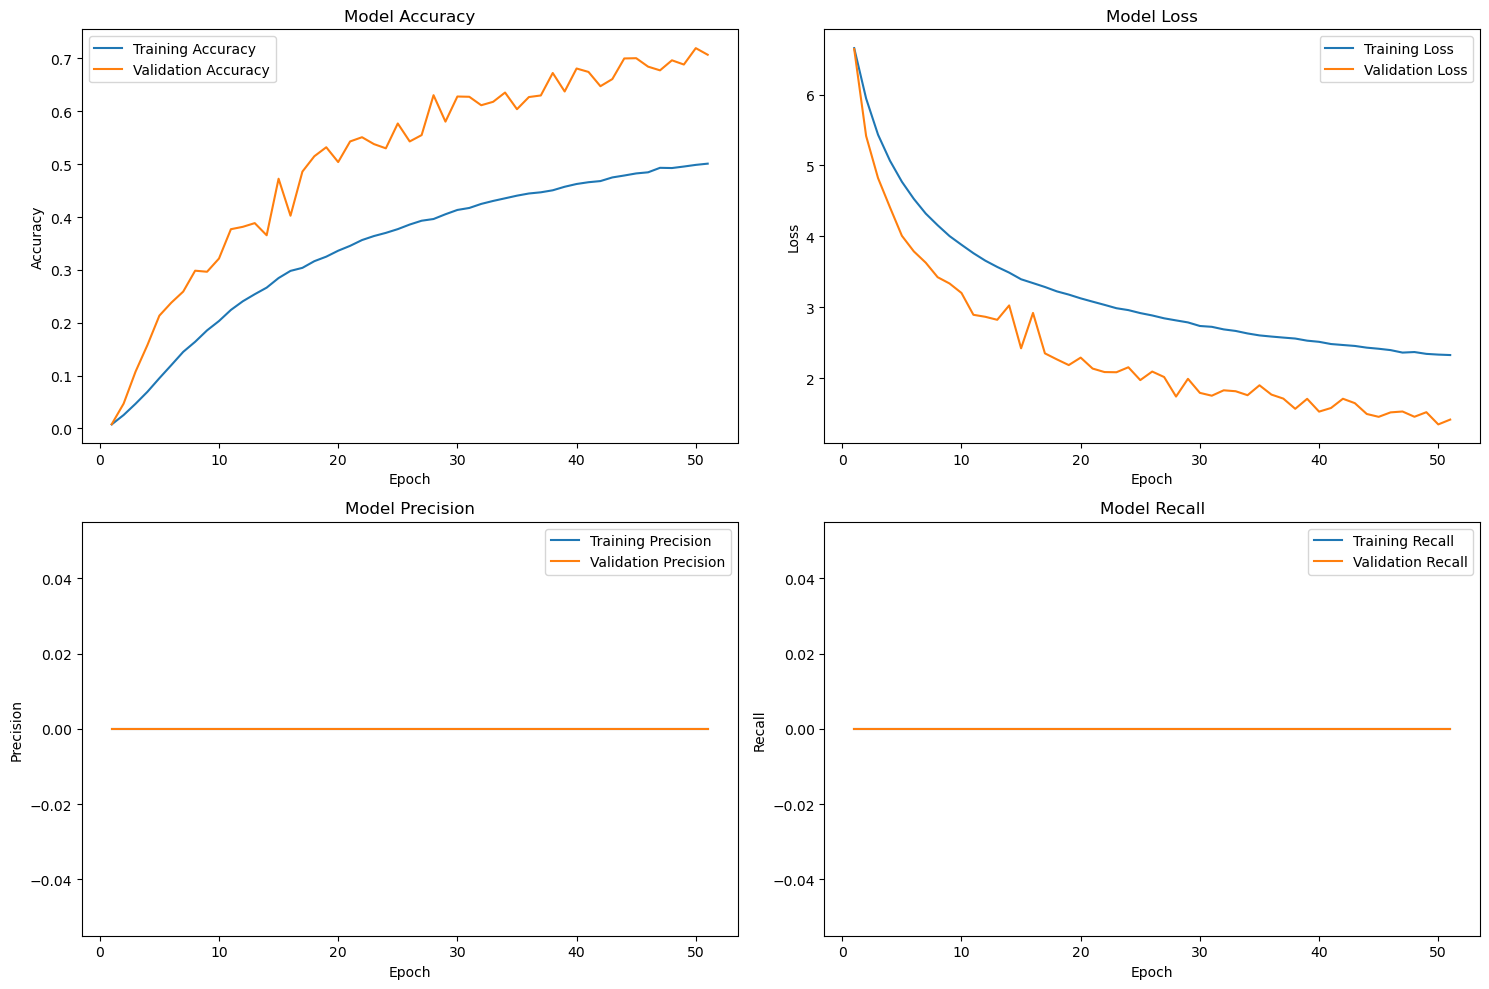

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 534s 293ms/step - accuracy: 0.5016 - loss: 2.3214 - precision_6: 0.7855 - recall_6: 0.3057 - val_accuracy: 0.7070 - val_loss: 1.4160 - val_precision_6: 0.8558 - val_recall_6: 0.5815 - learning_rate: 1.0000e-04

Global Epoch 52/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5056 - loss: 2.2992 - precision_6: 0.7901 - recall_6: 0.3104
Epoch 1: val_accuracy did not improve from 0.71950



Global Epoch 52 Metrics:
Time taken: 8.98 minutes
Training Accuracy: 0.5056
Validation Accuracy: 0.6955
Training Loss: 2.3001
Validation Loss: 1.4307
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_52.h5


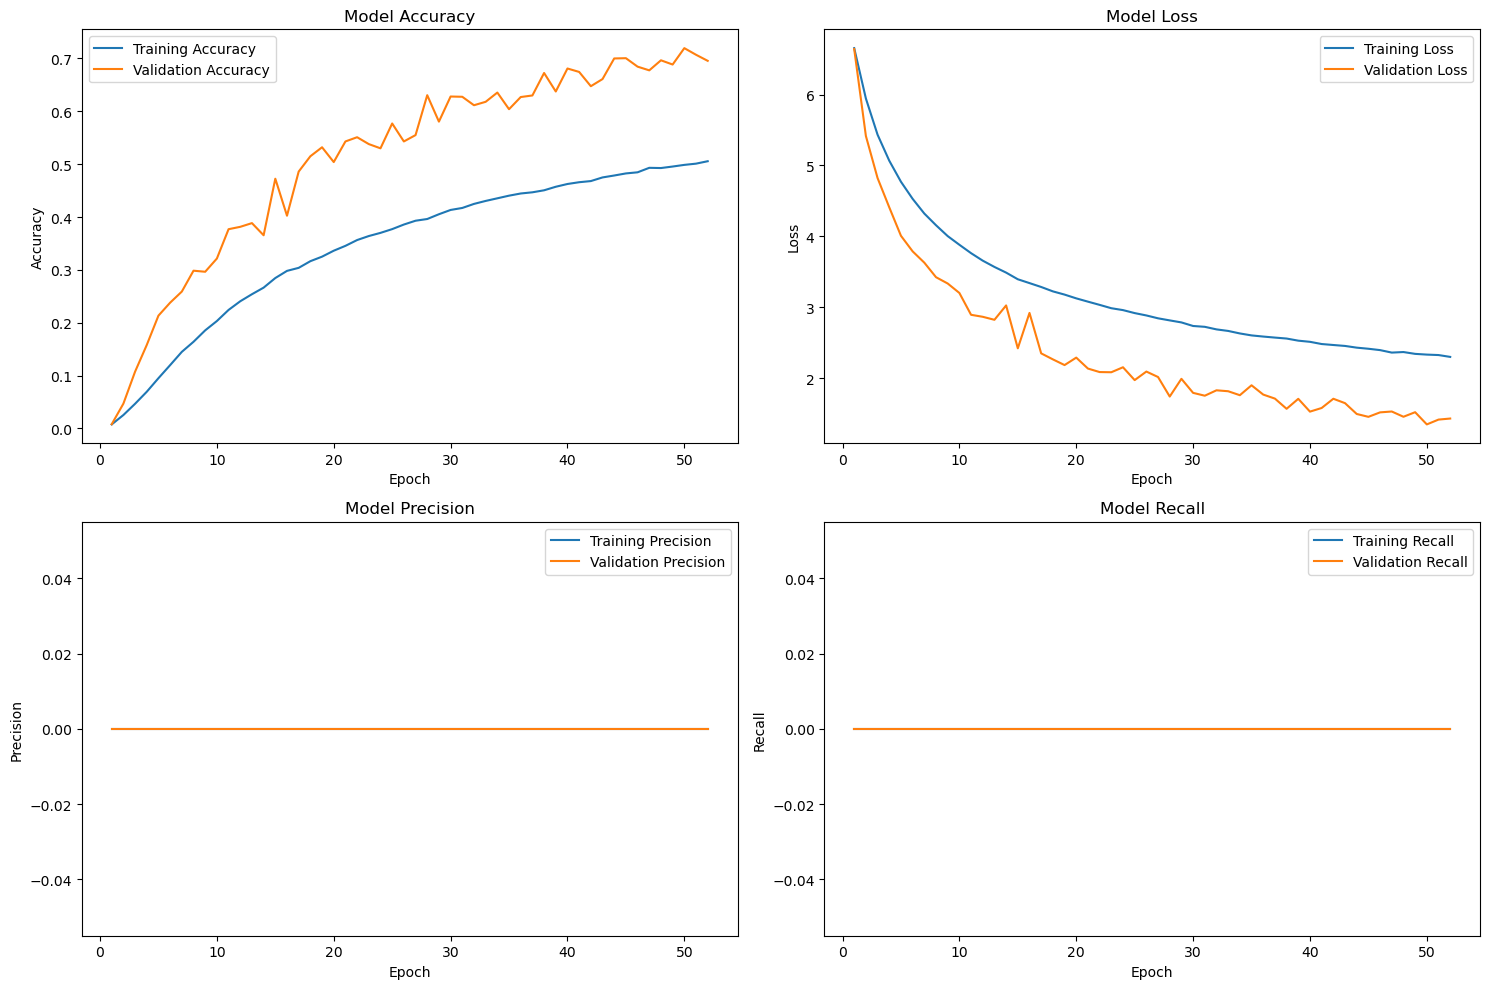

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 539s 295ms/step - accuracy: 0.5056 - loss: 2.2992 - precision_6: 0.7901 - recall_6: 0.3104 - val_accuracy: 0.6955 - val_loss: 1.4307 - val_precision_6: 0.8516 - val_recall_6: 0.5855 - learning_rate: 1.0000e-04

Global Epoch 53/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5062 - loss: 2.2902 - precision_6: 0.7906 - recall_6: 0.3151
Epoch 1: val_accuracy did not improve from 0.71950



Global Epoch 53 Metrics:
Time taken: 9.08 minutes
Training Accuracy: 0.5079
Validation Accuracy: 0.7125
Training Loss: 2.2865
Validation Loss: 1.3982
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_53.h5


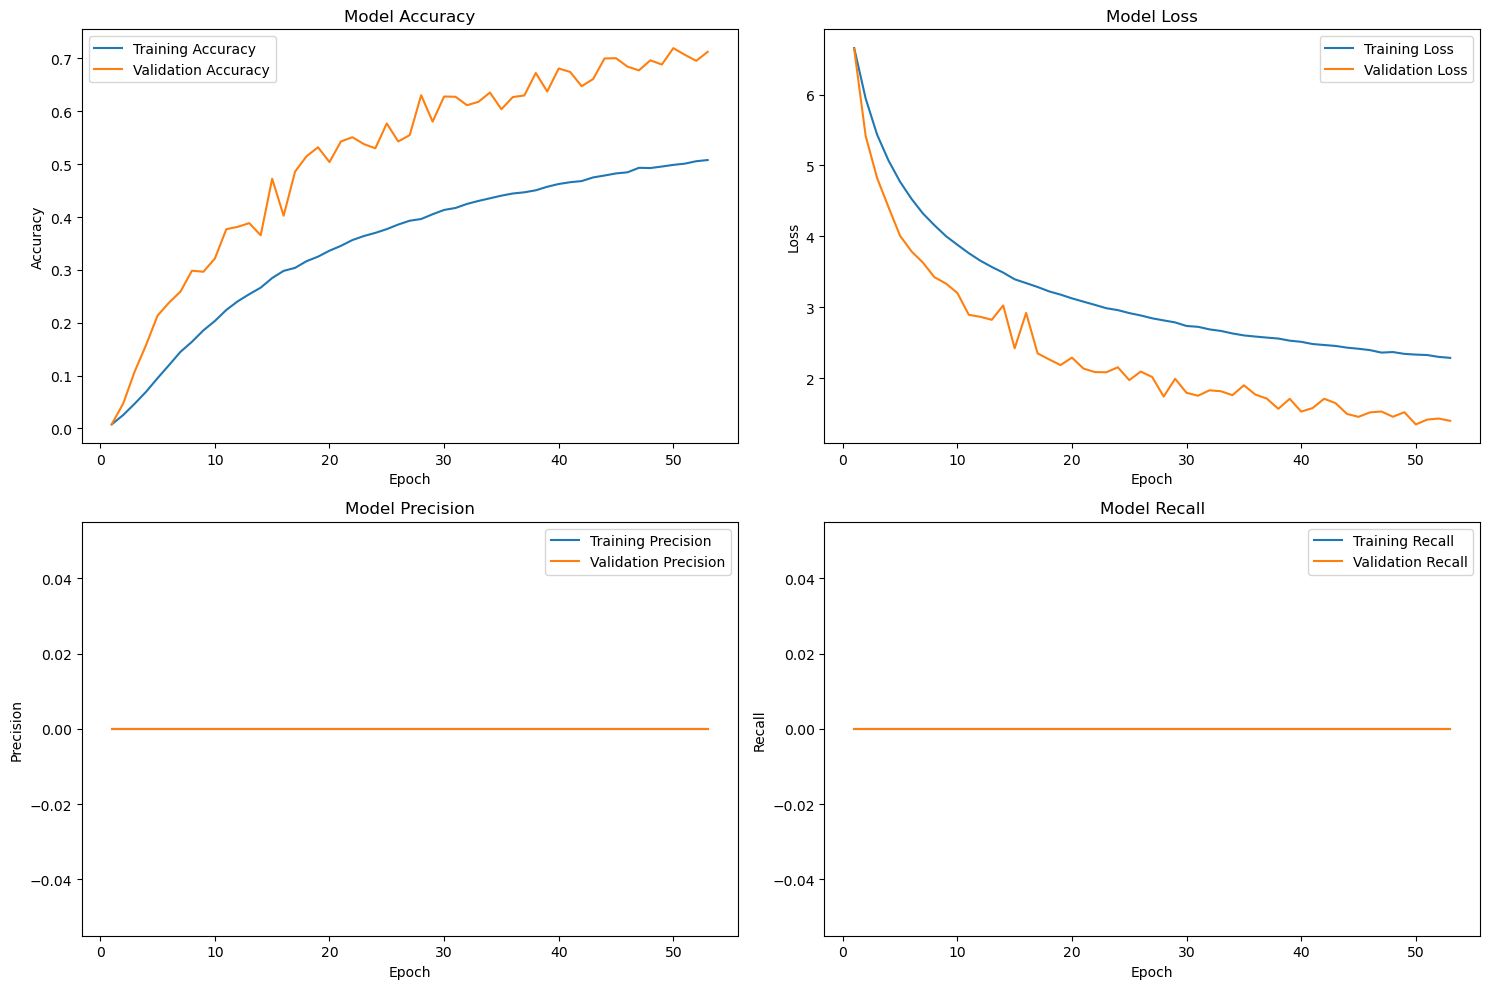

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 545s 299ms/step - accuracy: 0.5062 - loss: 2.2902 - precision_6: 0.7906 - recall_6: 0.3151 - val_accuracy: 0.7125 - val_loss: 1.3982 - val_precision_6: 0.8655 - val_recall_6: 0.5890 - learning_rate: 1.0000e-04

Global Epoch 54/100
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5086 - loss: 2.2686 - precision_6: 0.7964 - recall_6: 0.3215
Epoch 1: val_accuracy did not improve from 0.71950



Global Epoch 54 Metrics:
Time taken: 8.78 minutes
Training Accuracy: 0.5099
Validation Accuracy: 0.7135
Training Loss: 2.2731
Validation Loss: 1.3992
Model saved to: /Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/model_epoch_54.h5


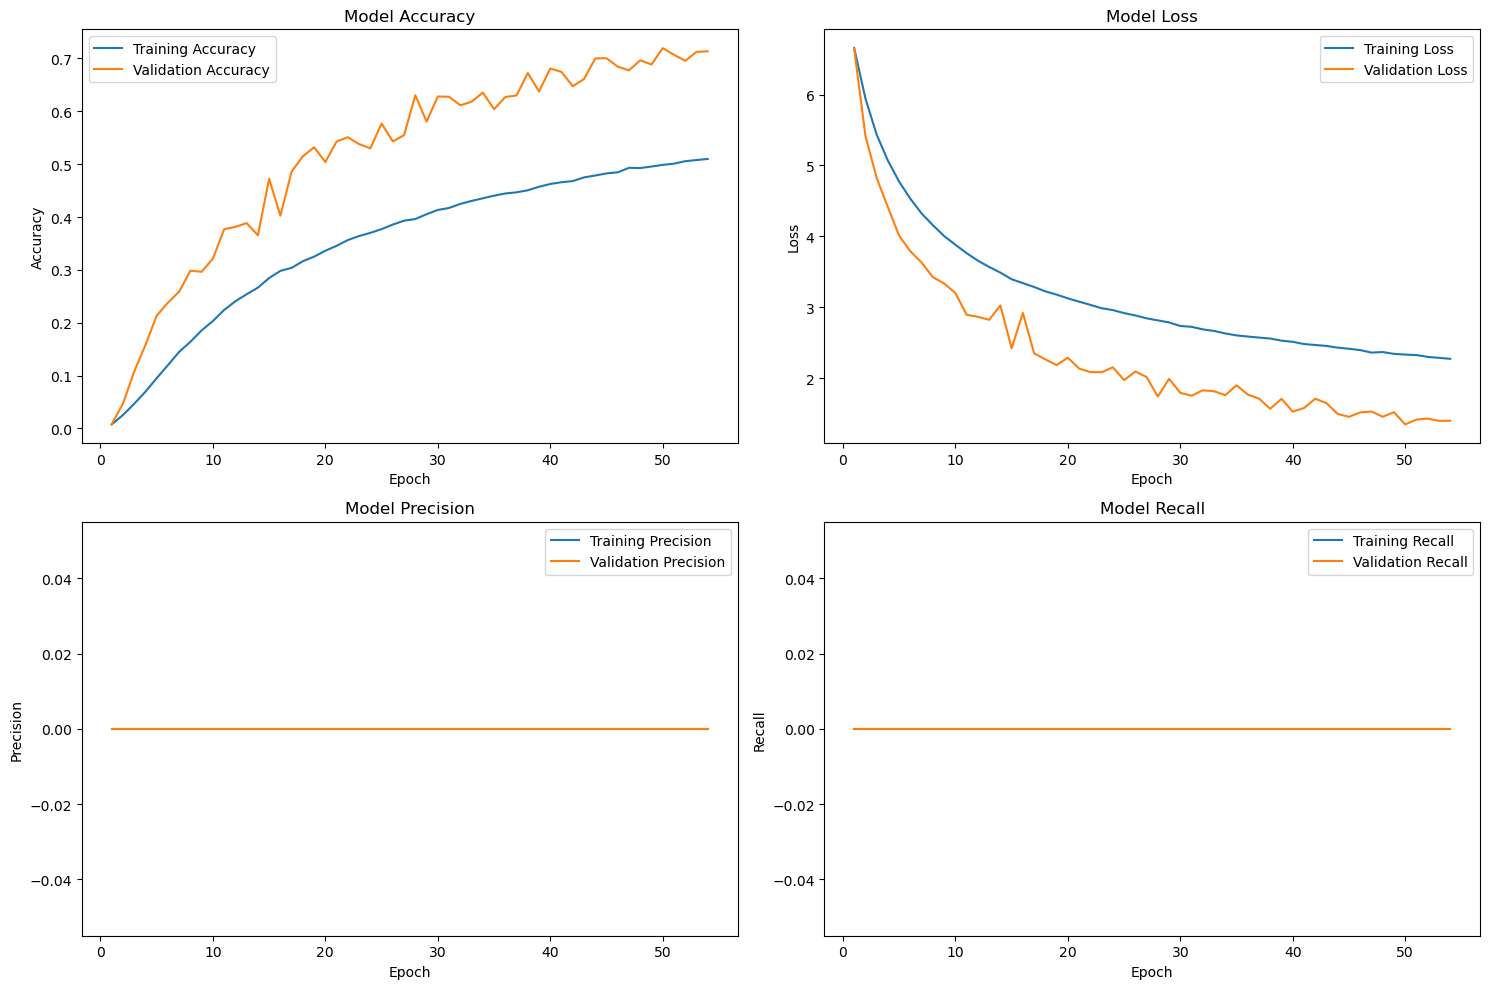

1825/1825 ━━━━━━━━━━━━━━━━━━━━ 527s 289ms/step - accuracy: 0.5086 - loss: 2.2686 - precision_6: 0.7964 - recall_6: 0.3215 - val_accuracy: 0.7135 - val_loss: 1.3992 - val_precision_6: 0.8591 - val_recall_6: 0.6005 - learning_rate: 1.0000e-04

Global Epoch 55/100
1194/1825 ━━━━━━━━━━━━━━━━━━━━ 3:01 287ms/step - accuracy: 0.5168 - loss: 2.2463 - precision_6: 0.7954 - recall_6: 0.3274

In [ ]:
import os
import time
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, 
                                     Dense, Flatten, Dropout)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

# Enhanced Custom Callback to track and save detailed epoch metrics
class EpochMetricsCallback(Callback):
    def __init__(self, working_path):
        super().__init__()
        self.working_path = working_path
        self.epoch_metrics_file = os.path.join(working_path, 'epoch_metrics.json')
        self.epoch_metrics = self.load_existing_metrics()

    def load_existing_metrics(self):
        try:
            with open(self.epoch_metrics_file, 'r') as f:
                return json.load(f)
        except FileNotFoundError:
            return []

    def save_epoch_metrics(self):
        with open(self.epoch_metrics_file, 'w') as f:
            json.dump(self.epoch_metrics, f, indent=4)

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        
        # Determine the correct global epoch number
        global_epoch_num = len(self.epoch_metrics) + 1
        
        epoch_metrics = {
            'global_epoch': global_epoch_num,
            'local_epoch': global_epoch_num,  # Use global epoch as local epoch
            'duration_minutes': epoch_duration / 60,
            'accuracy': logs.get('accuracy', 0),
            'val_accuracy': logs.get('val_accuracy', 0),
            'loss': logs.get('loss', 0),
            'val_loss': logs.get('val_loss', 0),
            'precision': logs.get('precision', 0),
            'val_precision': logs.get('val_precision', 0),
            'recall': logs.get('recall', 0),
            'val_recall': logs.get('val_recall', 0)
        }
        
        self.epoch_metrics.append(epoch_metrics)
        self.save_epoch_metrics()
        
        # Print detailed metrics
        print(f"\nGlobal Epoch {global_epoch_num} Metrics:")
        print(f"Time taken: {epoch_metrics['duration_minutes']:.2f} minutes")
        print(f"Training Accuracy: {epoch_metrics['accuracy']:.4f}")
        print(f"Validation Accuracy: {epoch_metrics['val_accuracy']:.4f}")
        print(f"Training Loss: {epoch_metrics['loss']:.4f}")
        print(f"Validation Loss: {epoch_metrics['val_loss']:.4f}")

        # Save the model after every epoch
        model_path = os.path.join(self.working_path, f'model_epoch_{global_epoch_num}.h5')
        self.model.save(model_path)
        print(f"Model saved to: {model_path}")

        # Plot metrics after each epoch
        plot_metrics(self.epoch_metrics)

# Set paths
BASE_PATH = '/Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/400BirdSpecies'
WORKING_PATH = '/Users/sridhariyer/Sridhar/PHD FINAL PROJECT/Untitled Folder/'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Enhanced data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

n_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())

# Load previous training state with detailed tracking
def load_previous_state(working_path):
    try:
        with open(os.path.join(working_path, 'training_state.json'), 'r') as f:
            state = json.load(f)
            return (
                state.get('global_epoch', 0), 
                state.get('best_val_accuracy', 0),
                state.get('model_path', None)
            )
    except FileNotFoundError:
        return 0, 0, None

# Save training state with detailed tracking
def save_training_state(working_path, global_epoch, best_val_accuracy, model_path):
    state = {
        'global_epoch': global_epoch,
        'best_val_accuracy': best_val_accuracy,
        'model_path': model_path
    }
    with open(os.path.join(working_path, 'training_state.json'), 'w') as f:
        json.dump(state, f, indent=4)

# Create custom CNN model
def create_custom_cnn(input_shape=(224, 224, 3), num_classes=n_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, 
               kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.35),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', 
               kernel_initializer='he_normal', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Flatten and Fully Connected Layers
        Flatten(),
        
        Dense(512, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Function to save best model
def save_best_model(model, val_accuracy, best_val_accuracy, working_path):
    # Save the new model if it's the best
    if val_accuracy > best_val_accuracy:
        model_path = os.path.join(working_path, 'best_model.h5')
        model.save(model_path)
        print(f"New best model saved with validation accuracy: {val_accuracy}")
        return val_accuracy, model_path
    return best_val_accuracy, None

# Plot metrics function
def plot_metrics(epoch_metrics):
    metrics = epoch_metrics[-1]  # Get the latest epoch metrics
    epochs = [m['global_epoch'] for m in epoch_metrics]
    
    plt.figure(figsize=(15, 10))

    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs, [m['accuracy'] for m in epoch_metrics], label='Training Accuracy')
    plt.plot(epochs, [m['val_accuracy'] for m in epoch_metrics], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs, [m['loss'] for m in epoch_metrics], label='Training Loss')
    plt.plot(epochs, [m['val_loss'] for m in epoch_metrics], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precision plot
    plt.subplot(2, 2, 3)
    plt.plot(epochs, [m['precision'] for m in epoch_metrics], label='Training Precision')
    plt.plot(epochs, [m['val_precision'] for m in epoch_metrics], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall plot
    plt.subplot(2, 2, 4)
    plt.plot(epochs, [m['recall'] for m in epoch_metrics], label='Training Recall')
    plt.plot(epochs, [m['val_recall'] for m in epoch_metrics], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize the callback
epoch_metrics_callback = EpochMetricsCallback(WORKING_PATH)

# Load previous state with global epoch
global_epoch, best_val_accuracy, previous_model_path = load_previous_state(WORKING_PATH)

# Create or load the model
if os.path.exists(os.path.join(WORKING_PATH, 'best_model.h5')):
    print("Loading previous model...")
    model = load_model(os.path.join(WORKING_PATH, 'best_model.h5'))
else:
    model = create_custom_cnn()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# Callbacks
checkpoint = ModelCheckpoint(
    filepath=os.path.join(WORKING_PATH, 'checkpoint_epoch-{epoch:02d}_val_loss-{val_loss:.2f}.weights.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-7
)

# Training configuration
total_epochs = 100
histories = []
total_start_time = time.time()

# Continue training from the last global epoch
for _ in range(global_epoch, total_epochs):
    # Increment global epoch
    global_epoch += 1
    
    print(f'\nGlobal Epoch {global_epoch}/{total_epochs}')
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=1,
        callbacks=[checkpoint, early_stopping, reduce_lr, epoch_metrics_callback],
        verbose=1
    )
    
    # Check and save best model
    val_accuracy = history.history['val_accuracy'][0]
    best_val_accuracy, model_path = save_best_model(model, val_accuracy, best_val_accuracy, WORKING_PATH)
    
    # Track history
    histories.append(history)
    
    # Save training state
    save_training_state(WORKING_PATH, global_epoch, best_val_accuracy, model_path or previous_model_path)
    
    # Optional: early stopping if val_accuracy doesn't improve
    if early_stopping.model.stop_training:
        print("Early stopping triggered. Training complete.")
        break

# Total training time
total_training_time = (time.time() - total_start_time) / 60
print(f"\nTotal Training Time: {total_training_time:.2f} minutes")

# Print final training summary
print("\nTraining Summary:")
print(f"Total Global Epochs: {global_epoch}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Total Training Time: {total_training_time:.2f} minutes")